<a href="https://colab.research.google.com/github/schokoro/AttentionNMT/blob/en_ir/en_ir_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Первым делом проверим какая карточка нам досталась. Лучшим вариантом будет `Tesla P100-PCIE-16GB`, на остальных будет считаться медленнее.

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    raise RuntimeError
else:
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
!pip install janome pandarallel  > /dev/null

In [ ]:
!rm -rf AttentionNMT/
!git clone -b dev https://github.com/schokoro/AttentionNMT.git > /dev/null

Cloning into 'AttentionNMT'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 55 (delta 29), reused 28 (delta 13), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [ ]:
import sys
sys.path.append('/content/AttentionNMT')

In [ ]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%reload_ext autoreload
%autoreload 2
import AttentionNMT
from AttentionNMT.transformer import Transformer, Encoder, Decoder
from AttentionNMT.utils import count_parameters, initialize_weights, translate_sentence, evaluate_blue, train, evaluate, display_attention, sentence_blue

In [ ]:
%autoreload 2
from typing import Dict, List, Optional
import torch.nn as nn

from matplotlib.font_manager import FontProperties
from torchtext.data import Field, BucketIterator
from tqdm.notebook import tqdm
from pandarallel import pandarallel
import spacy
import warnings
import re
import random
import math
import time
from janome.tokenizer import Tokenizer as JTokenizer
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
tqdm.pandas()
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=False)

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Подготовка данных и EDA

## Подготовка корпуса

Посмотрим, как выглядит корпус:

Нам нужны только строки с префиксом `A:`
Для токенизации английского языка будем использовать spacy, для японского - токенизатор janome. Для англо-японского перевода будет лучше, если японский текст мы развернём задом наперёд. Просто поверьте. Или можете проверить. Соответственно, при переводе нам будет необходимо развернуть переведённый текст обратно.

In [ ]:
reverse_src = False
reverse_trg = True

In [ ]:
nlp = spacy.load("en_core_web_sm")
jt = JTokenizer()
en_remove = re.compile(r'#ID=.+')
is_token = re.compile(r'\w+')


def get_pair(line: str, reverse=reverse_src) -> Dict[str, str]:
    """
    Принимает на вход строку из файла паралелльного корпуса, возвращает словарь
     с японским и английским предложениями
    """
    jap, en = line.strip().split('\t')
    jap = jap.replace('A: ', '').strip()
    en = en_remove.sub('', en)
    return {'en': en, 'jap': jap}
  
def src_tokenize(text: str, reverse=reverse_src) -> List[str]:
    """
    Токенизирует английский текст, возвращает список токенов.
    """
    tokens = [tok.text for tok in nlp.tokenizer(text)]
    if reverse:
        tokens.reverse()
    return tokens


def trg_tokenize(text: str, reverse=reverse_trg) -> List[str]:
    """
    Токенизирует японский текст, возвращает список токенов в обратном порядке

    """
    tokens = [token.base_form for token in jt.tokenize(text)][: : -1]
    if reverse:
        tokens.reverse()
    return tokens


dicts = []
with open('examples.utf', 'r') as fobj:
    for i, line in enumerate(fobj):
        if line.startswith('A:'):
            dicts.append(get_pair(line))


corpus_df = pd.DataFrame(dicts)   

Посчитаем длины предложений в символах и посмотрим их корреляцию.

In [ ]:
corpus_df['en_len'] = corpus_df['en'].map(lambda x: len(x))
corpus_df['jap_len'] = corpus_df['jap'].map(lambda x: len(x))

In [ ]:
corpus_df[['en_len','jap_len' ]].corr()

,en_len,jap_len
en_len,1.000000,0.809457
jap_len,0.809457,1.000000


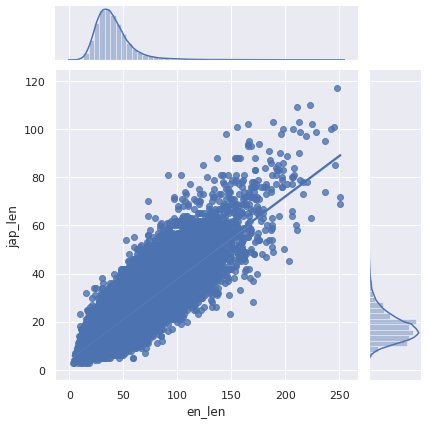

In [ ]:
sns.jointplot("en_len", "jap_len", data=corpus_df, kind="reg");

А теперь - длины предложений в токенах и их корреляцию.

In [ ]:
%time corpus_df['en_tok_len'] = corpus_df['en'].parallel_apply(lambda x: len(src_tokenize(x)))

CPU times: user 55.7 ms, sys: 102 ms, total: 158 ms
Wall time: 6.8 s


In [ ]:
%time corpus_df['jap_tok_len'] = corpus_df['jap'].parallel_apply(lambda x: len(trg_tokenize(x)))

CPU times: user 143 ms, sys: 127 ms, total: 270 ms
Wall time: 2min 43s


In [ ]:
corpus_df[['en_tok_len','jap_tok_len' ]].corr()

,en_tok_len,jap_tok_len
en_tok_len,1.000000,0.775549
jap_tok_len,0.775549,1.000000


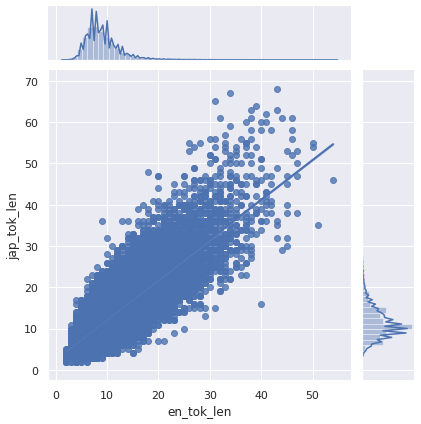

In [ ]:
sns.jointplot("en_tok_len", "jap_tok_len", data=corpus_df, kind="reg")

In [ ]:
corpus_df.describe()

,en_len,jap_len,en_tok_len,jap_tok_len
count,149791.000000,149791.000000,149791.000000,149791.000000
mean,40.471270,18.378407,9.307989,11.744270
std,17.417855,7.237879,3.594693,4.449102
min,3.000000,3.000000,2.000000,2.000000
25%,29.000000,14.000000,7.000000,9.000000
50%,37.000000,17.000000,9.000000,11.000000
75%,47.000000,21.000000,11.000000,14.000000
max,251.000000,117.000000,54.000000,68.000000


Выбросим из корпуса предложения длиннее чем `quantile(0.9)` и сохраним в файл.

In [ ]:
corpus_df.en_tok_len.quantile(0.9), corpus_df.jap_tok_len.quantile(0.9)

(13.0, 17.0)

In [ ]:
new_corpus_df = corpus_df[
    (corpus_df.en_tok_len < corpus_df.en_tok_len.quantile(0.9)) &
    (corpus_df.jap_tok_len < corpus_df.jap_tok_len.quantile(0.9)) 
]
corpus_df.shape

(149791, 6)

In [ ]:
new_corpus_df.to_csv('en_jap_corpus.csv', index=None, columns=['en', 'jap'])

In [ ]:
max_src = corpus_df.en_tok_len.max() + 2
max_trg = corpus_df.jap_tok_len.max() + 2

In [ ]:
SRC = Field(
            tokenize = src_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(
            tokenize = trg_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
%%time
trn_data_fields = [("src", SRC), ("trg", TRG)]

dataset = torchtext.data.TabularDataset(
    path='en_jap_corpus.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

CPU times: user 2min 38s, sys: 585 ms, total: 2min 38s
Wall time: 2min 38s


In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [ ]:
SRC.build_vocab(train_data.src, min_freq=3)  # 
print(SRC.vocab.freqs.most_common(10))

TRG.build_vocab(train_data.trg, min_freq=3)
print(TRG.vocab.freqs.most_common(10))

print(f'SRC.vocab: {len(SRC.vocab)}, TRG.vocab: {len(TRG.vocab)}')

[('.', 110945), ('the', 47508), ('to', 26425), ('i', 25461), ('a', 21923), ('is', 20993), ('he', 19826), ('you', 15670), ('of', 14218), ('in', 13554)]
[('。', 121263), ('は', 93010), ('た', 51259), ('の', 48574), ('に', 48356), ('を', 47677), ('て', 34193), ('が', 30261), ('する', 27333), ('だ', 25724)]
SRC.vocab: 9050, TRG.vocab: 11167


In [ ]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    shuffle=True,
    device=device)

## Training the Transformer Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2 * HID_DIM
DEC_PF_DIM = 2 * HID_DIM
ENC_DROPOUT = 0.07
DEC_DROPOUT = 0.07

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              dropout=ENC_DROPOUT, 
              device=device,
              max_length=max_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM,
              dropout=DEC_DROPOUT, 
              device=device,
              max_length=max_trg)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
try:
    del model
    torch.cuda.empty_cache()
except:
    print('no model')

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

no model


We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,035,935 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

We then define a small function that we can use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
model.apply(initialize_weights);
best_macro_bleu = 0
test_loss = np.inf

In [ ]:
BEST_MODEL = 'best_blue_en_jap.pt'

In [ ]:
cross_entropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
LEARNING_RATE = 1.25e-3
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

def criterion(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return cross_entropy(pred_flat, target_flat)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.2,
                                                       verbose=True,
                                                       cooldown=0, 
                                                       patience=4,              
                                                       threshold=0.01,
                                                       min_lr=5e-5)

In [ ]:
train_history = []
valid_history = []
blue_history = []

In [ ]:
N_EPOCHS = 25
CLIP = 1

try:
    best_valid_loss = evaluate(model, valid_iterator, criterion)
except:
    best_valid_loss = float('inf')
print(f'Loss: {best_valid_loss:7.3f}')


for epoc_num, epoch in tqdm(enumerate(range(N_EPOCHS)), total=N_EPOCHS):
    curent_lr = optimizer.param_groups[0]['lr']
    start_time = time.time()
    try:
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 1, 1)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        scheduler.step(valid_loss)
                
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print('Новая лучшая модель')

        macro_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize)
        if macro_bleu > best_macro_bleu:
            best_macro_bleu = macro_bleu
            print('Новый лучший blue')            
            torch.save(model.state_dict(), BEST_MODEL)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        blue_history.append(macro_bleu)

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        
        print(f'\tMacro-average BLEU: {macro_bleu:.6f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print('_' * 100)
    except KeyboardInterrupt:
        print(f"Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]['lr']}")
        break
    finally:
        pass

Loss:   9.348


Новая лучшая модель
Новый лучший blue
Epoch: 01 | Time: 2m 38s
	Macro-average BLEU: 0.620819
	Train Loss: 3.578 | Train PPL:  35.807
	 Val. Loss: 2.559 |  Val. PPL:  12.927
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 02 | Time: 2m 39s
	Macro-average BLEU: 0.675381
	Train Loss: 2.337 | Train PPL:  10.354
	 Val. Loss: 2.005 |  Val. PPL:   7.426
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 03 | Time: 2m 37s
	Macro-average BLEU: 0.695993
	Train Loss: 1.896 | Train PPL:   6.661
	 Val. Loss: 1.759 |  Val. PPL:   5.805
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 04 | Time: 2m 39s
	Macro-average BLEU: 0.710601
	Train Loss: 1.640 | Train PPL:   5.154
	 Val. Loss: 1.644 |  Val. PPL:   5.174
_____

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.610 | Test PPL:   5.002 |


Для корректного отображения карт внимания загрузим шрифт `Osaka.ttf`. Хотя, можно взять и из репозитория.

In [ ]:
!wget -q https://github.com/vuthaihoc/fonts/raw/master/JUSTRAJDEEP/Osaka.ttf

fontprop_x = FontProperties(size=20)
fontprop_y = FontProperties(fname='Osaka.ttf', size=20)

src      : the post office is just off the main street .
trg      : 郵便 局 は 大通り から 少し 離れる た ところ に ある ます 。
predicted: 郵便 局 は 大通り から ずっと 安全 だ ところ に ある 。 <eos>
     blue: 69.34%


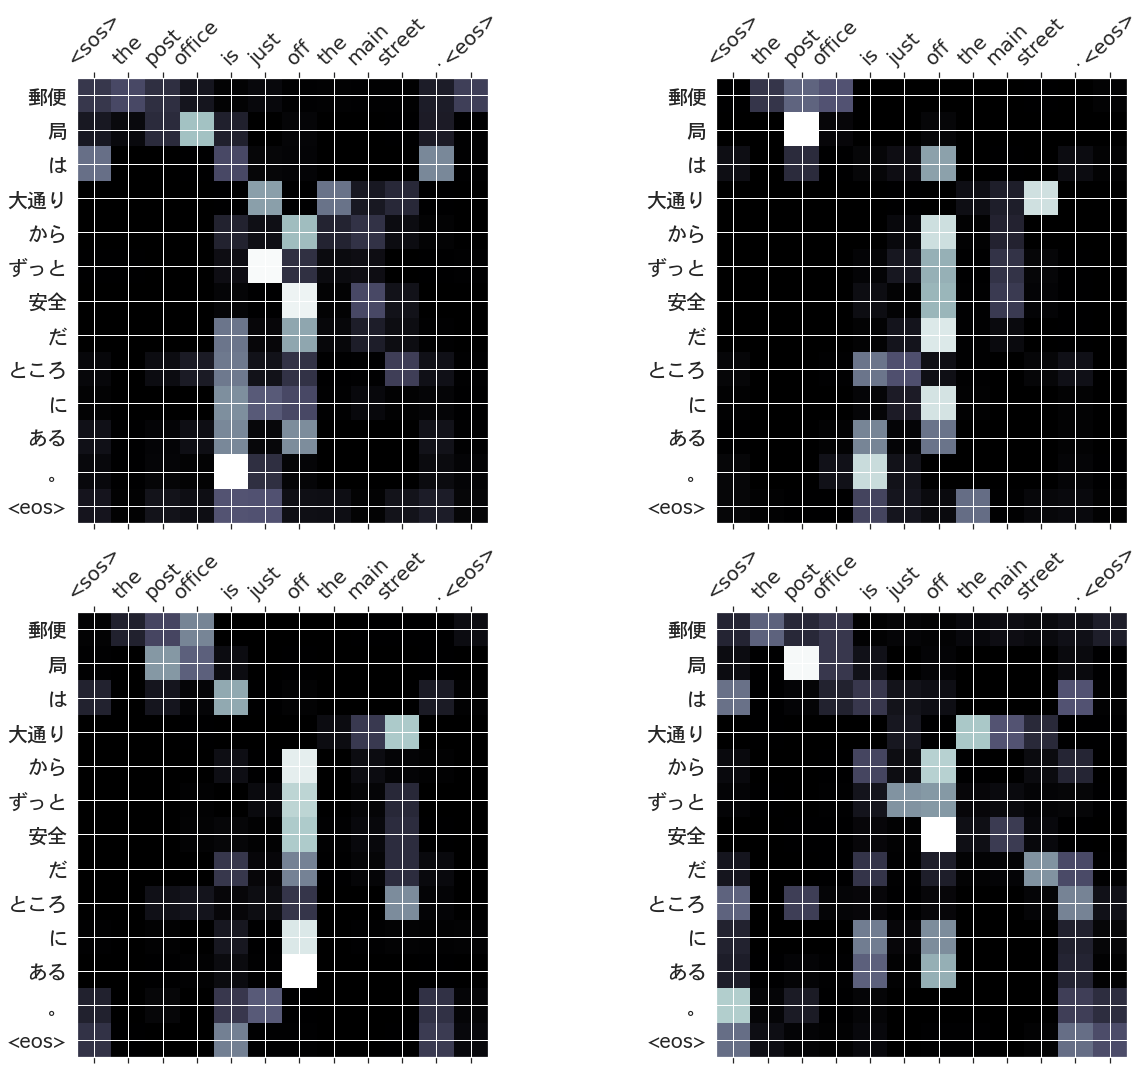

In [ ]:
example_idx = random.randint(0, len(train_data) - 1)

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()

if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

src      : could you page someone for me ?
trg      : 人 を 呼び出す て いる た だけ ます ん か 。
predicted: 呼び出す て いただける ます か 。 <eos>
     blue: 79.37%


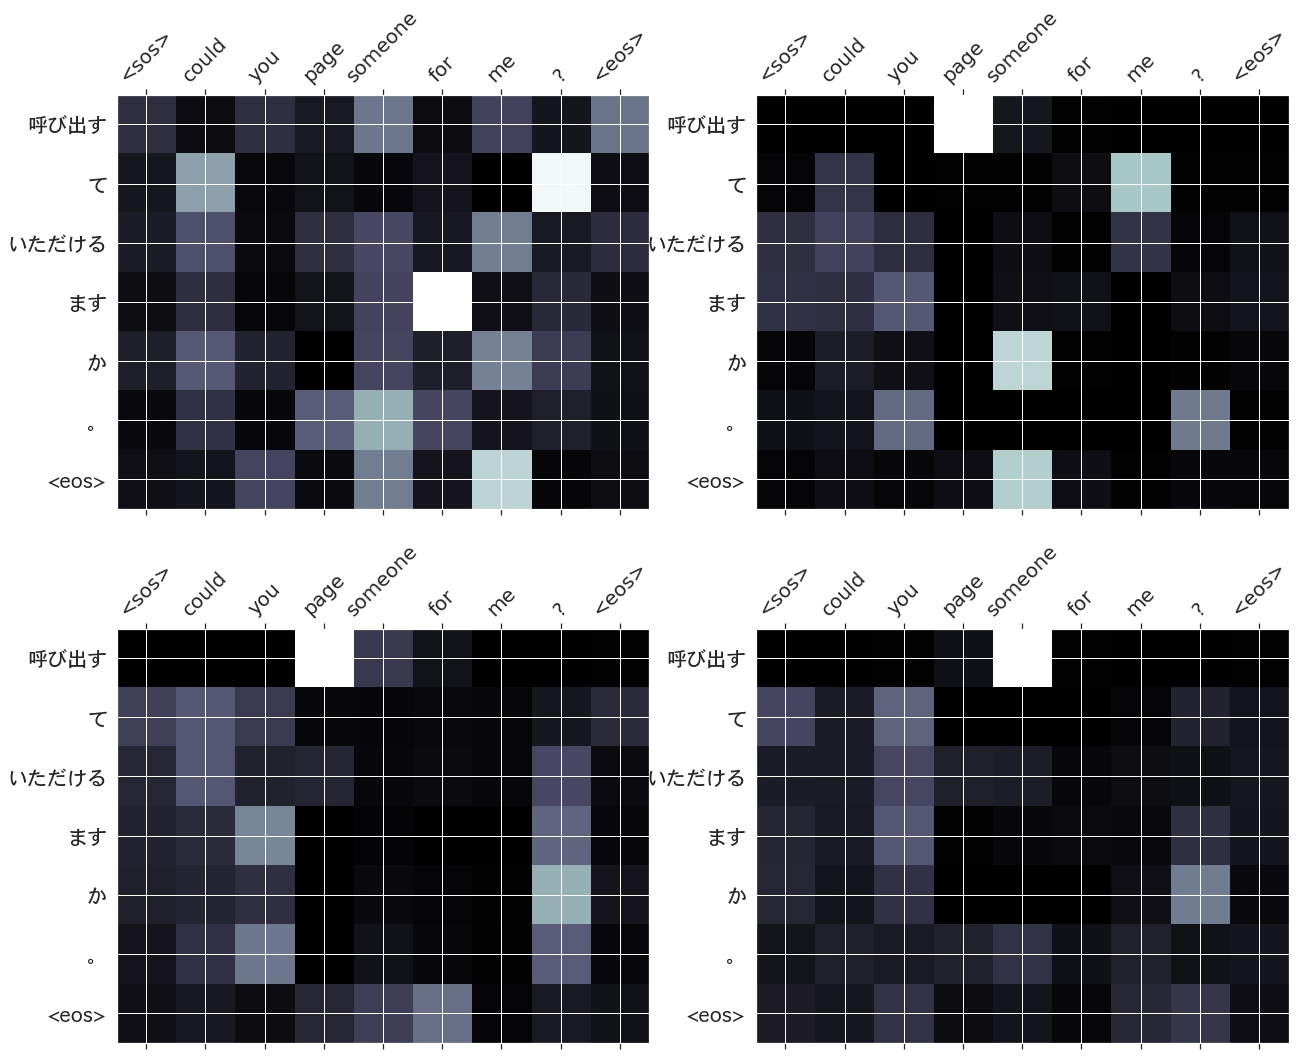

In [ ]:
example_idx = random.randint(0, len(valid_data) - 1)

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()

if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

src      : i have never been to england .
trg      : 私 は イギリス へ 行く た こと が ある ます ん 。
predicted: 私 は イギリス へ 行く た こと が ない 。 <eos>
     blue: 84.34%


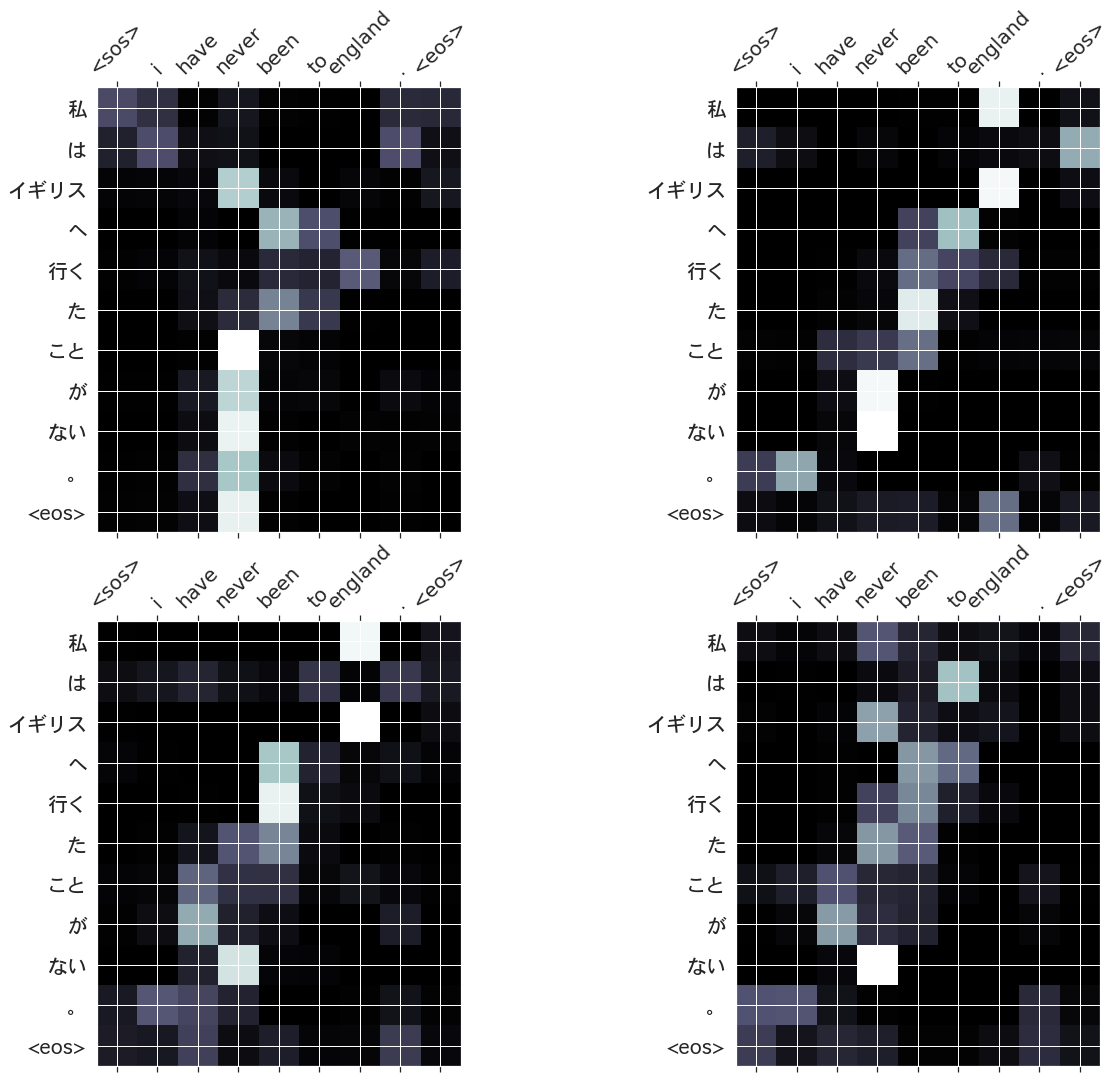

In [ ]:
example_idx = random.randint(0, len(test_data) - 1)

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()
 
if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

Выведем не более 50 предложений с `BLUE` не менее 0.9

src      : i fed some meat to my dog .
trg      : 私 は 犬 に 肉 を 与える た 。
predicted: 私 は 犬 に 肉 を やる た 。 <eos>
     blue: 97.10%


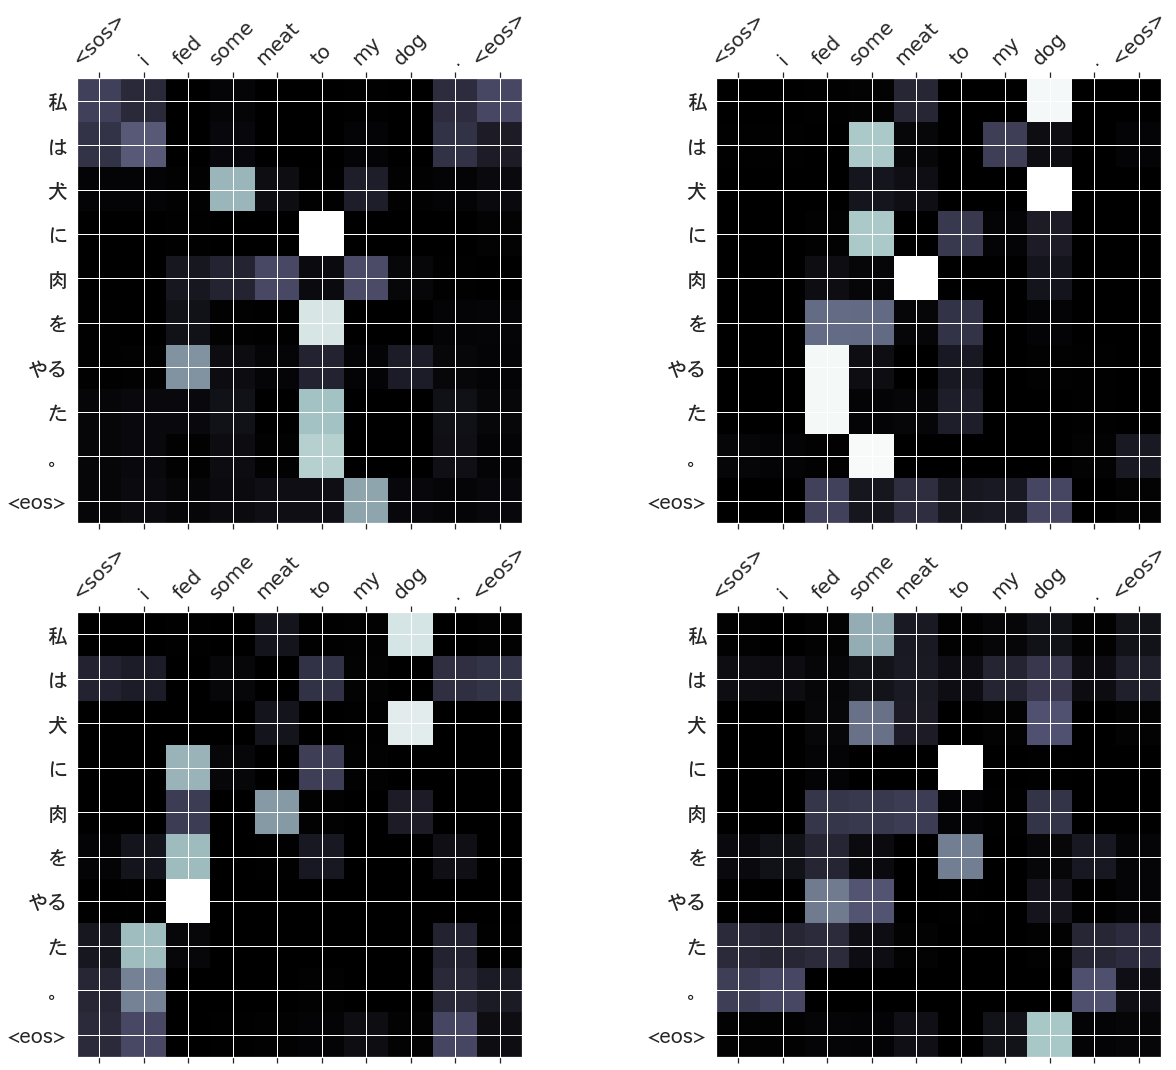

src      : the rain damped their spirits .
trg      : 雨 の ため に 彼ら は 気力 を そがれる た 。
predicted: 雨 が 激しい おさまる た 。 <eos>
     blue: 90.36%


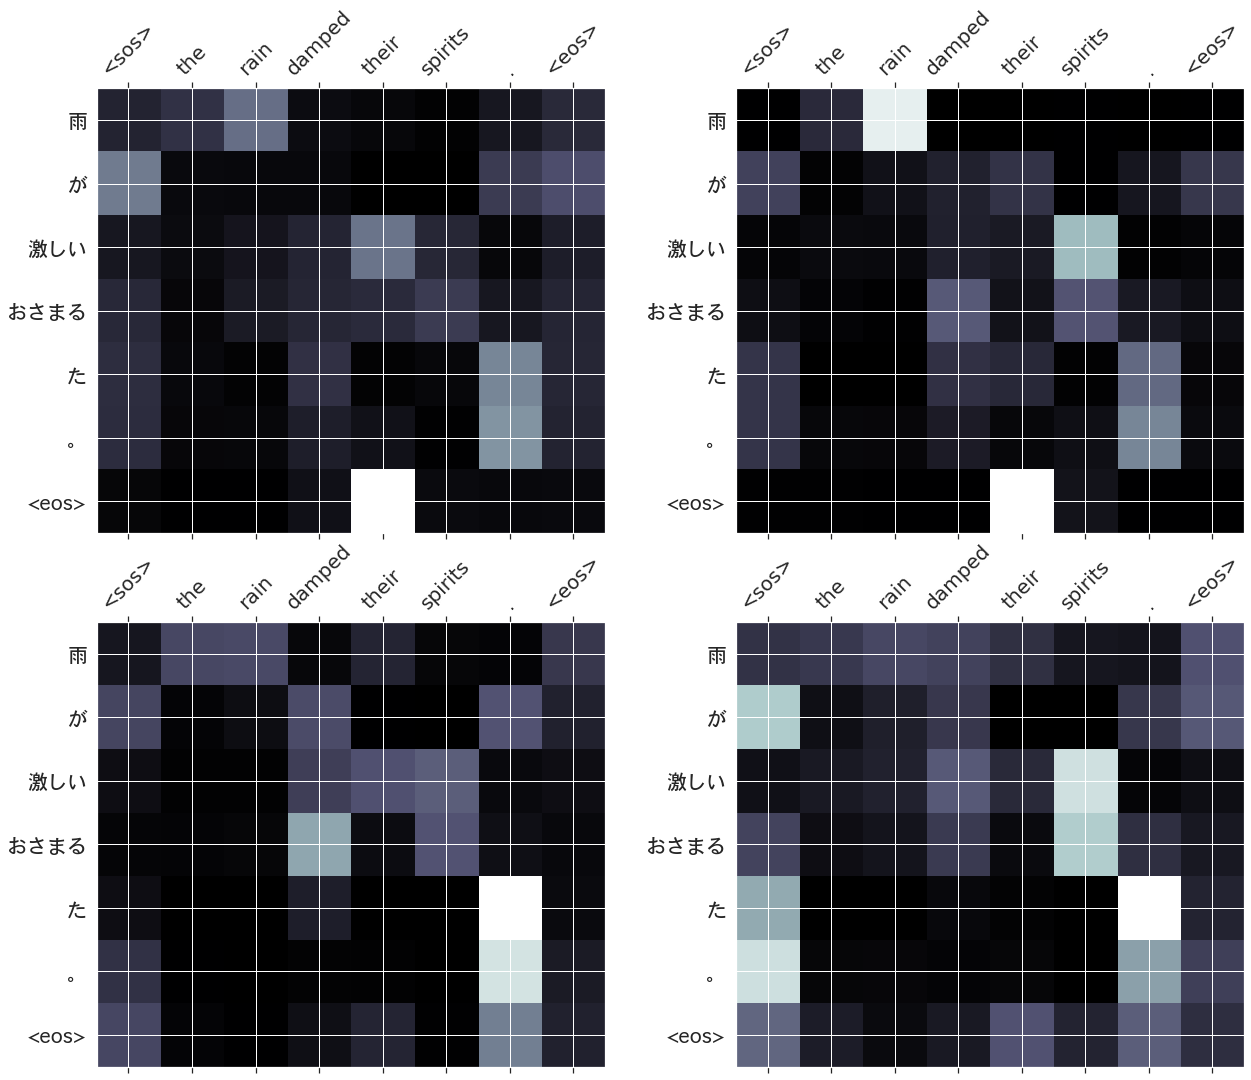

src      : i drew back the curtain .
trg      : 私 は カーテン を 開け放す た 。
predicted: 私 は カーテン を 引く た 。 <eos>
     blue: 91.93%


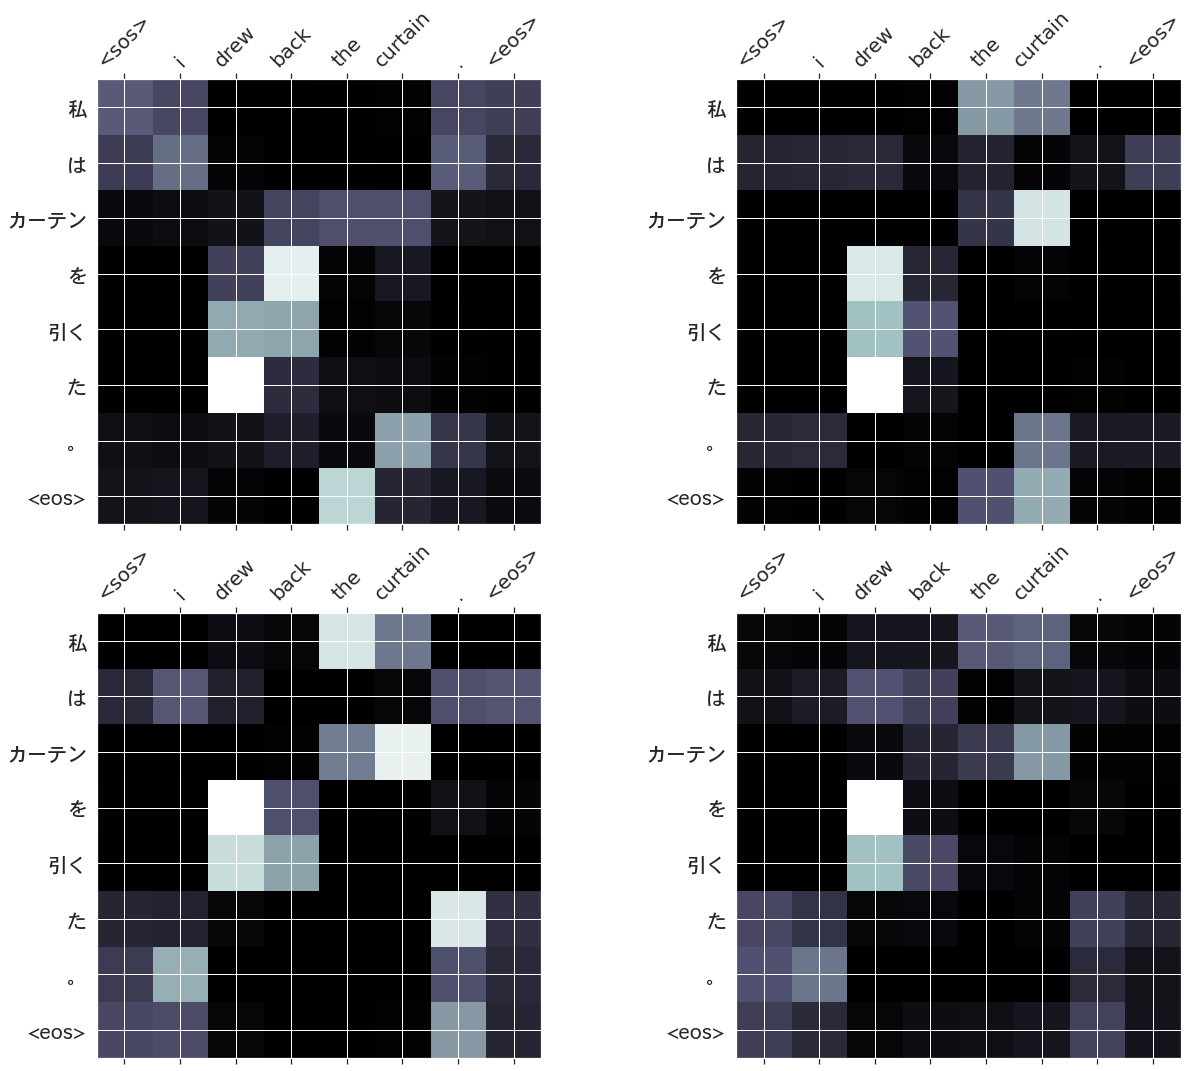

src      : the old man asked me the time .
trg      : その 老人 は 私 に 時間 を 尋ねる た 。
predicted: 老人 は 私 に 時間 を 尋ねる た 。 <eos>
     blue: 90.36%


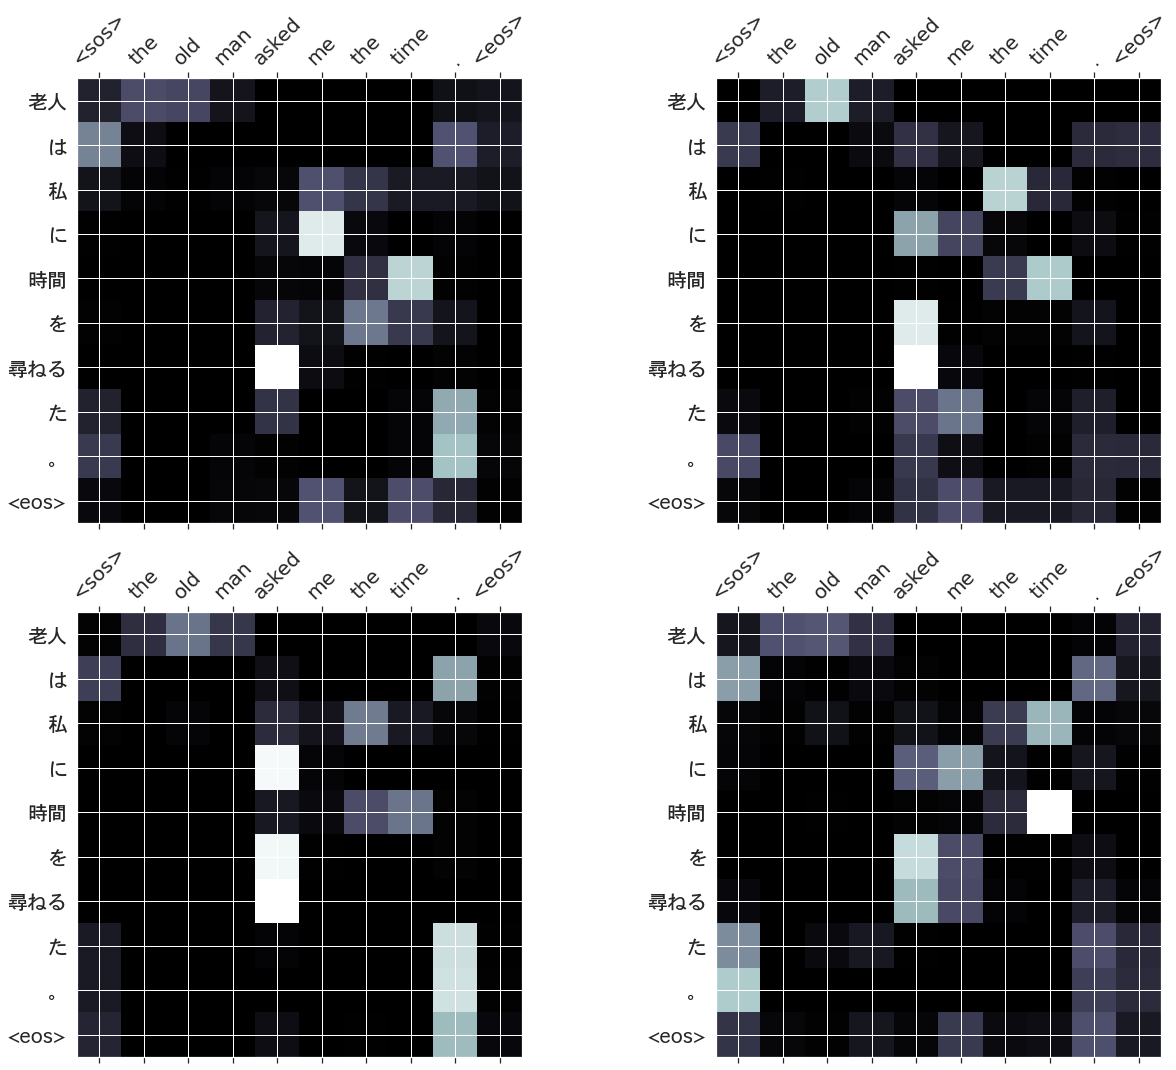

src      : i saw him go out .
trg      : 私 は 彼 が 出る て 行く の を 見る た 。
predicted: 私 は 彼 が 外出 する の を 見る た 。 <eos>
     blue: 92.35%


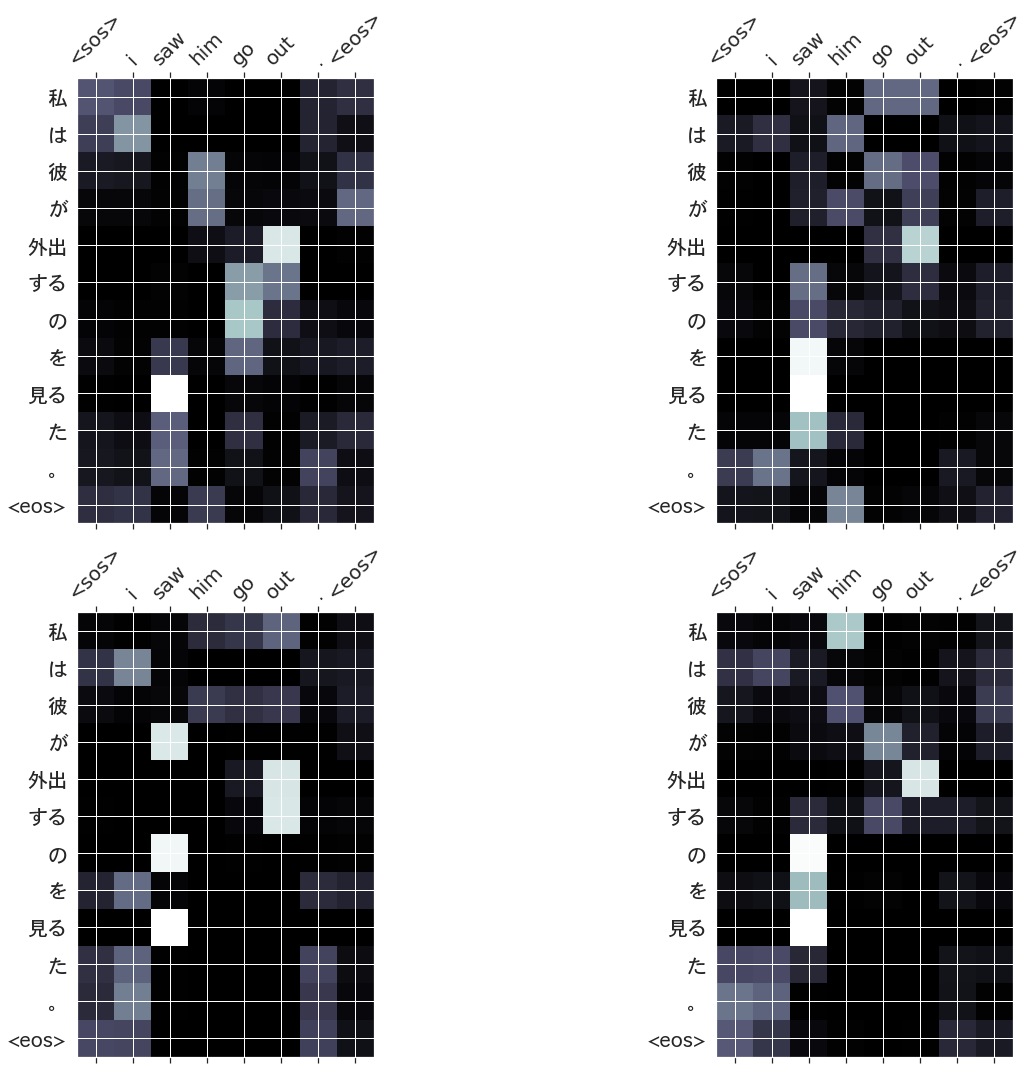

src      : she lived there for years .
trg      : 彼女 は そこ に 何 年間 も 住む で いる た 。
predicted: 彼女 は そこ に 何 年 も 住む で いる た 。 <eos>
     blue: 90.36%


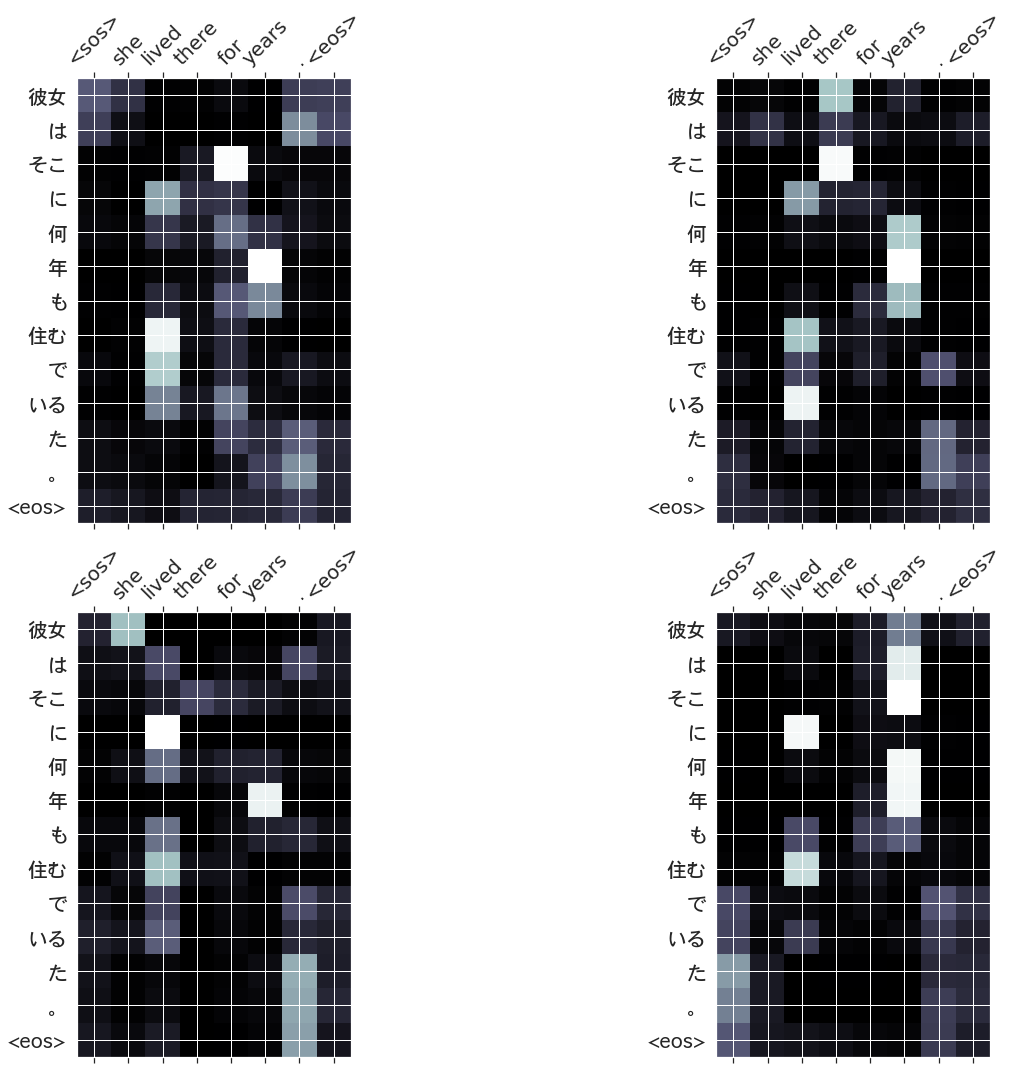

src      : we want a car .
trg      : 私 達 は 車 が 欲しい 。
predicted: 私 たち は 車 が 欲しい 。 <eos>
     blue: 91.93%


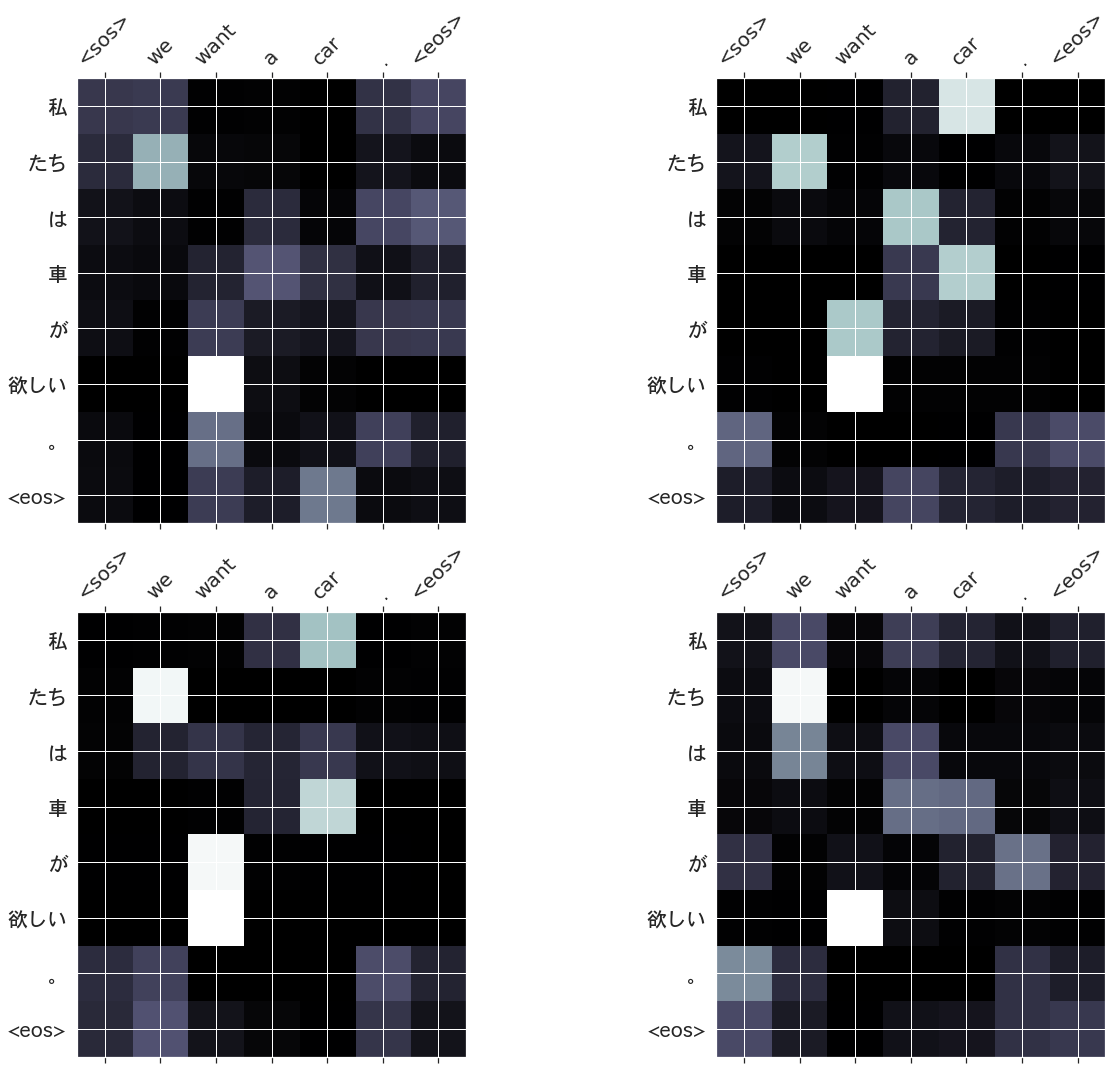

src      : it 's a sop to cerberus .
trg      : 役人 へ の 袖の下 だ よ 。
predicted: <unk> の <unk> だ よ 。 <eos>
     blue: 90.36%


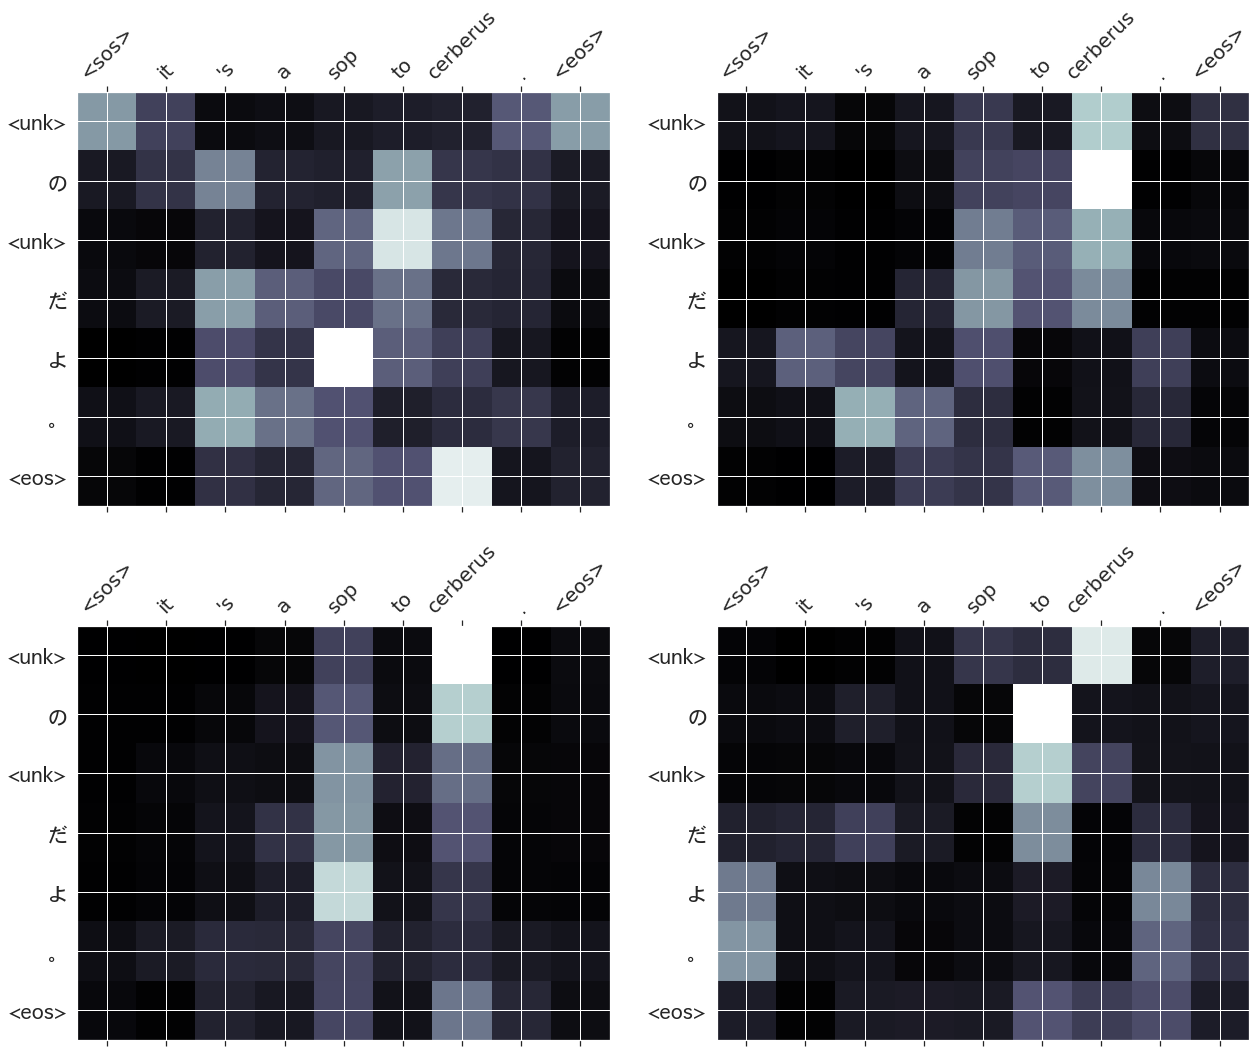

src      : he gave her a fond look .
trg      : 彼 は 彼女 に 優しい 眼差し を 投げかける た 。
predicted: 彼 は 彼女 に <unk> を 見る た 。 <eos>
     blue: 90.36%


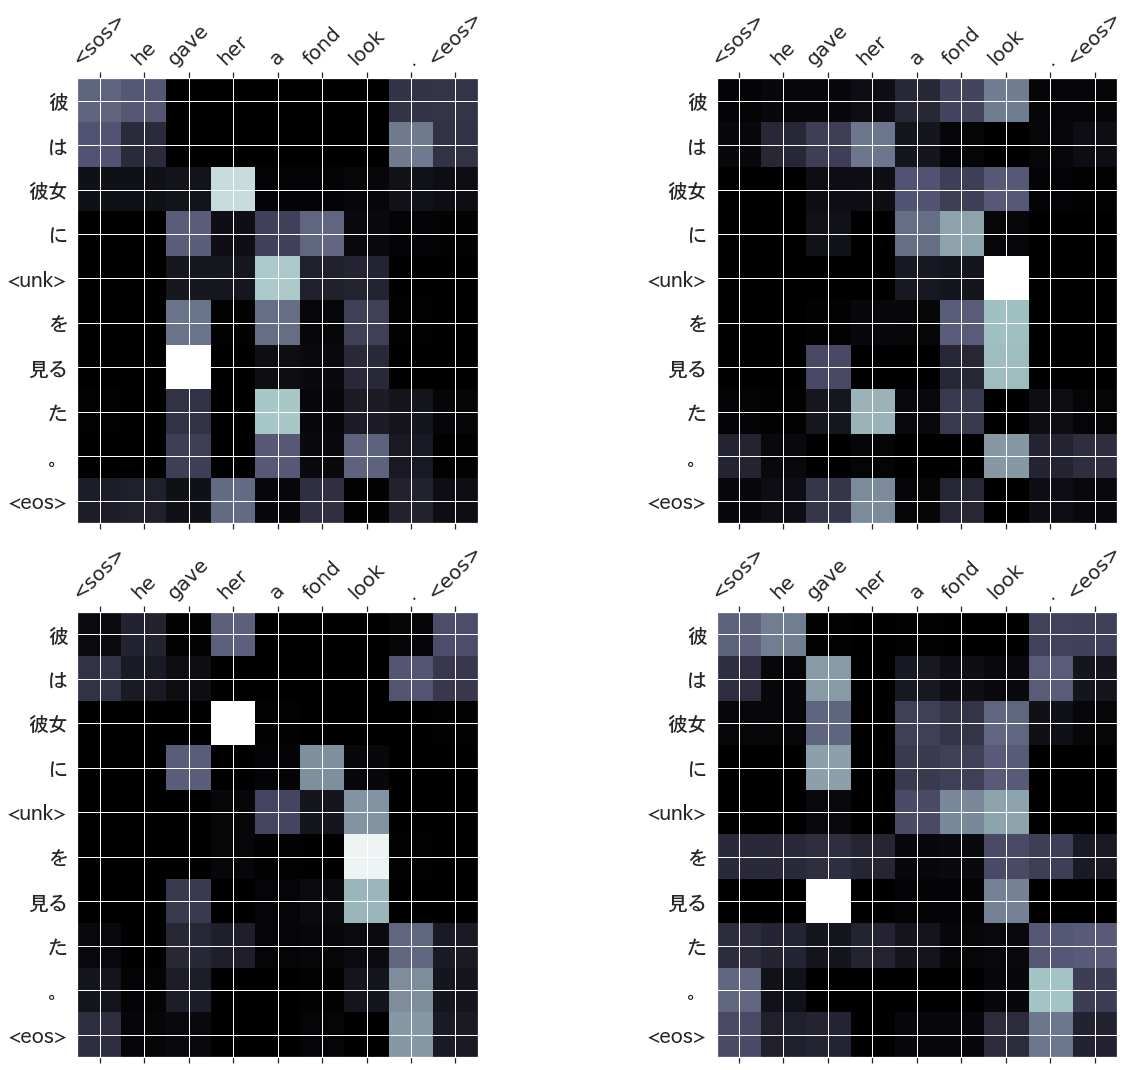

src      : they sat down by the fire .
trg      : 彼ら は たき火 の 側 に 座る ます た 。
predicted: 彼ら は 火 の 中 に 座る た 。 <eos>
     blue: 90.36%


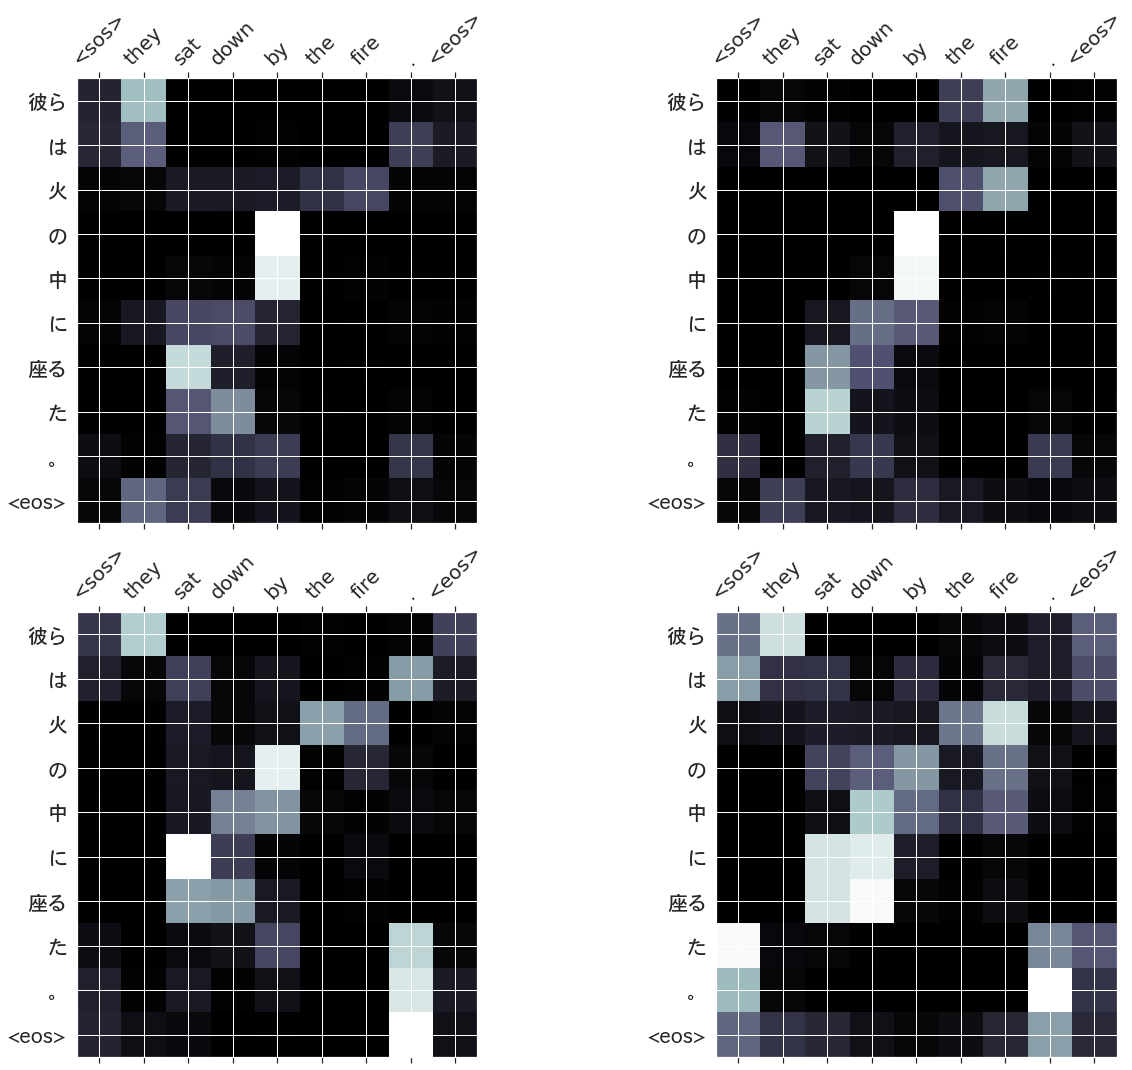

src      : the old man asked me the time .
trg      : その 老人 は 私 に 時間 を 尋ねる た 。
predicted: 老人 は 私 に 時間 を 尋ねる た 。 <eos>
     blue: 90.36%


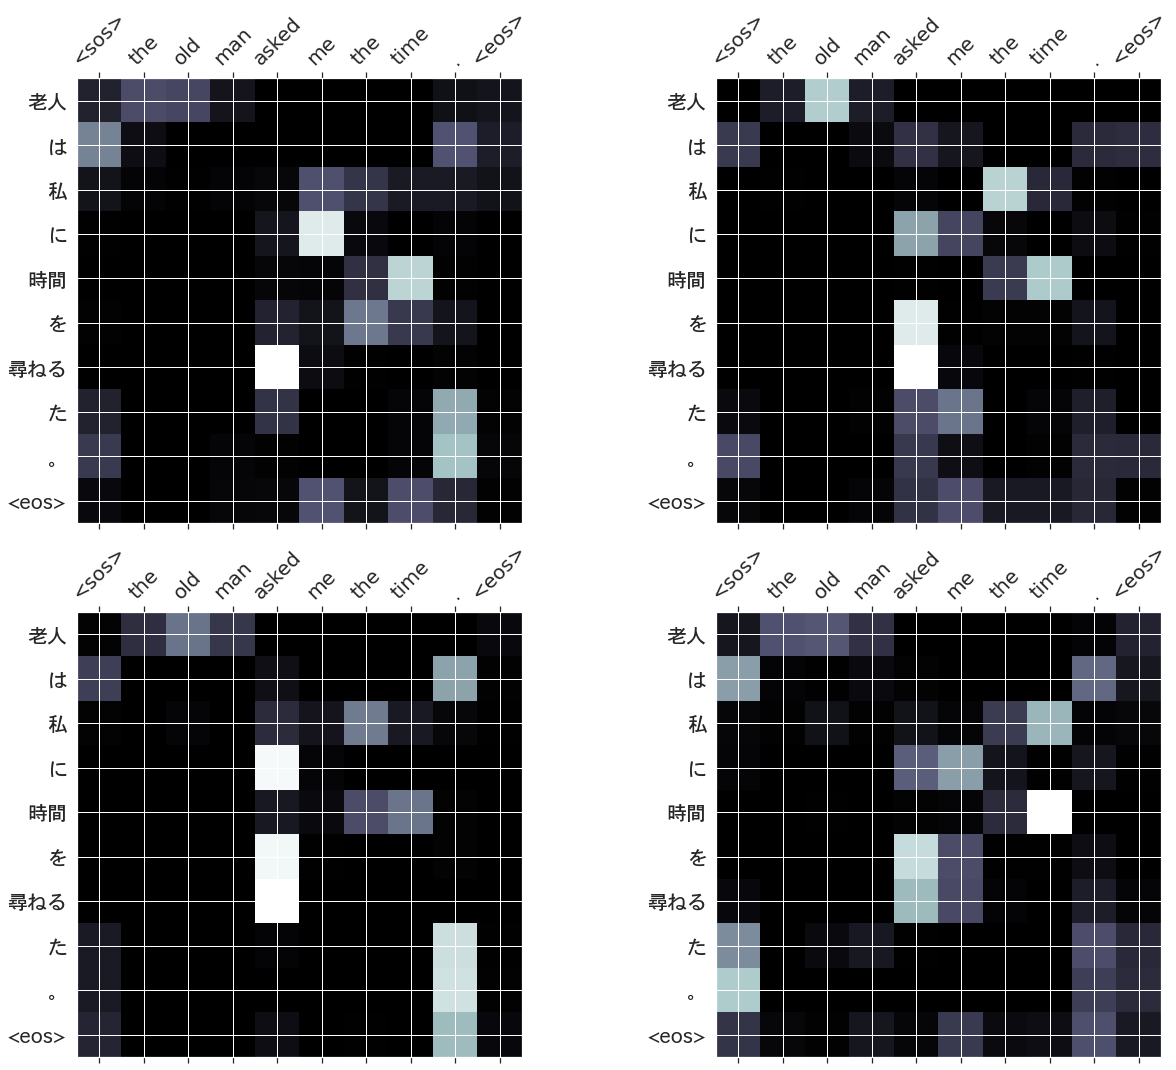

src      : the room was locked .
trg      : 部屋 に は 鍵 が かかる て いる た 。
predicted: 部屋 は 鍵 が かかる て いる た 。 <eos>
     blue: 90.36%


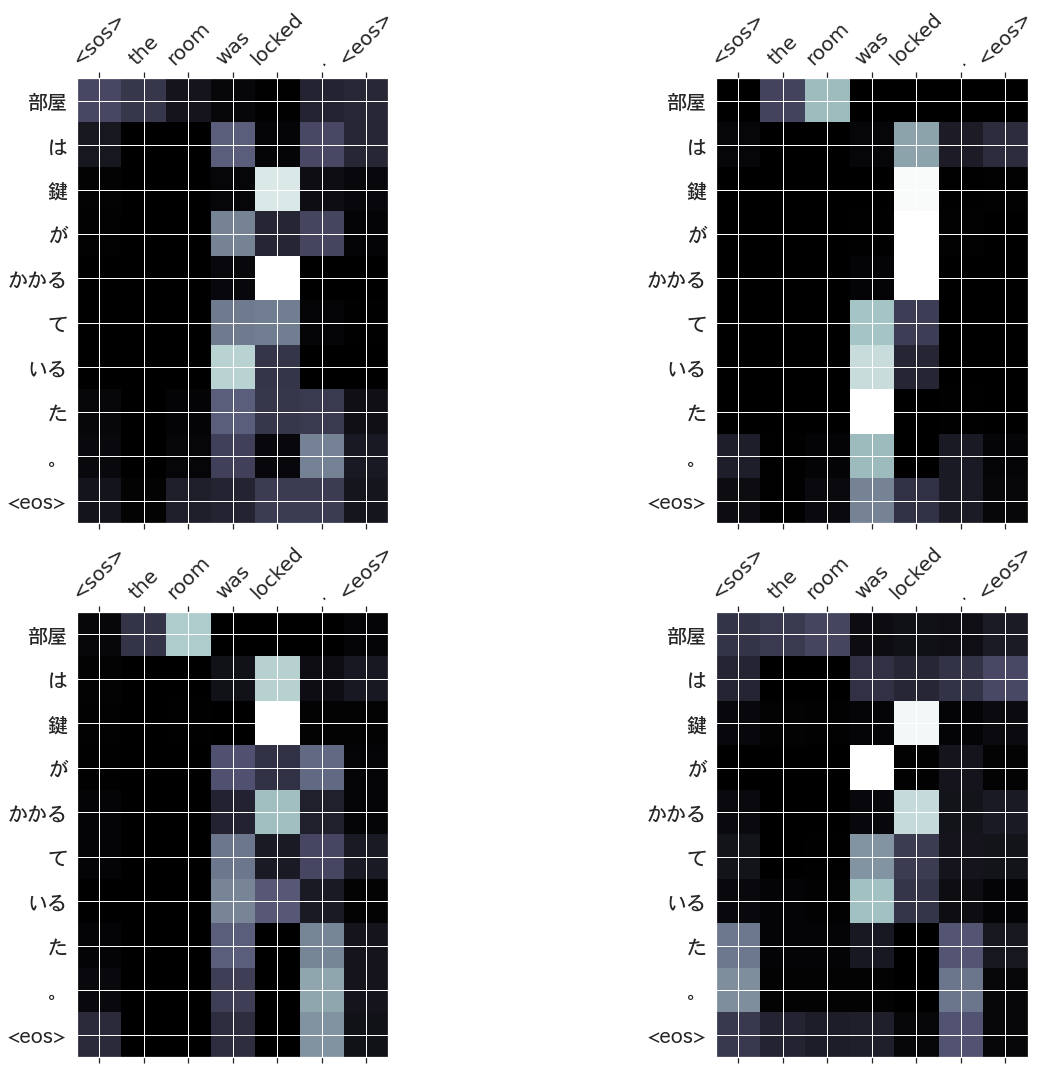

src      : she shut the door on her finger .
trg      : 彼女 は ドア に 指 を 挟む で しまう た 。
predicted: 彼女 は 指 に 戸 を 閉める た 。 <eos>
     blue: 90.36%


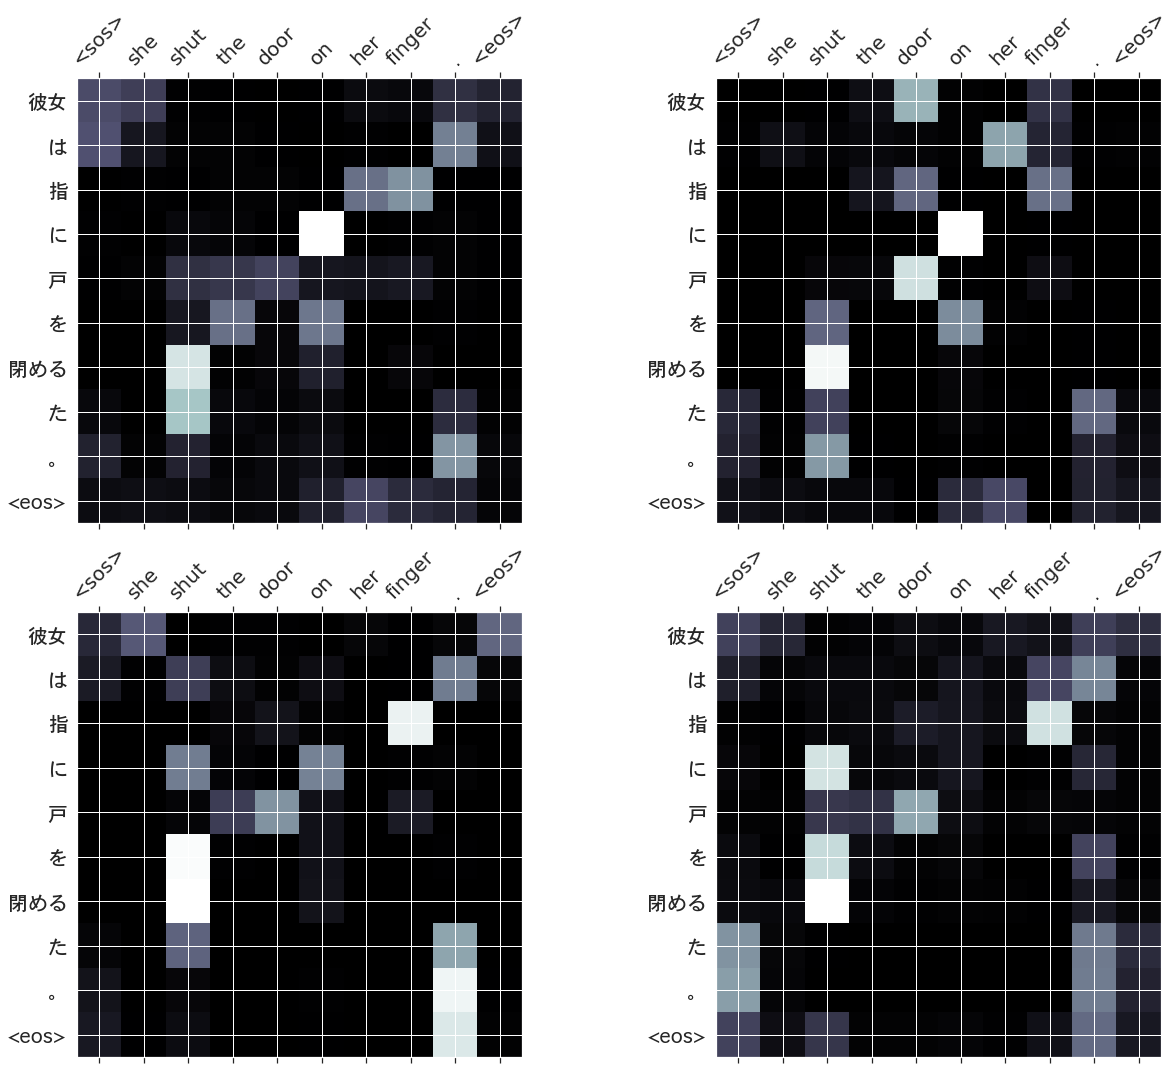

src      : i saw him go out .
trg      : 私 は 彼 が 出る て 行く の を 見る た 。
predicted: 私 は 彼 が 外出 する の を 見る た 。 <eos>
     blue: 92.35%


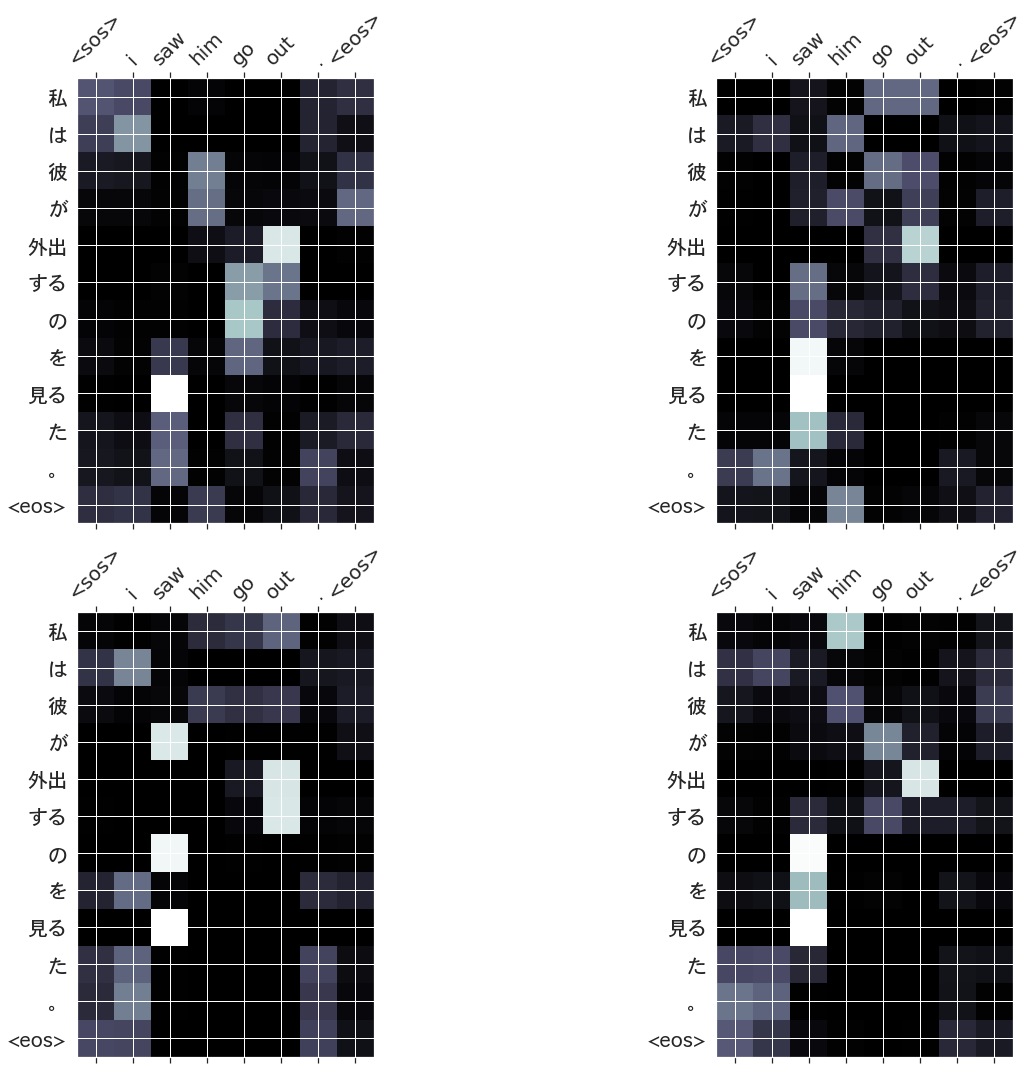

src      : in my opinion , he is wrong .
trg      : 私 の 考え で は 、 彼 は 間違う て いる 。
predicted: 私 の 意見 で は 、 彼 は 間違う て いる 。 <eos>
     blue: 90.36%


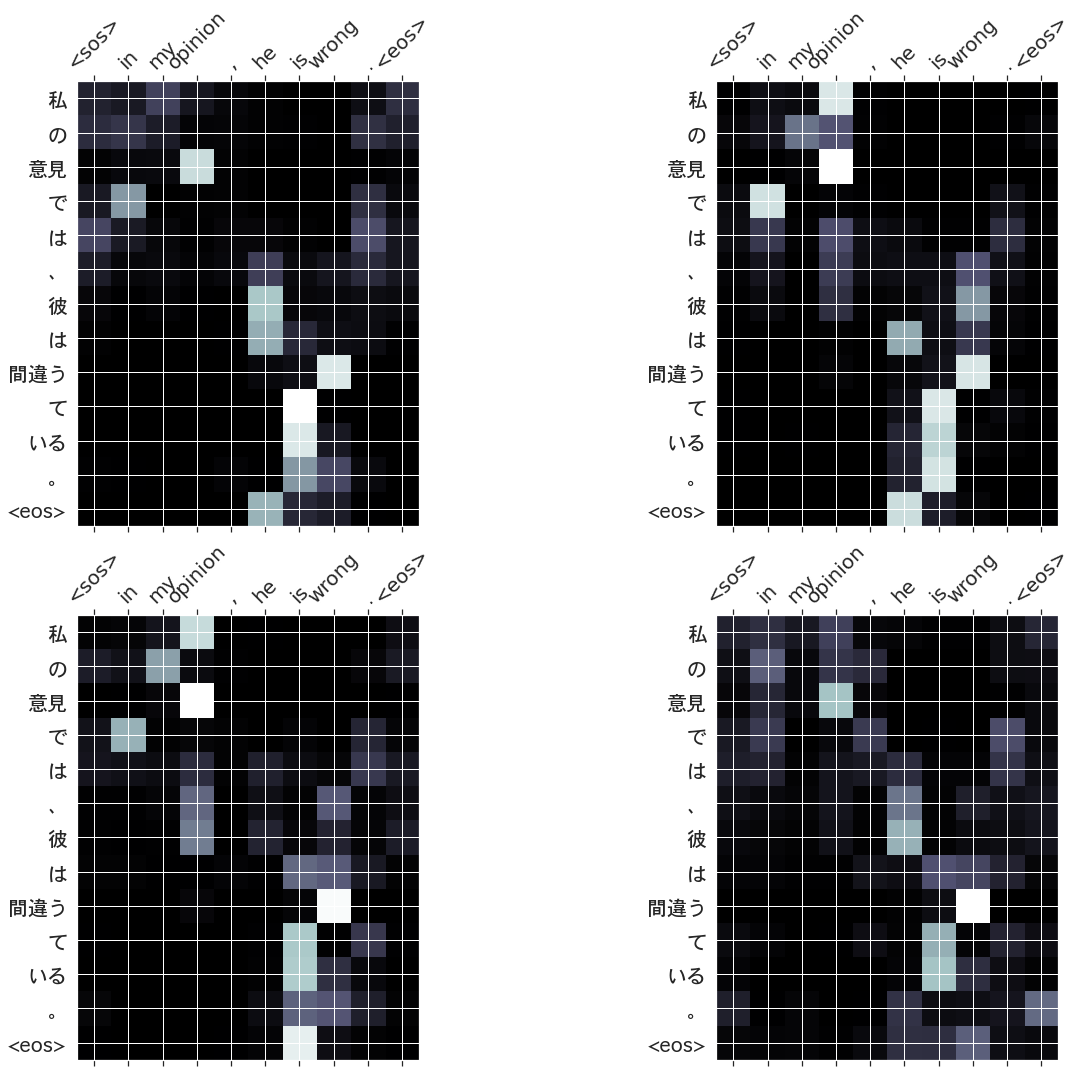

src      : birds fly in the sky .
trg      : 鳥 は 空 を 飛ぶ ます 。
predicted: 鳥 は 空 を 飛ぶ 。 <eos>
     blue: 95.54%


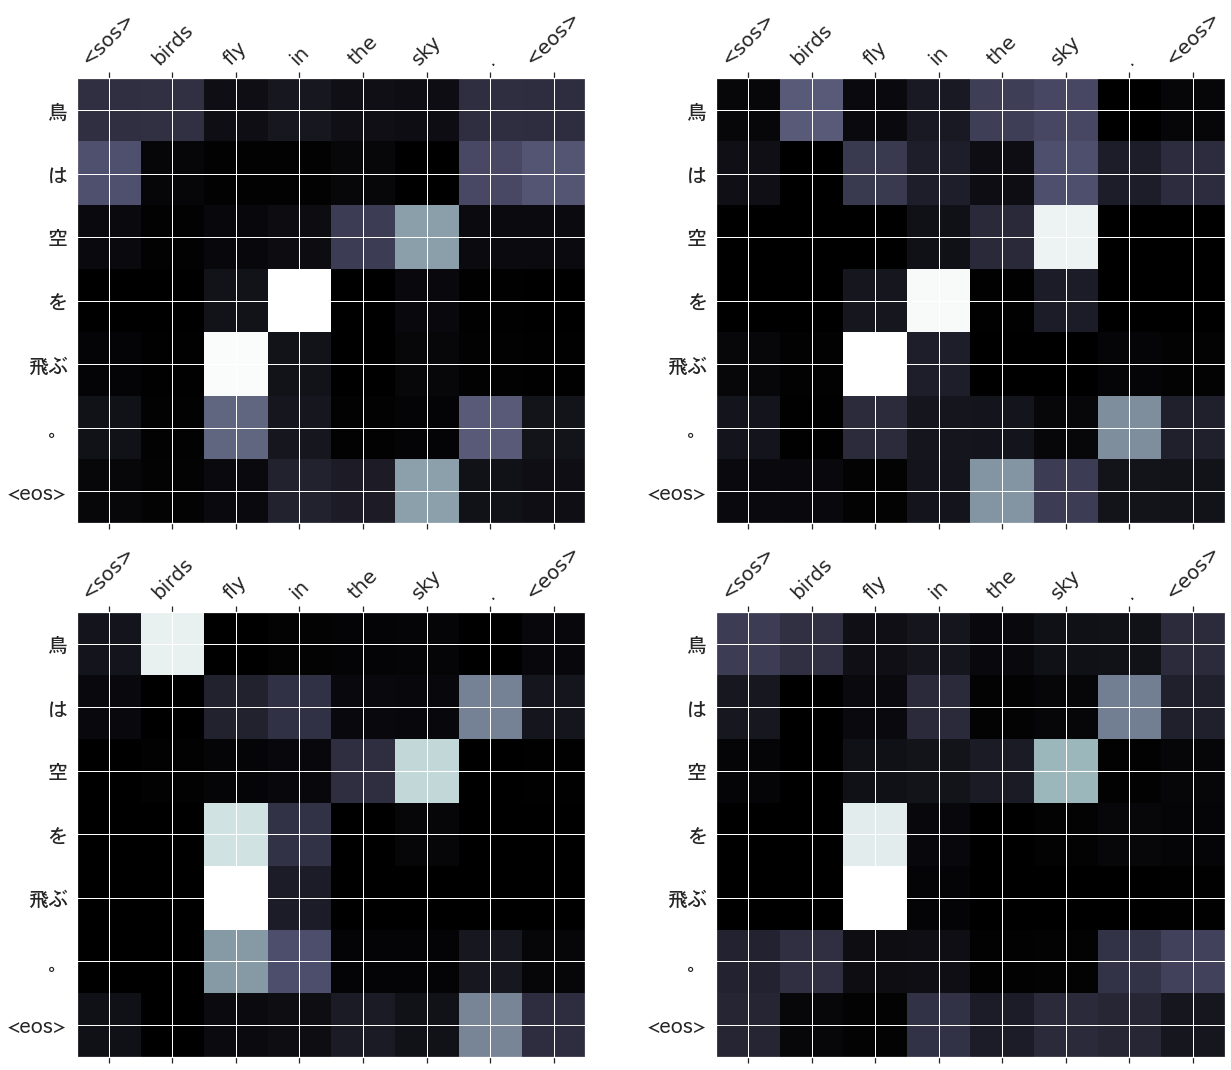

src      : nagano beat tokyo 2 to 3 .
trg      : 長野 は 東京 を ２ 対 ３ で 破る た 。
predicted: 長野 は ３ 対 ２ で 東京 を 負かす た 。 <eos>
     blue: 92.35%


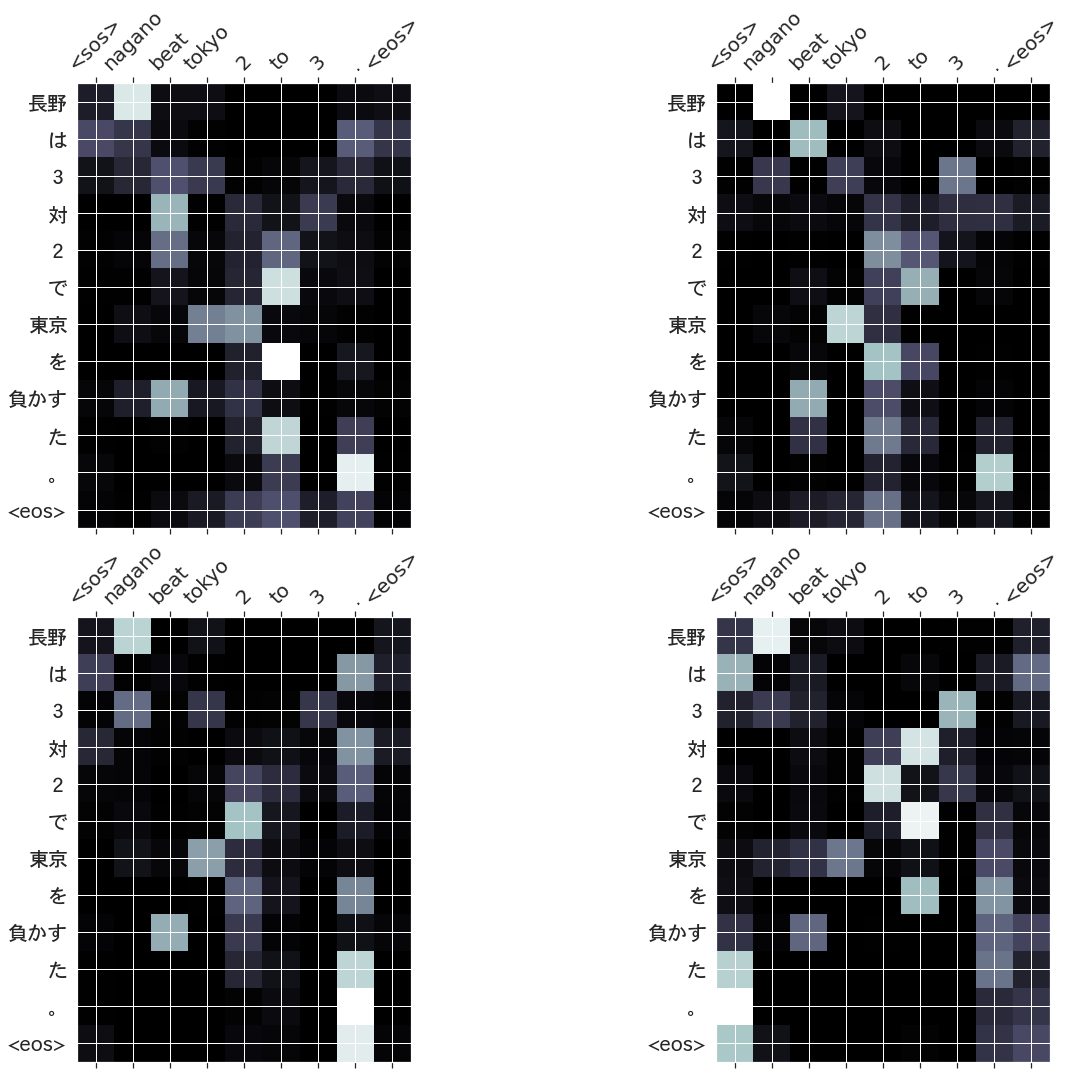

src      : the octopus is in the sea .
trg      : たこ は 海 に いる 。
predicted: <unk> は 海 に いる 。 <eos>
     blue: 90.36%


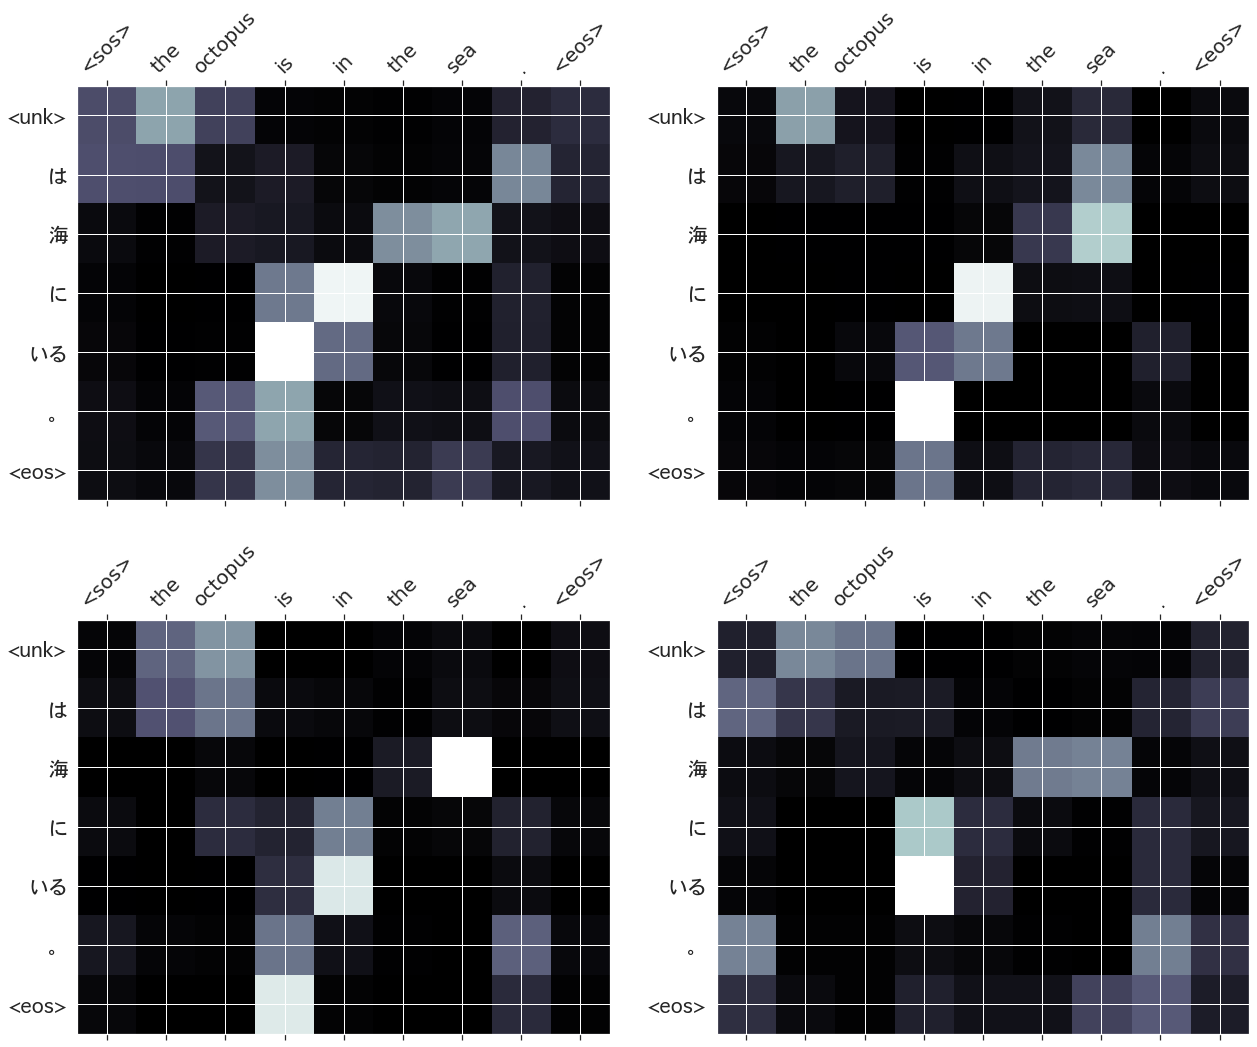

src      : i wanted him to go there .
trg      : 私 は 彼 に そこ へ 行く て ほしい た 。
predicted: 私 は 彼 に そこ へ 行く たい た 。 <eos>
     blue: 91.47%


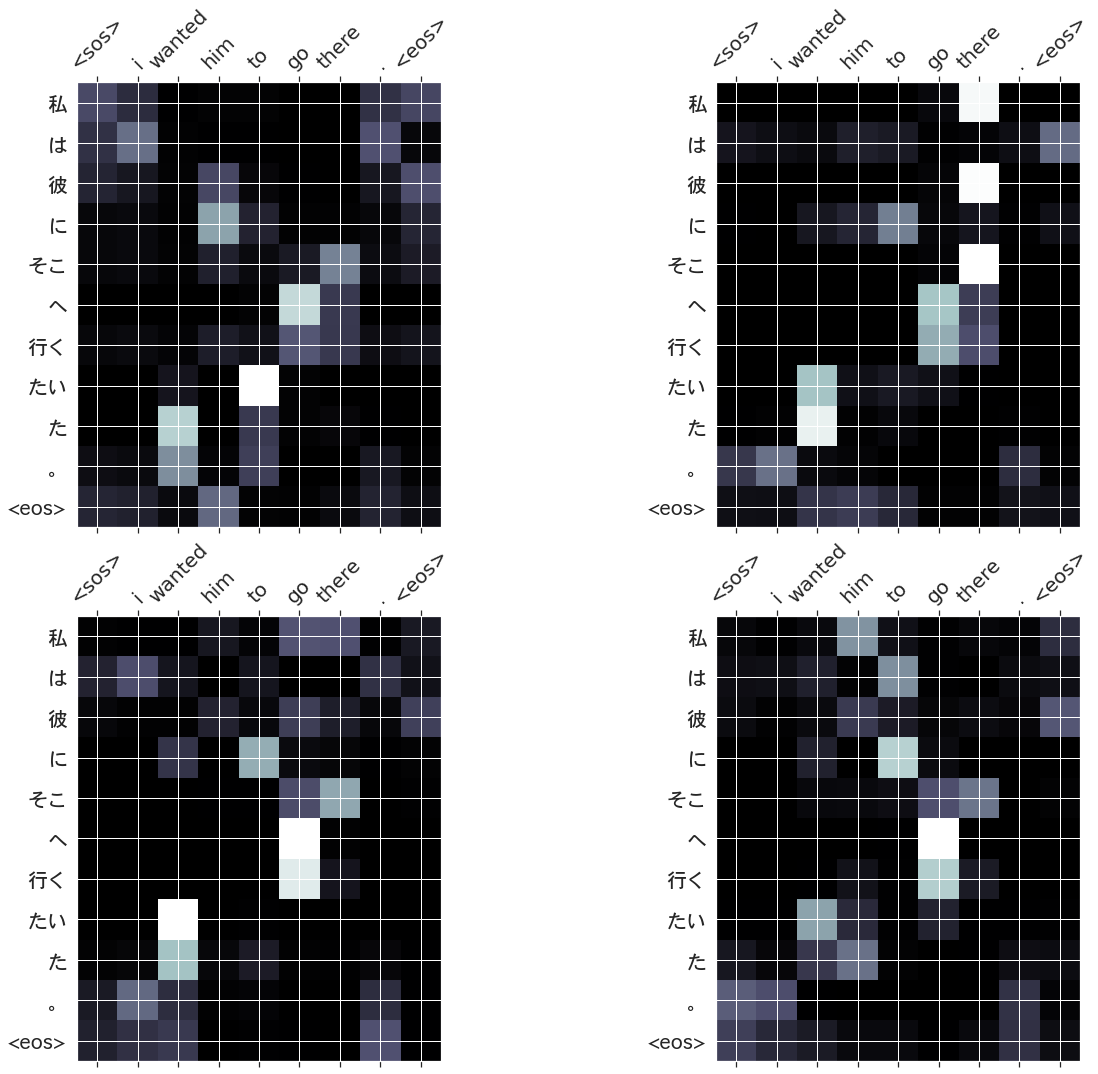

src      : needless to say , he did not win the prize .
trg      : 言うまでもない こと だ が 、 彼 は 賞 を 取れる ない た 。
predicted: 言うまでもない 、 彼 は 賞 を 得る ない た 。 <eos>
     blue: 91.47%


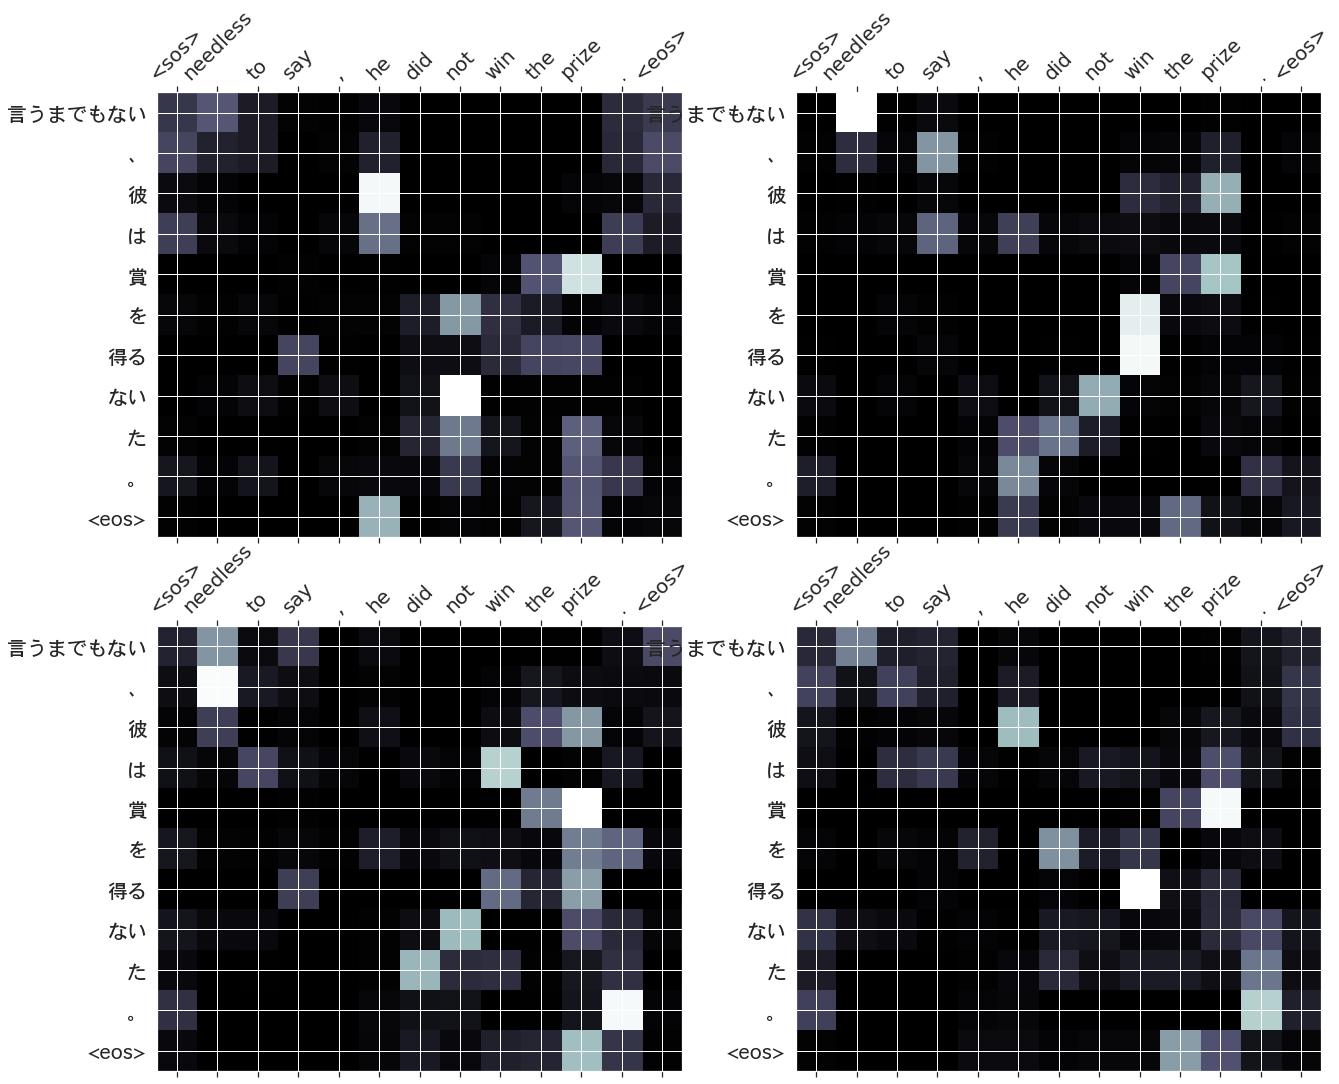

src      : are there any pens in the car ?
trg      : 車 の 中 に 何 本 か の ペン が ある ます か 。
predicted: 車 の 中 に ペン が ある ます か 。 <eos>
     blue: 91.47%


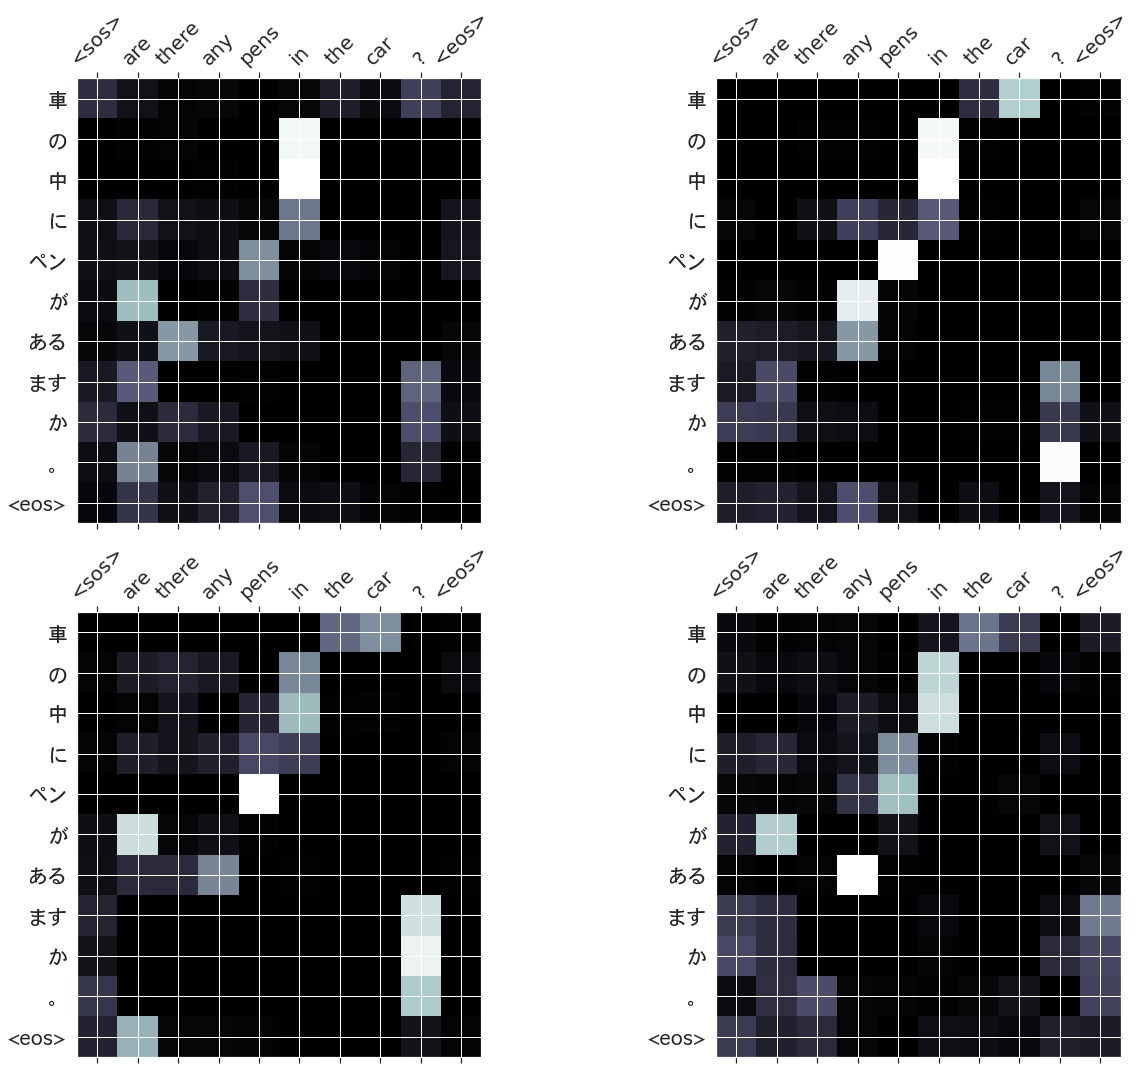

src      : do n't speak with your mouth full .
trg      : 口 に 食物 を いっぱい 入れる て しゃべる な 。
predicted: 口 に 物 を 入れる て 話す な 。 <eos>
     blue: 93.91%


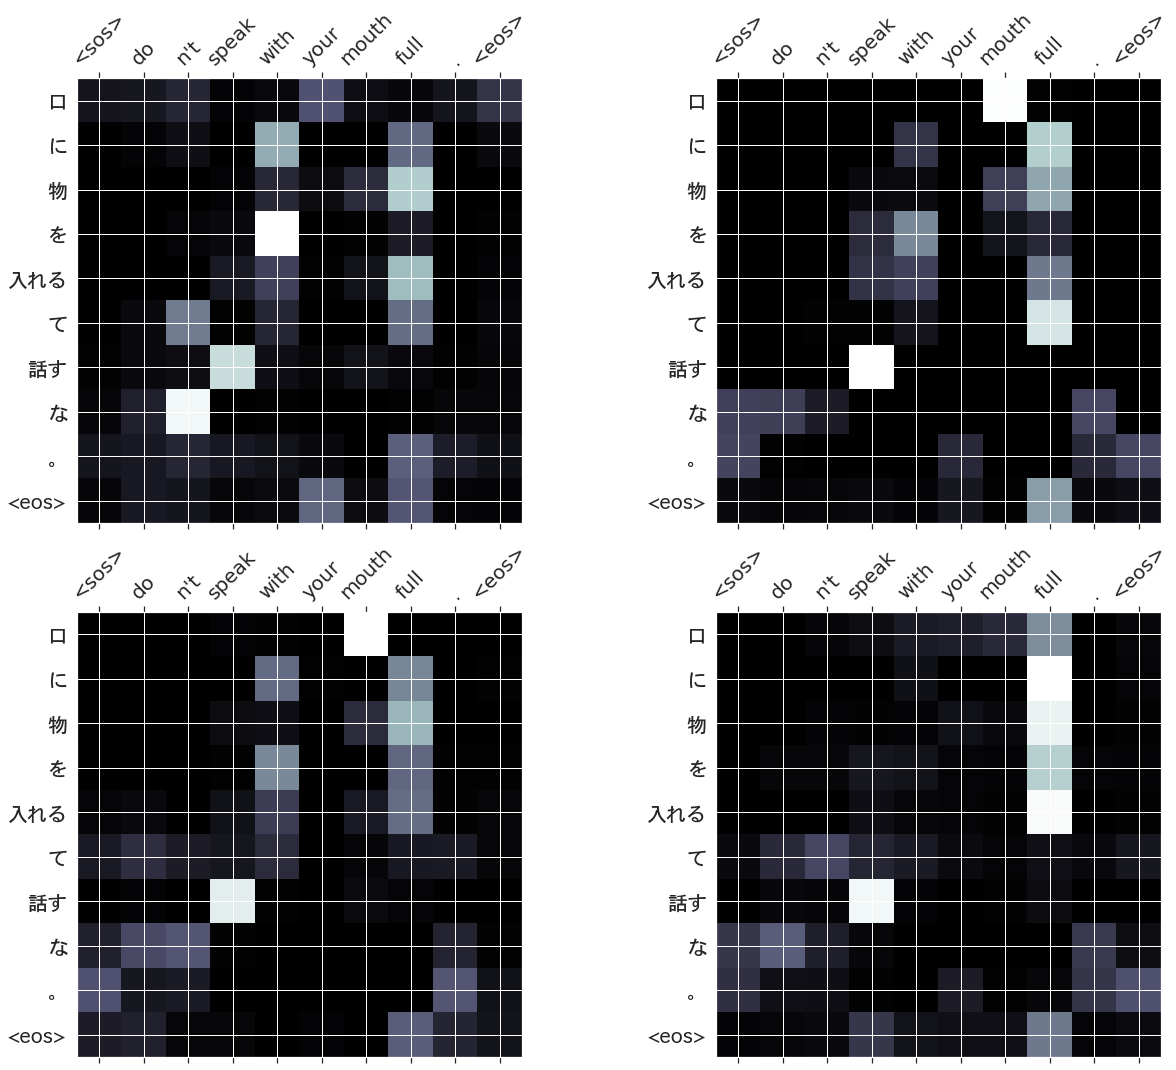

src      : she lived there for years .
trg      : 彼女 は そこ に 何 年間 も 住む で いる た 。
predicted: 彼女 は そこ に 何 年 も 住む で いる た 。 <eos>
     blue: 90.36%


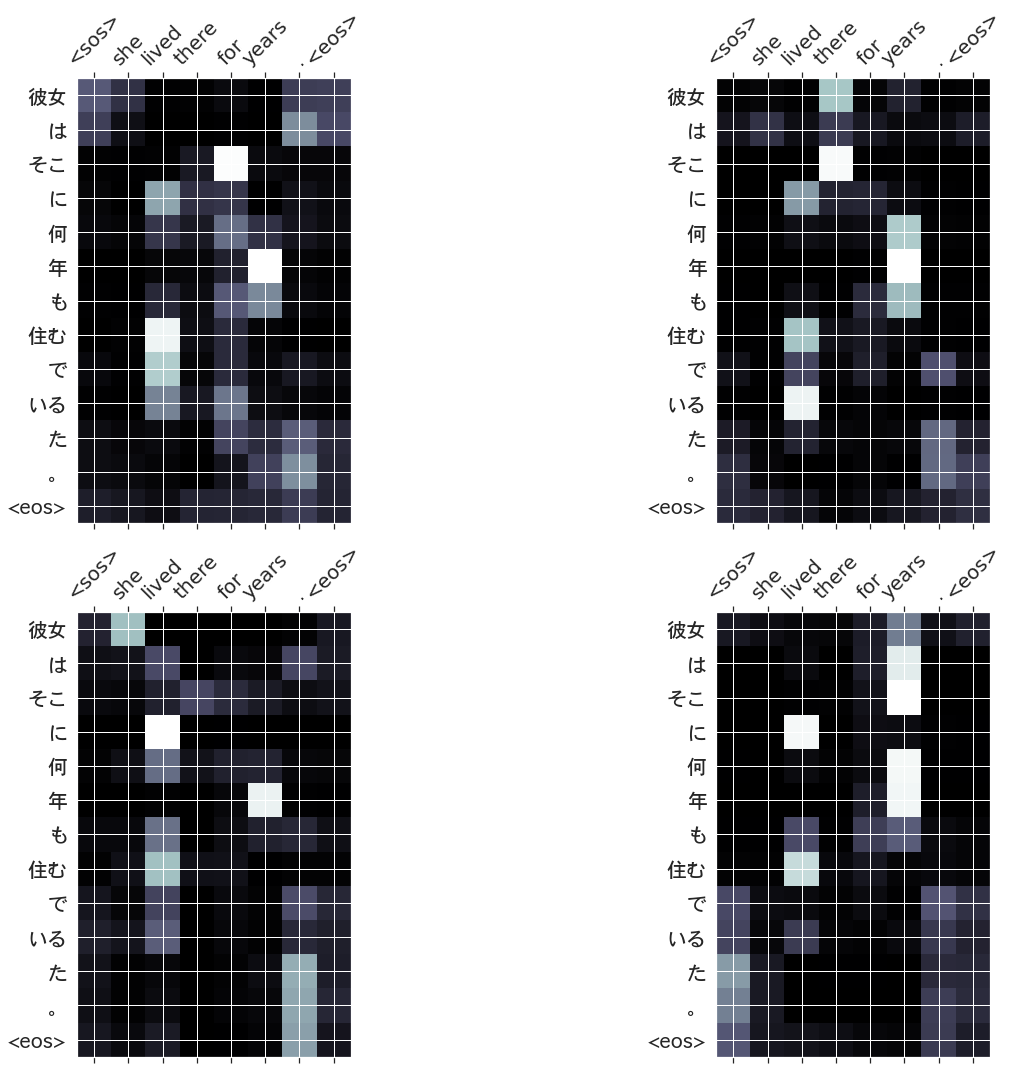

src      : how big he is !
trg      : 彼 は なんて 大きい の だ う 。
predicted: 彼 は なんて 大きい ん だ う 。 <eos>
     blue: 93.06%


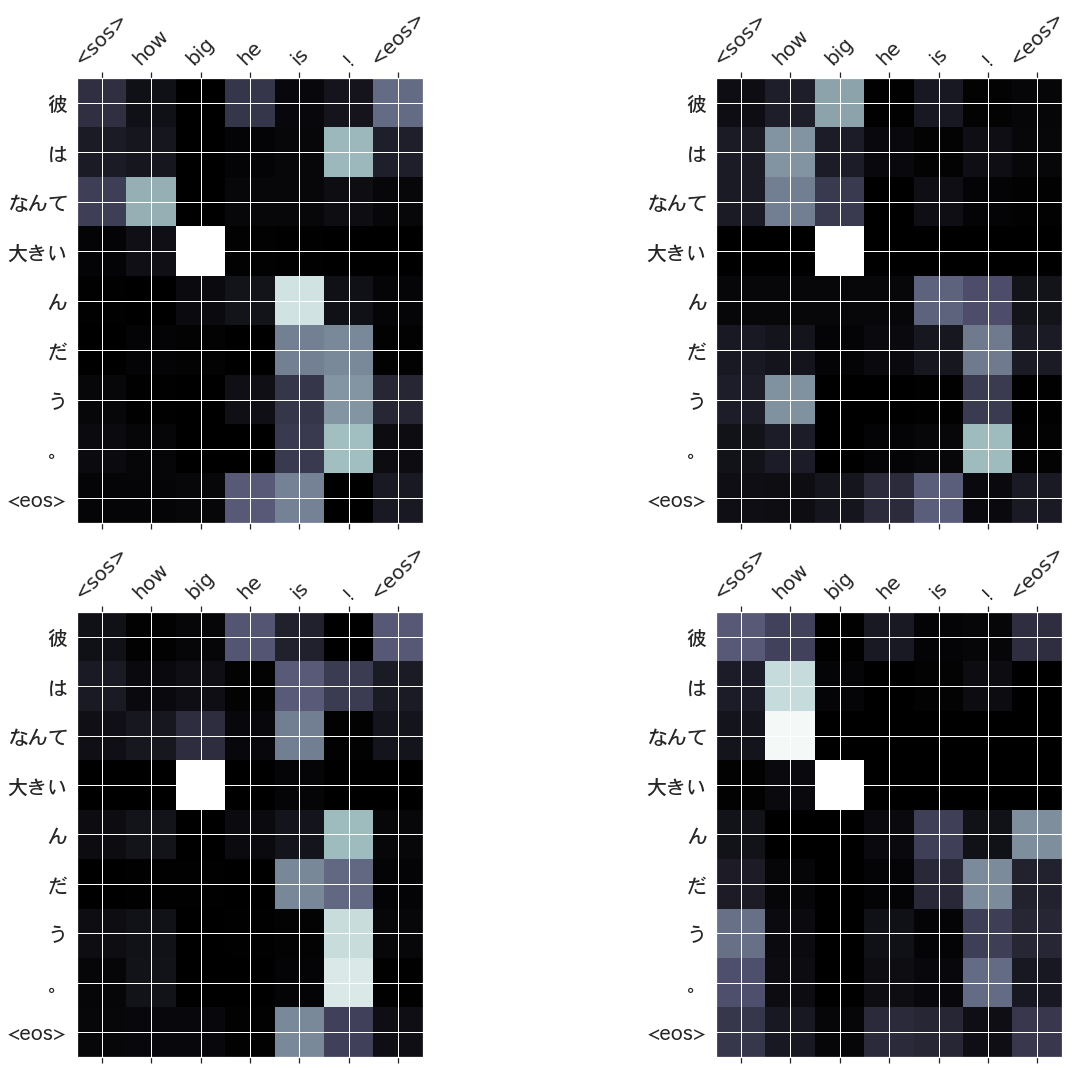

src      : his hair style is behind the time .
trg      : 彼 の 髪型 は 時代遅れ だ 。
predicted: 彼 の 髪型 は 時代遅れ だ 。 <eos>
     blue: 91.93%


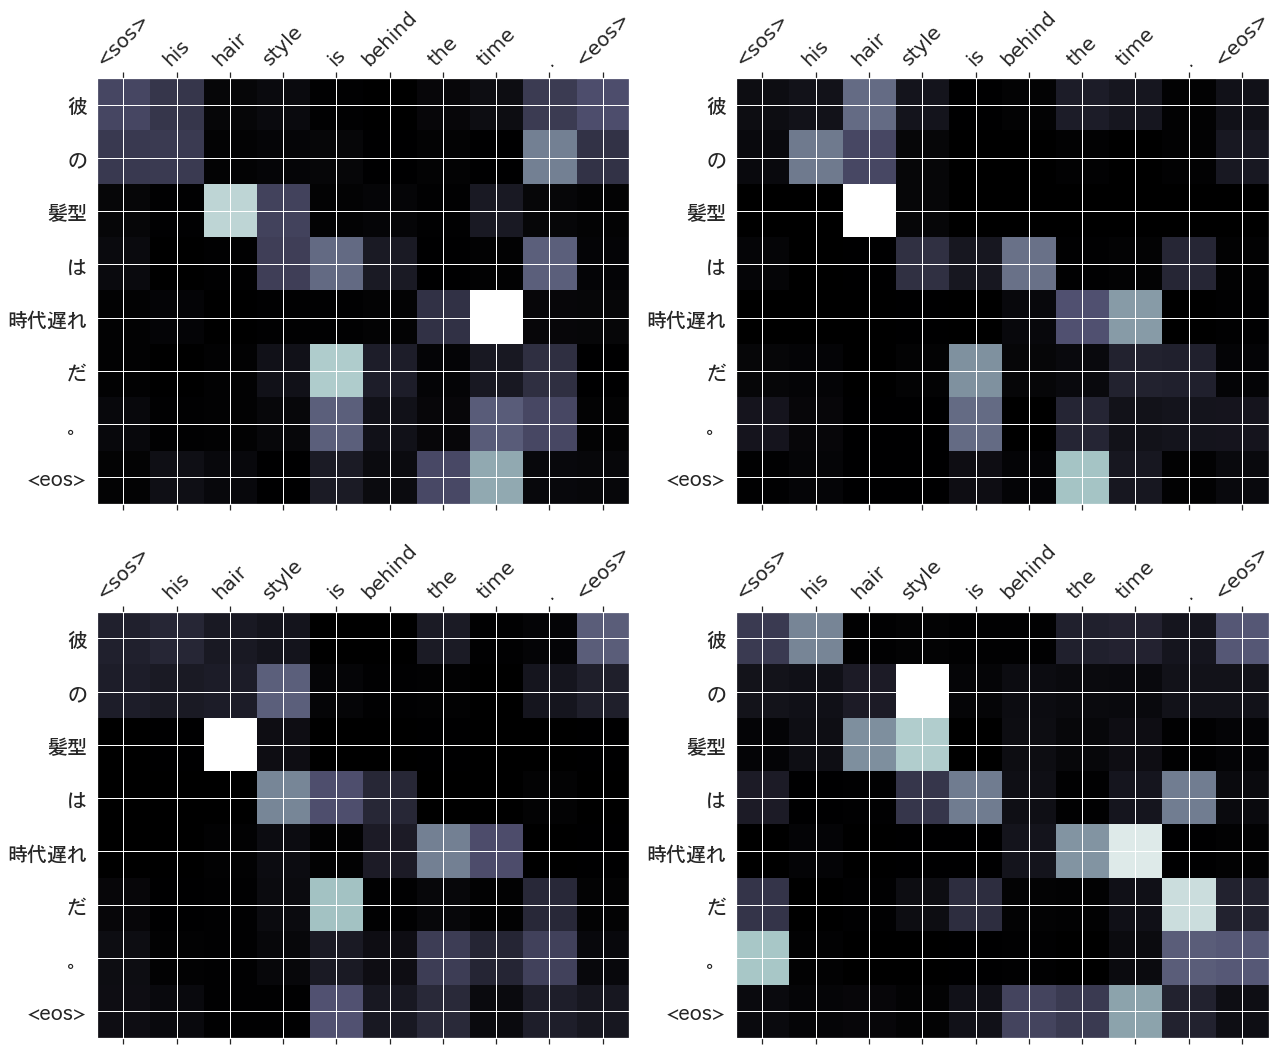

src      : nagano beat tokyo 2 to 3 .
trg      : 長野 は 東京 を ２ 対 ３ で 破る た 。
predicted: 長野 は ３ 対 ２ で 東京 を 負かす た 。 <eos>
     blue: 92.35%


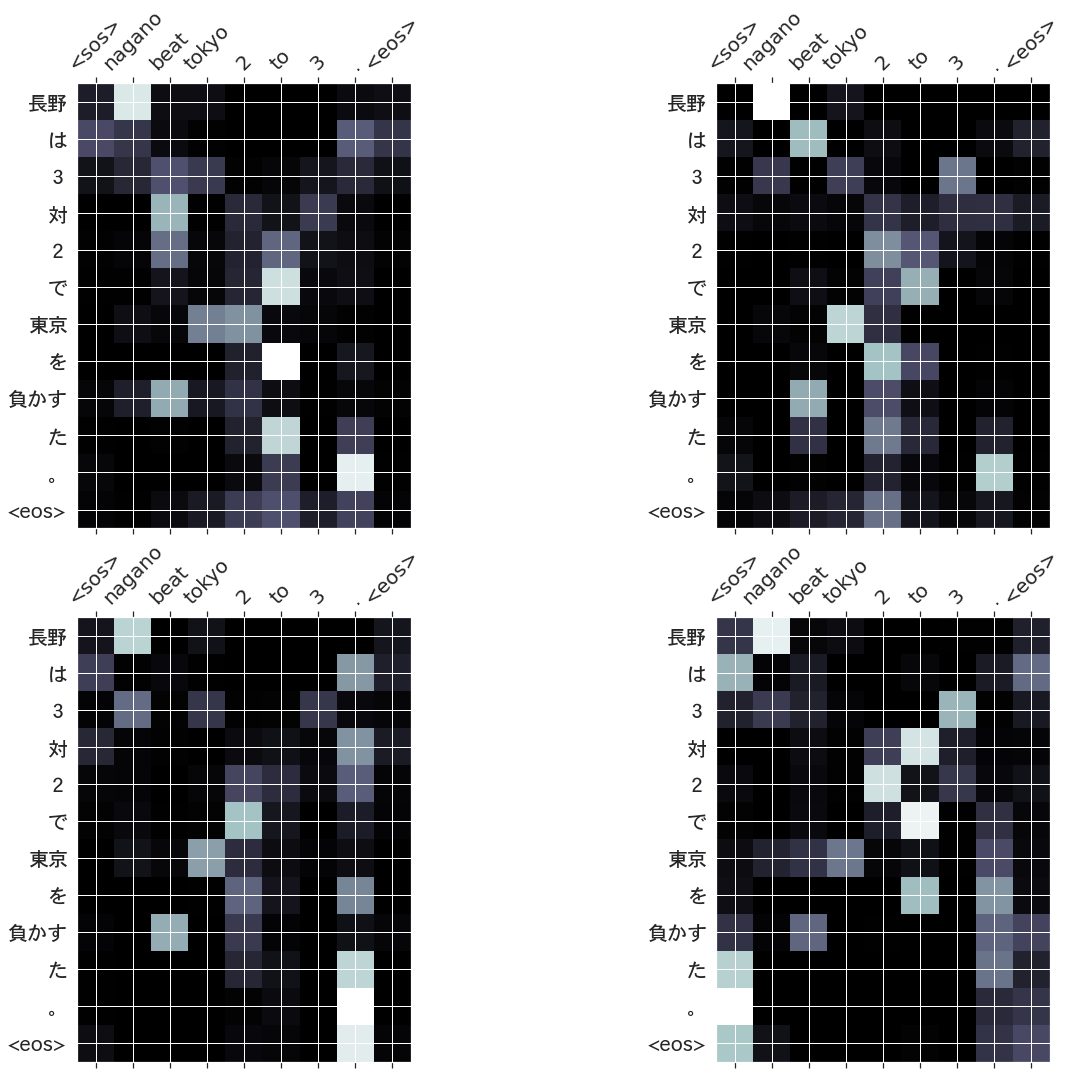

src      : my brother is good at playing tennis .
trg      : 私 の 兄 は テニス を する の が 得意 だ 。
predicted: 私 の 兄 は テニス が 上手 です 。 <eos>
     blue: 90.36%


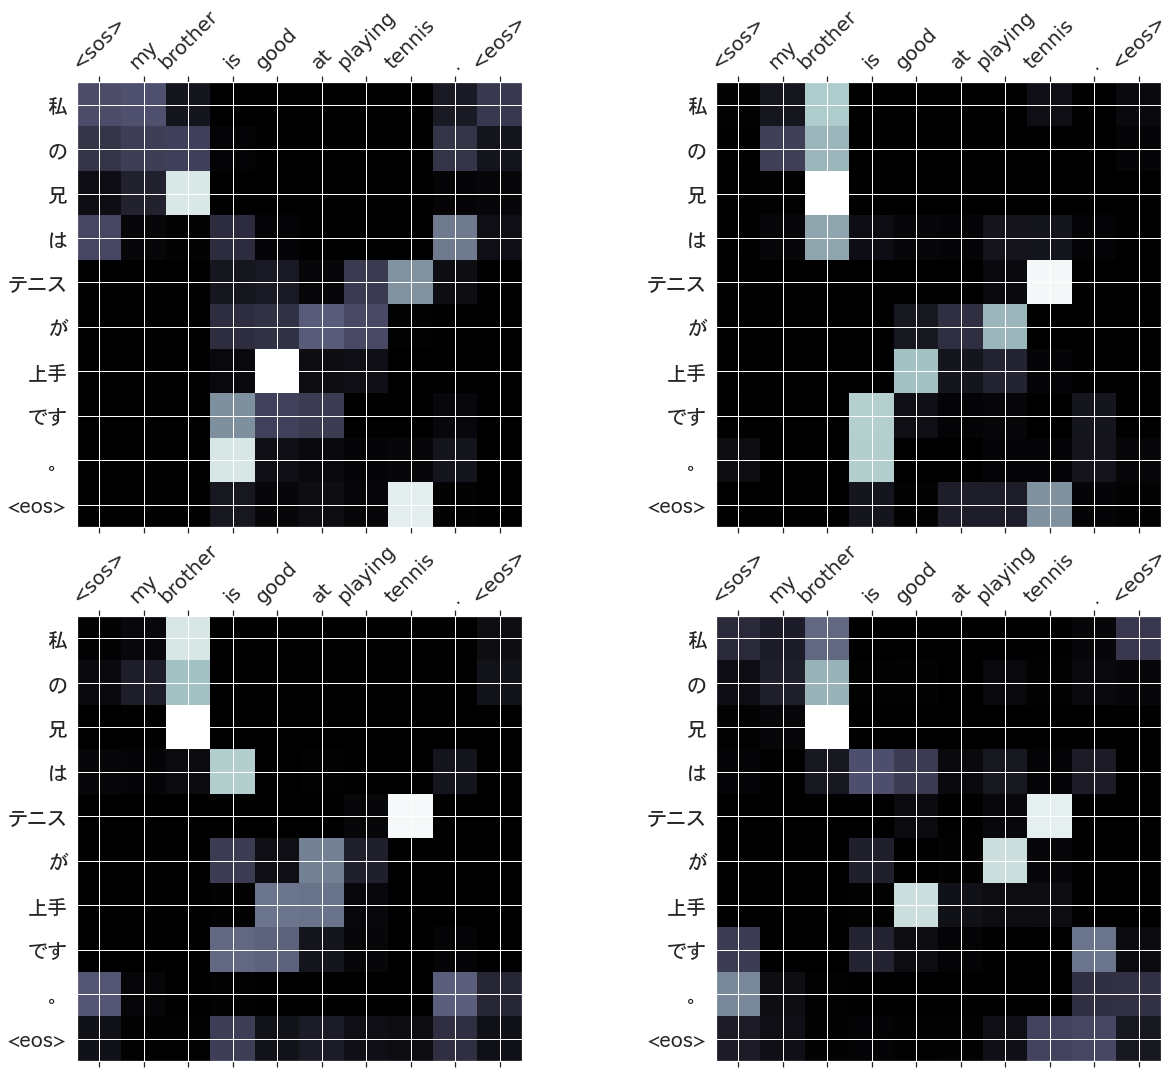

src      : he warmed his hands .
trg      : 彼 は 手 を 温める た 。
predicted: 彼 は 手 を 暖かい する た 。 <eos>
     blue: 93.06%


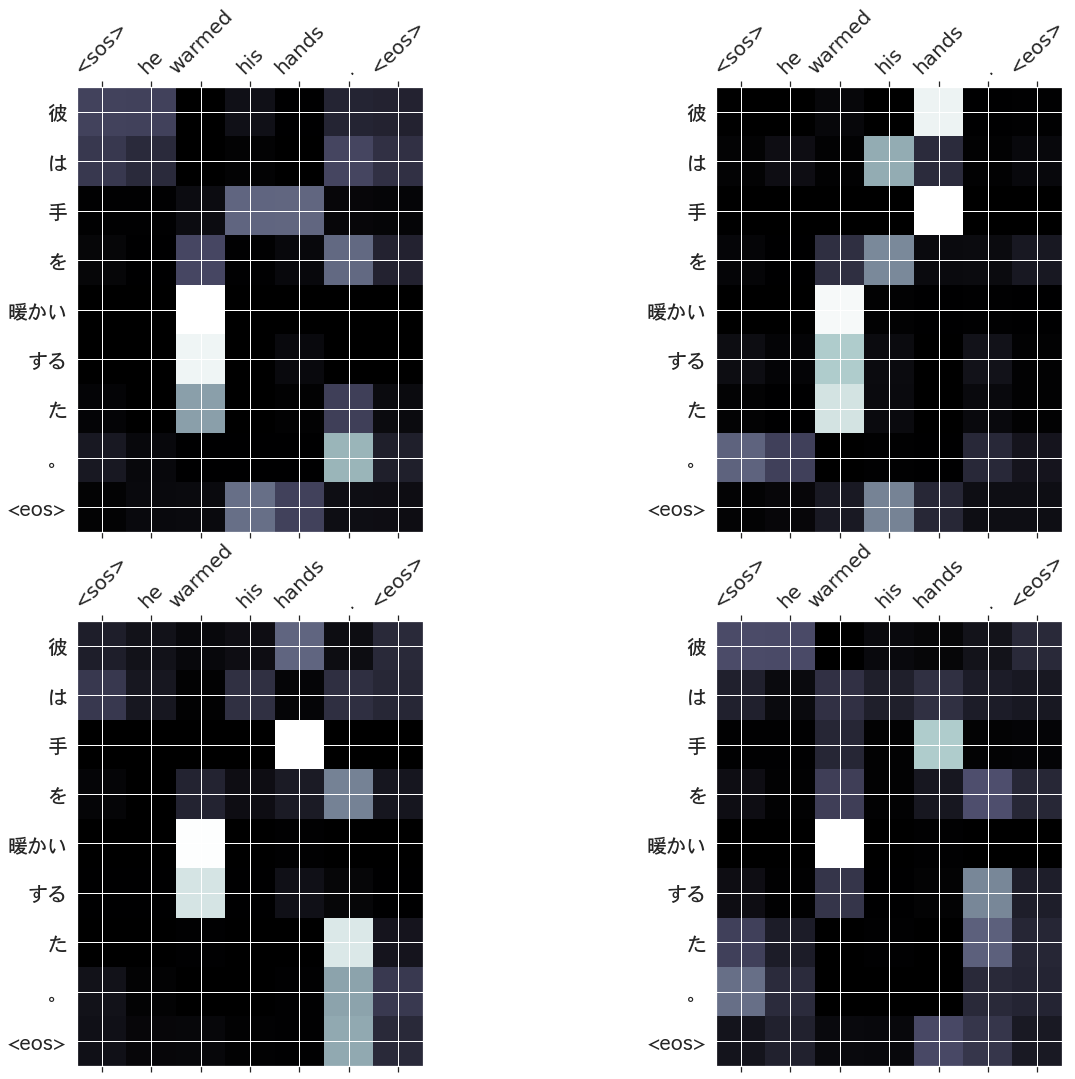

src      : he is a man of noble blood .
trg      : 彼 は 高貴 だ 家柄 の 人 です 。
predicted: 彼 は 高貴 だ 生まれ の 人 だ 。 <eos>
     blue: 90.36%


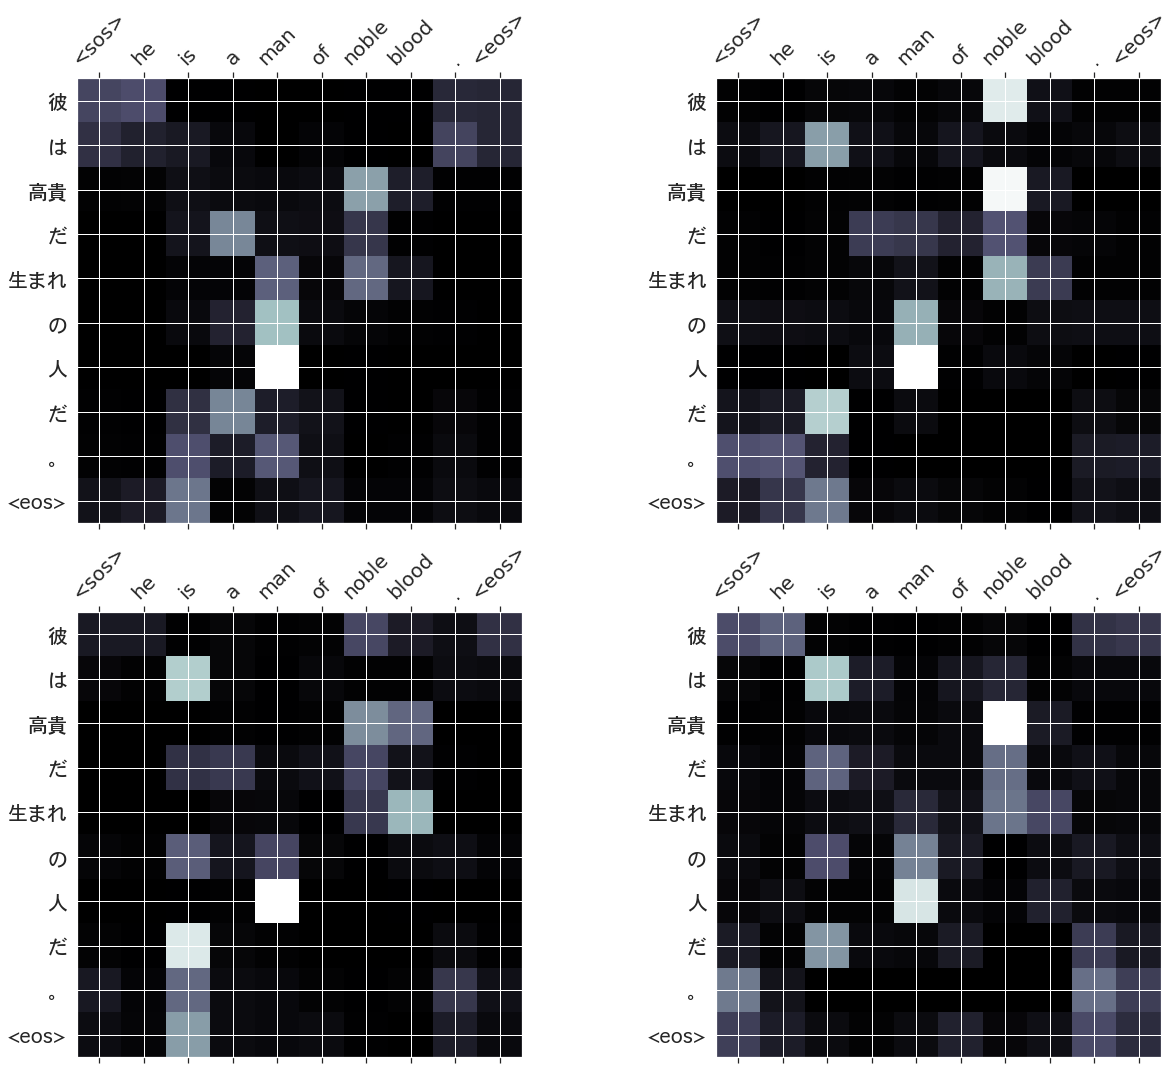

src      : they sat down by the fire .
trg      : 彼ら は たき火 の 側 に 座る ます た 。
predicted: 彼ら は 火 の 中 に 座る た 。 <eos>
     blue: 90.36%


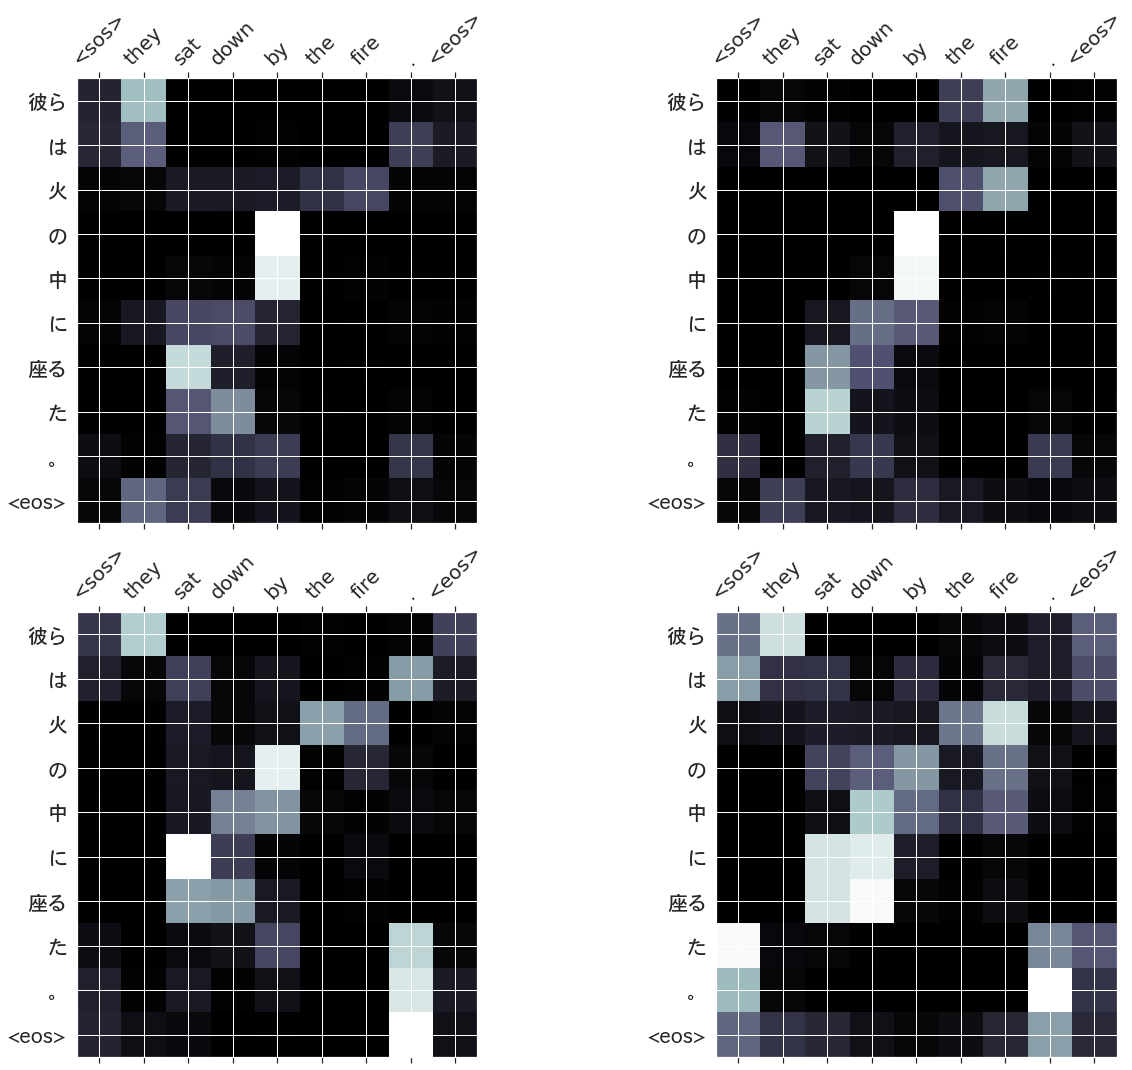

src      : what happened to him ?
trg      : 彼 に 何 が 起こる た の です か 。
predicted: 彼 は 何 が 起こる た の です か 。 <eos>
     blue: 91.47%


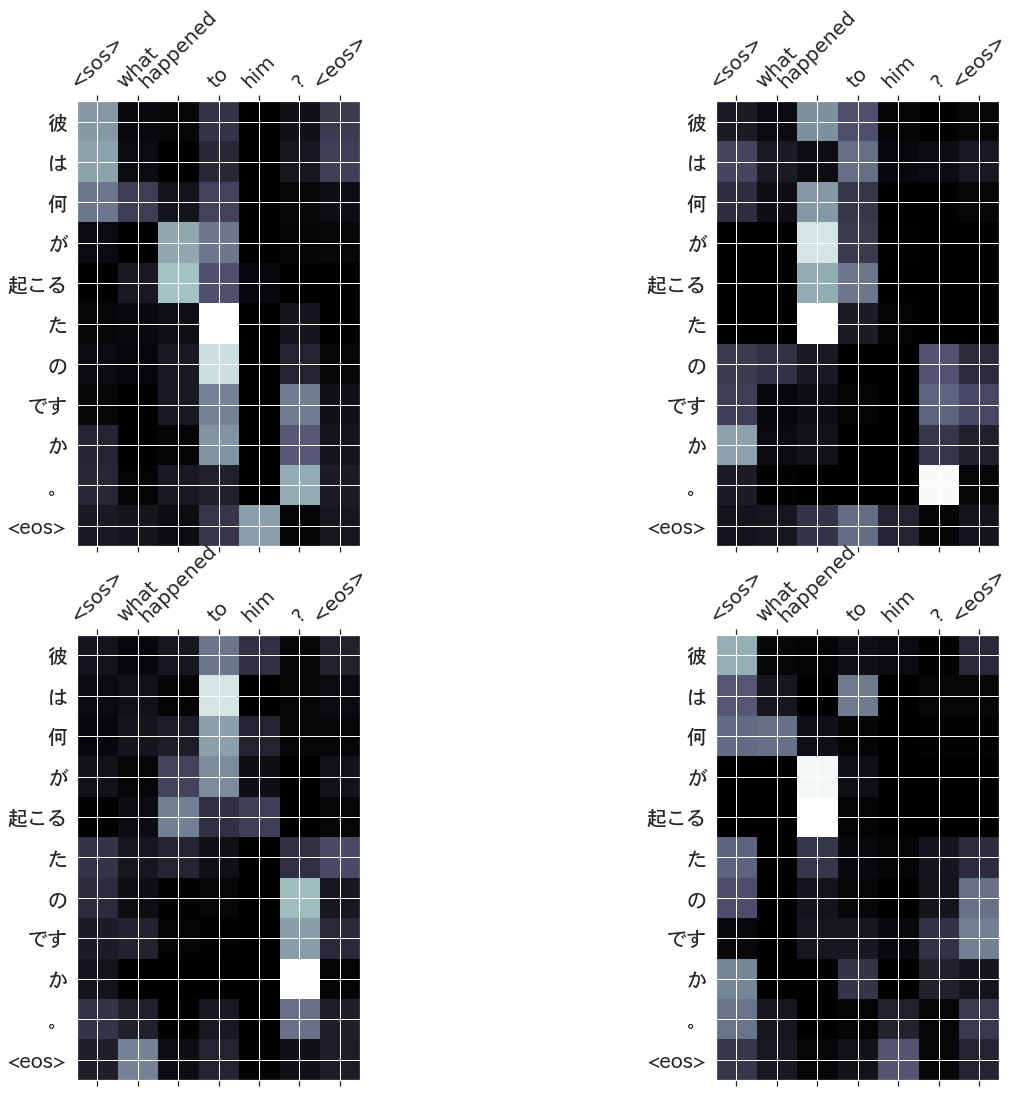

src      : we thought it natural that he should get excited .
trg      : 私 たち は 彼 が 興奮 する の は 当然 だ と 思う た 。
predicted: 彼 が 興奮 する の は 当然 だ と 思う た 。 <eos>
     blue: 90.36%


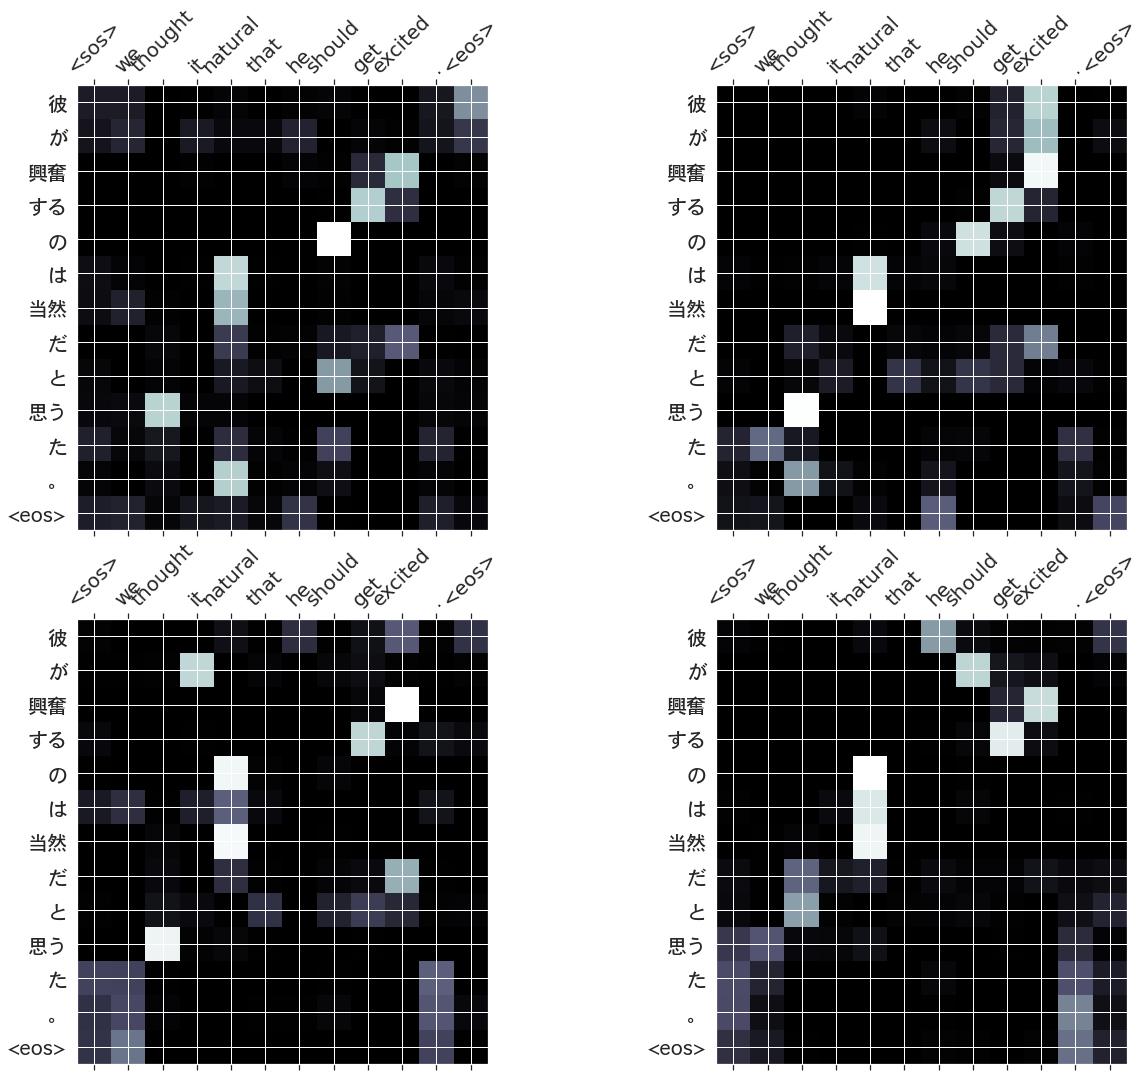

src      : there is a television in my room .
trg      : 私 の 部屋 に は テレビ が ある 。
predicted: 私 の 部屋 に は テレビ が ある 。 <eos>
     blue: 90.36%


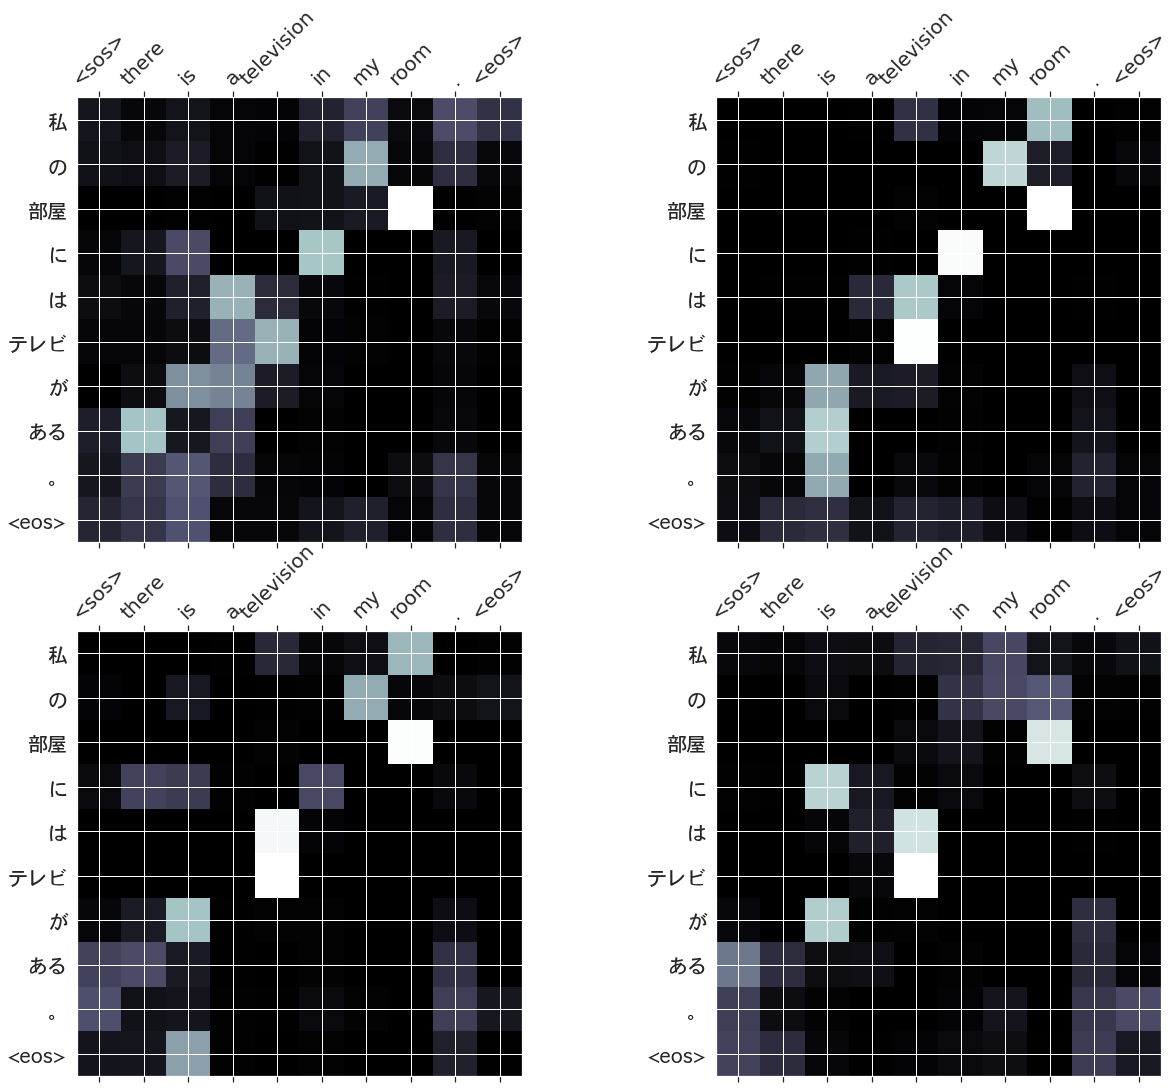

src      : he took a taxi to the station .
trg      : 彼 は 駅 まで タクシー に 乗る た 。
predicted: 彼 は 駅 まで タクシー に 乗る た 。 <eos>
     blue: 90.36%


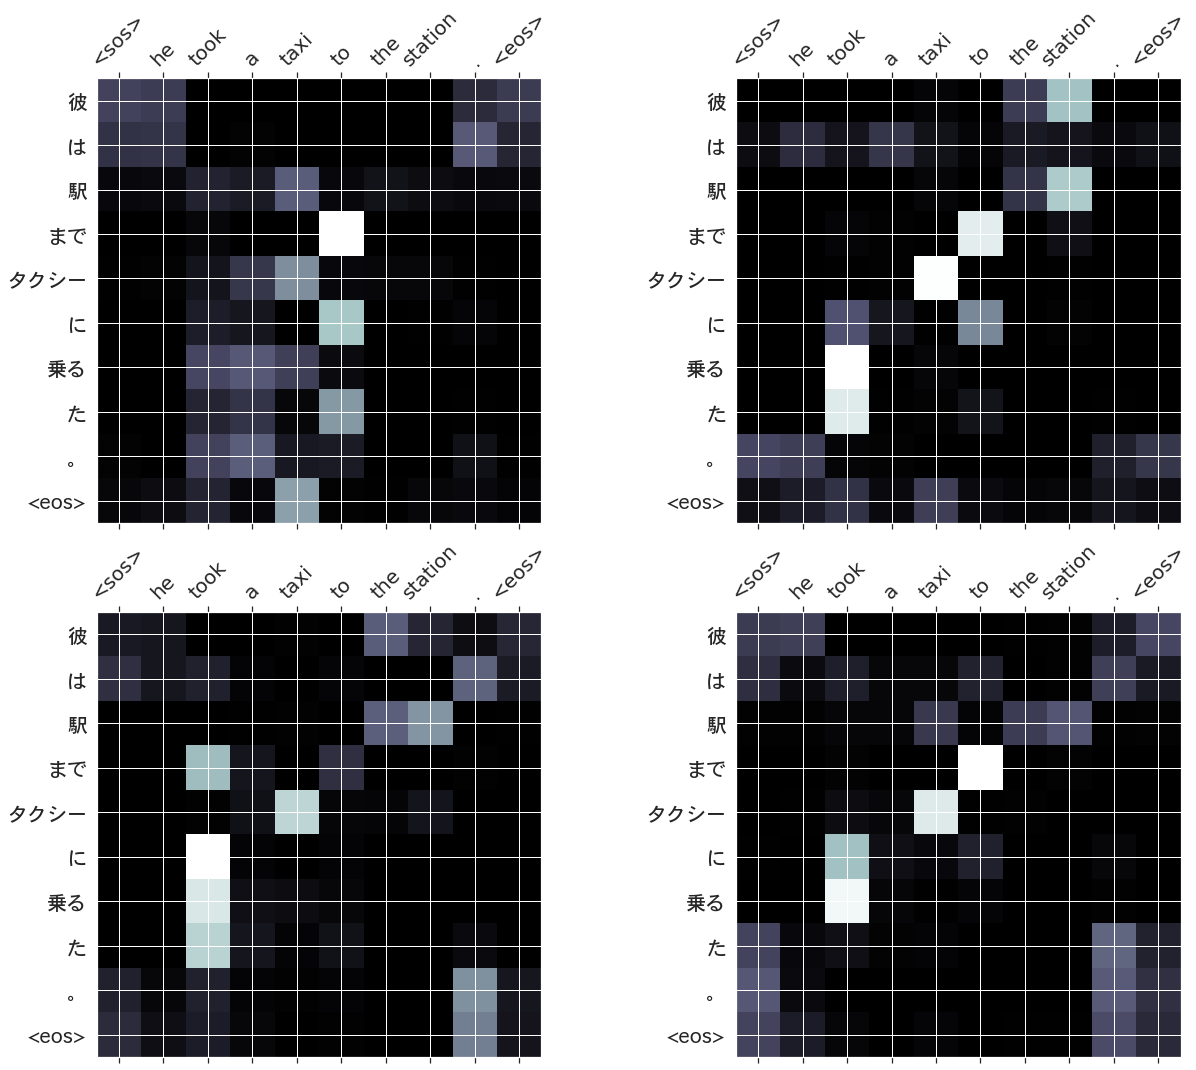

src      : he crossed over the sea .
trg      : 彼 は 海 を 渡る た 。
predicted: 彼 は 海 を 越える て 渡る た 。 <eos>
     blue: 90.36%


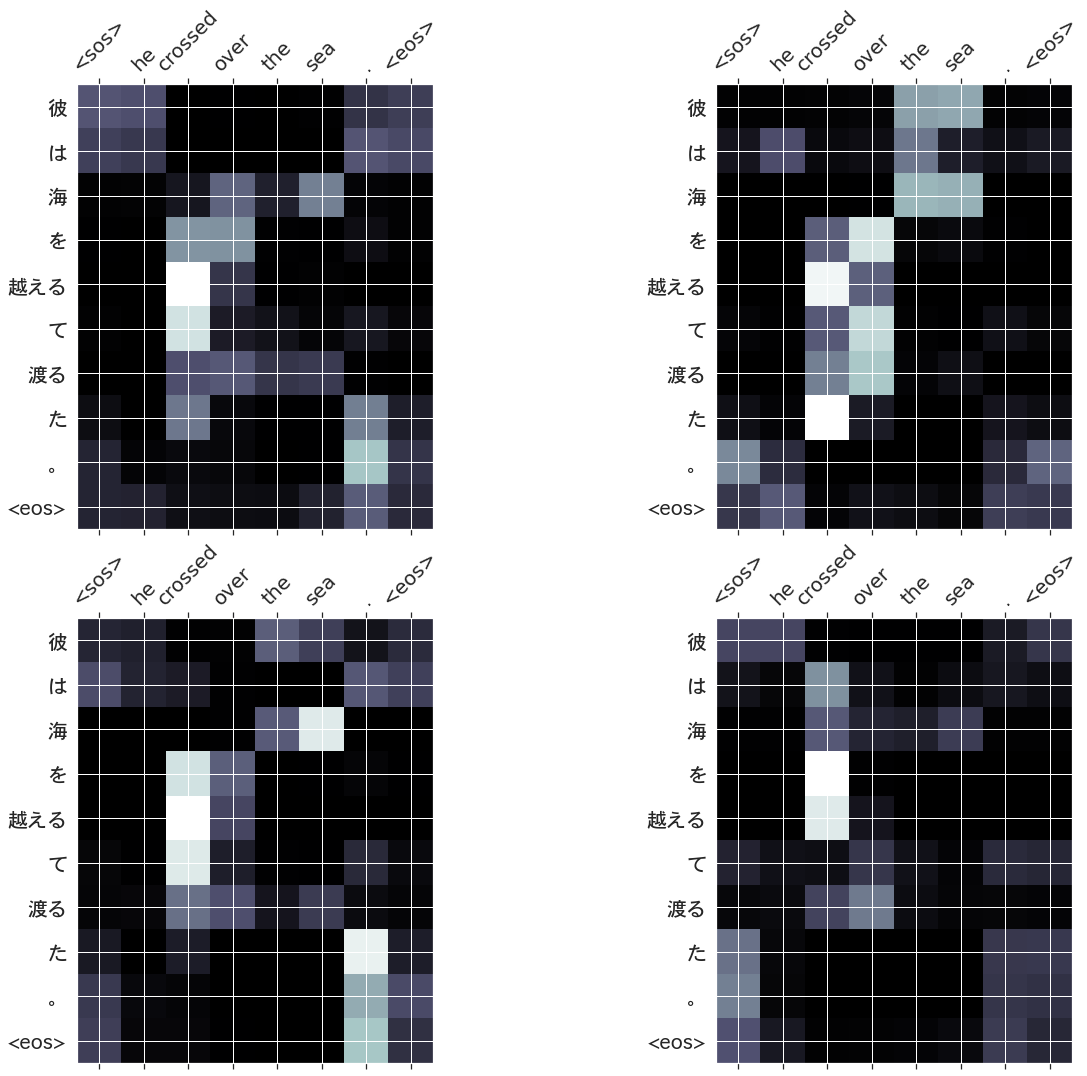

src      : he 's always looking at you .
trg      : 彼 は いつも 君 を 見る て いる 。
predicted: 彼 は いつも 君 を 見つめる て いる 。 <eos>
     blue: 90.36%


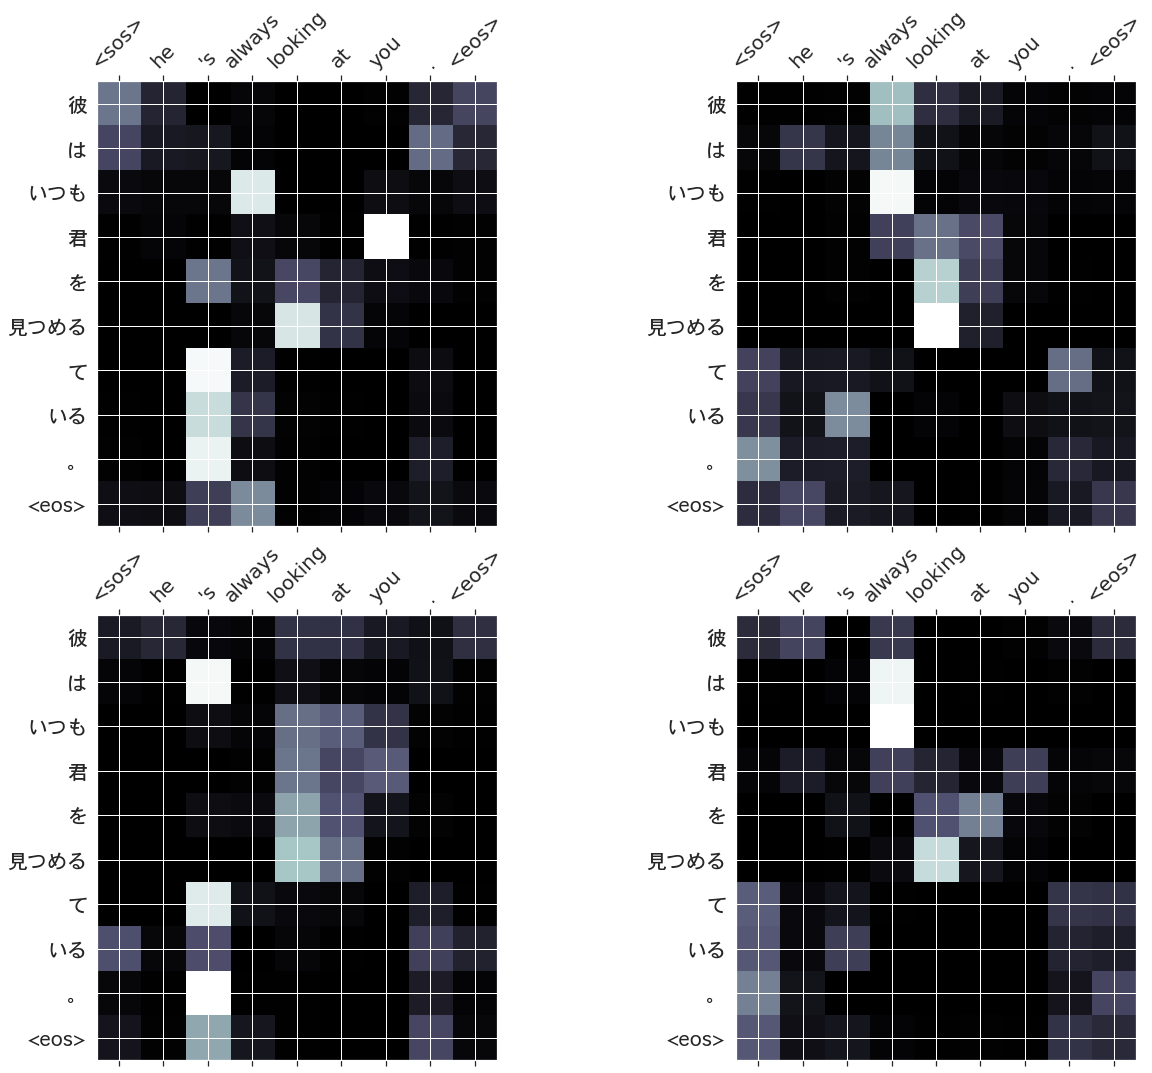

src      : the school is located on a hill .
trg      : その 学校 は 丘 の 上 に ある 。
predicted: その 学校 は 丘 の 上 に ある 。 <eos>
     blue: 90.36%


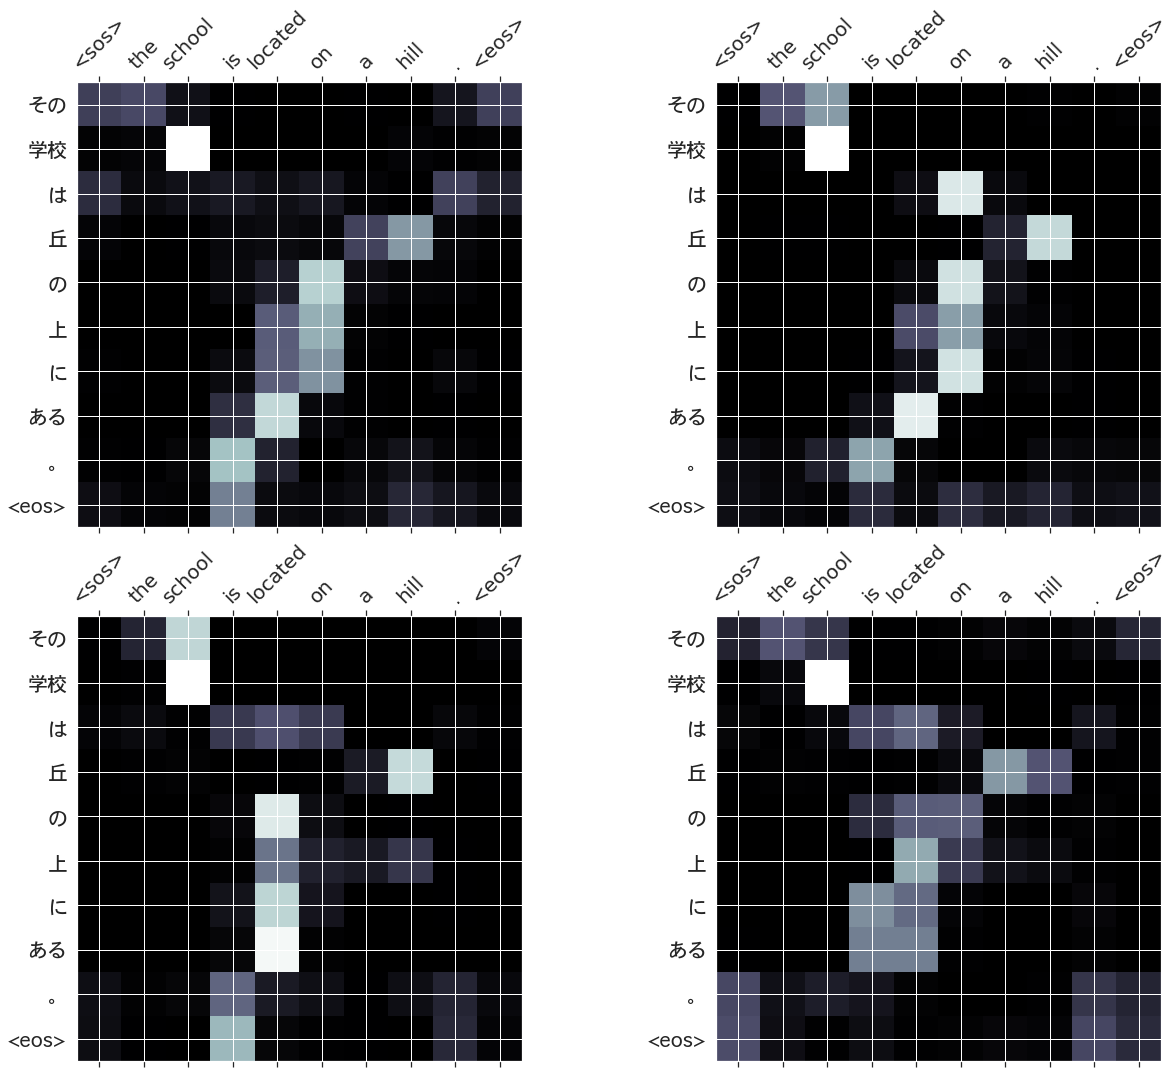

src      : are there any pens in the car ?
trg      : 車 の 中 に 何 本 か の ペン が ある ます か 。
predicted: 車 の 中 に ペン が ある ます か 。 <eos>
     blue: 91.47%


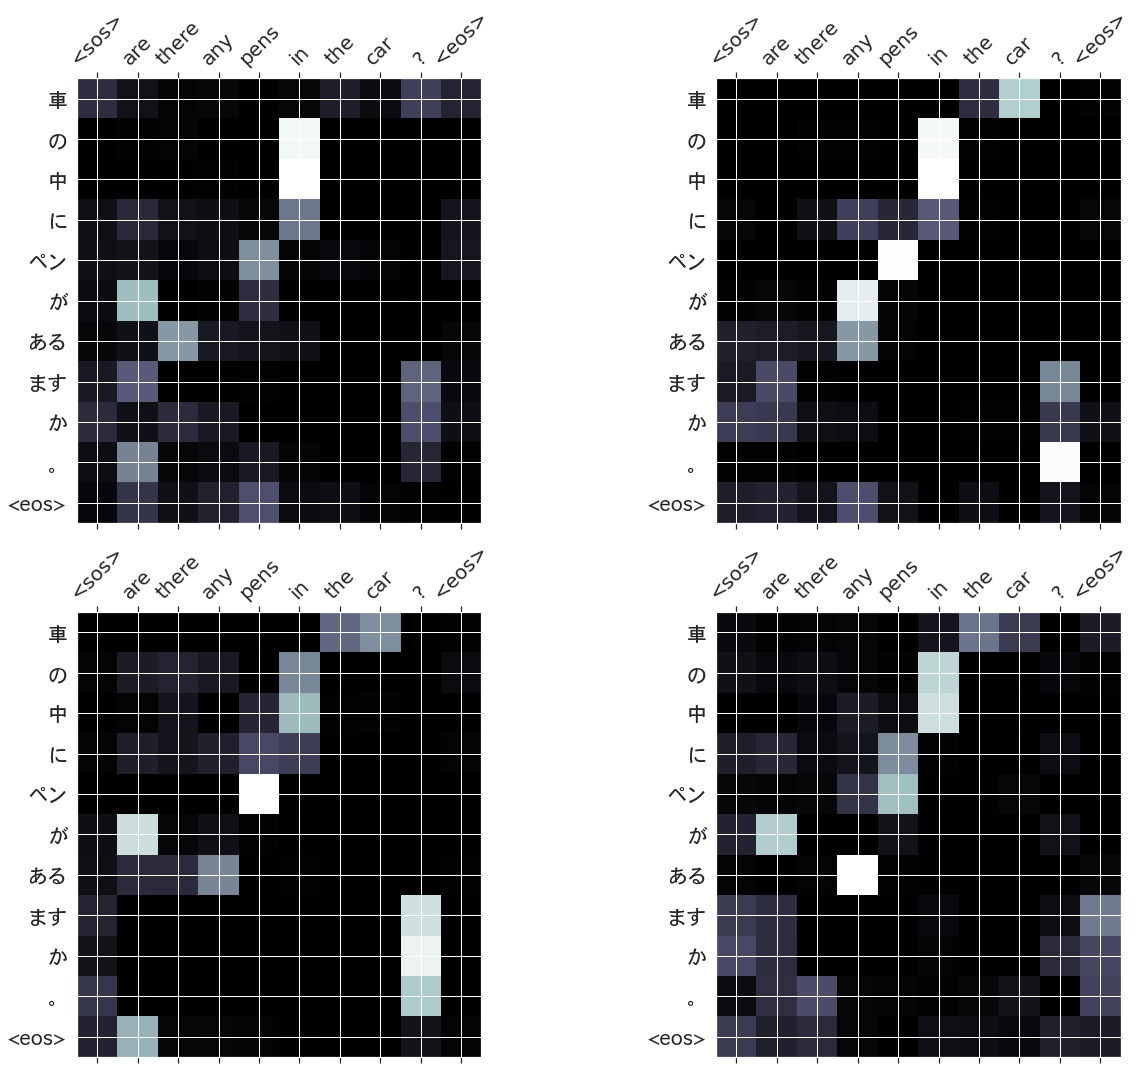

src      : they drew the boat on the beach .
trg      : 彼ら は その 船 を 岸 に あげる た 。
predicted: 彼ら は 船 を 岸 に 引き上げる た 。 <eos>
     blue: 93.91%


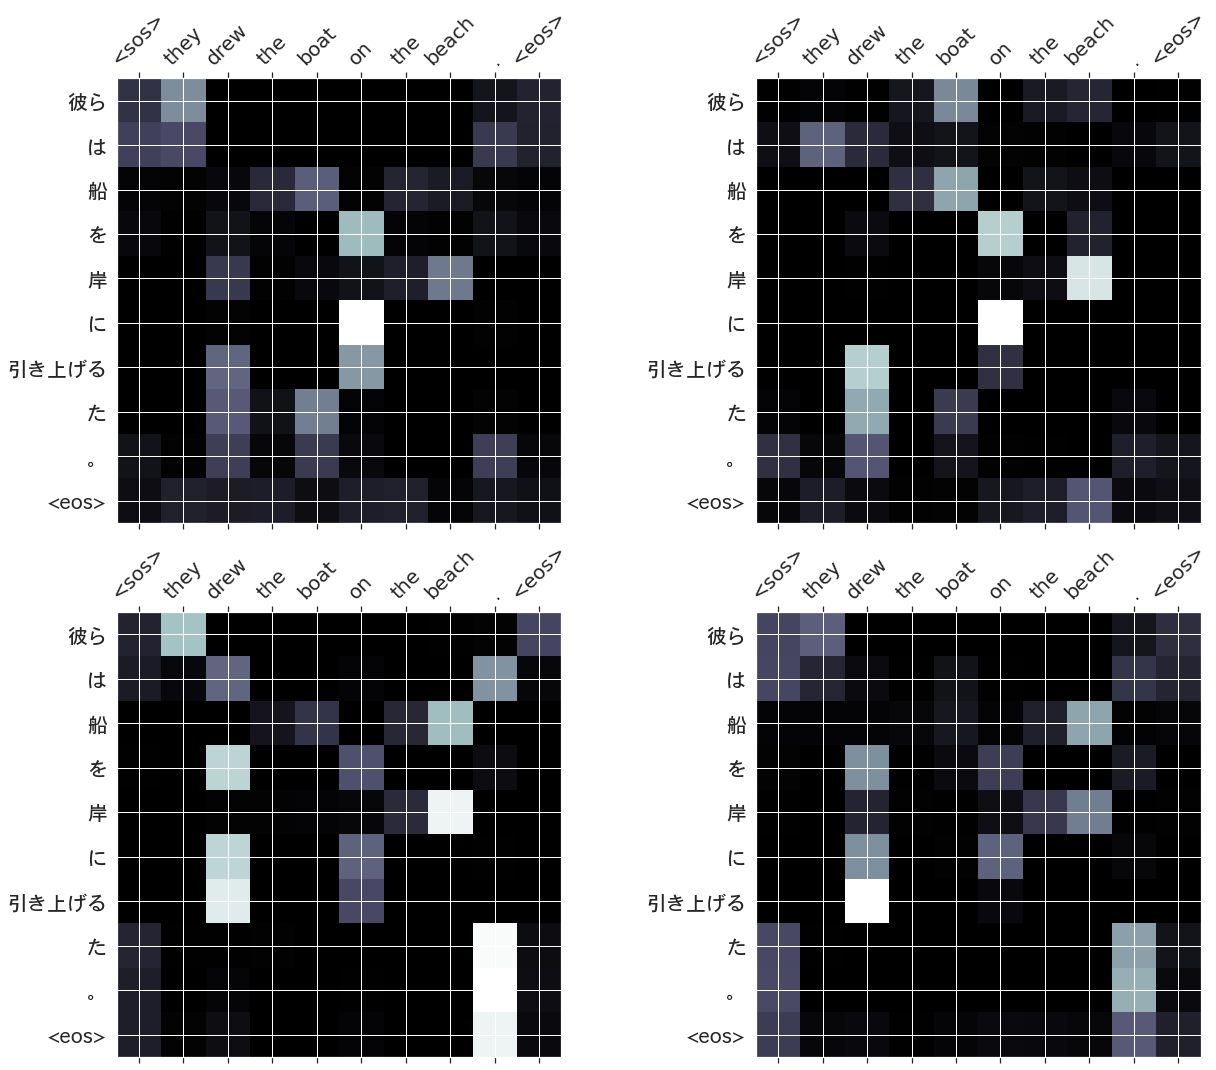

src      : he crossed over the sea .
trg      : 彼 は 海 を 渡る た 。
predicted: 彼 は 海 を 越える て 渡る た 。 <eos>
     blue: 90.36%


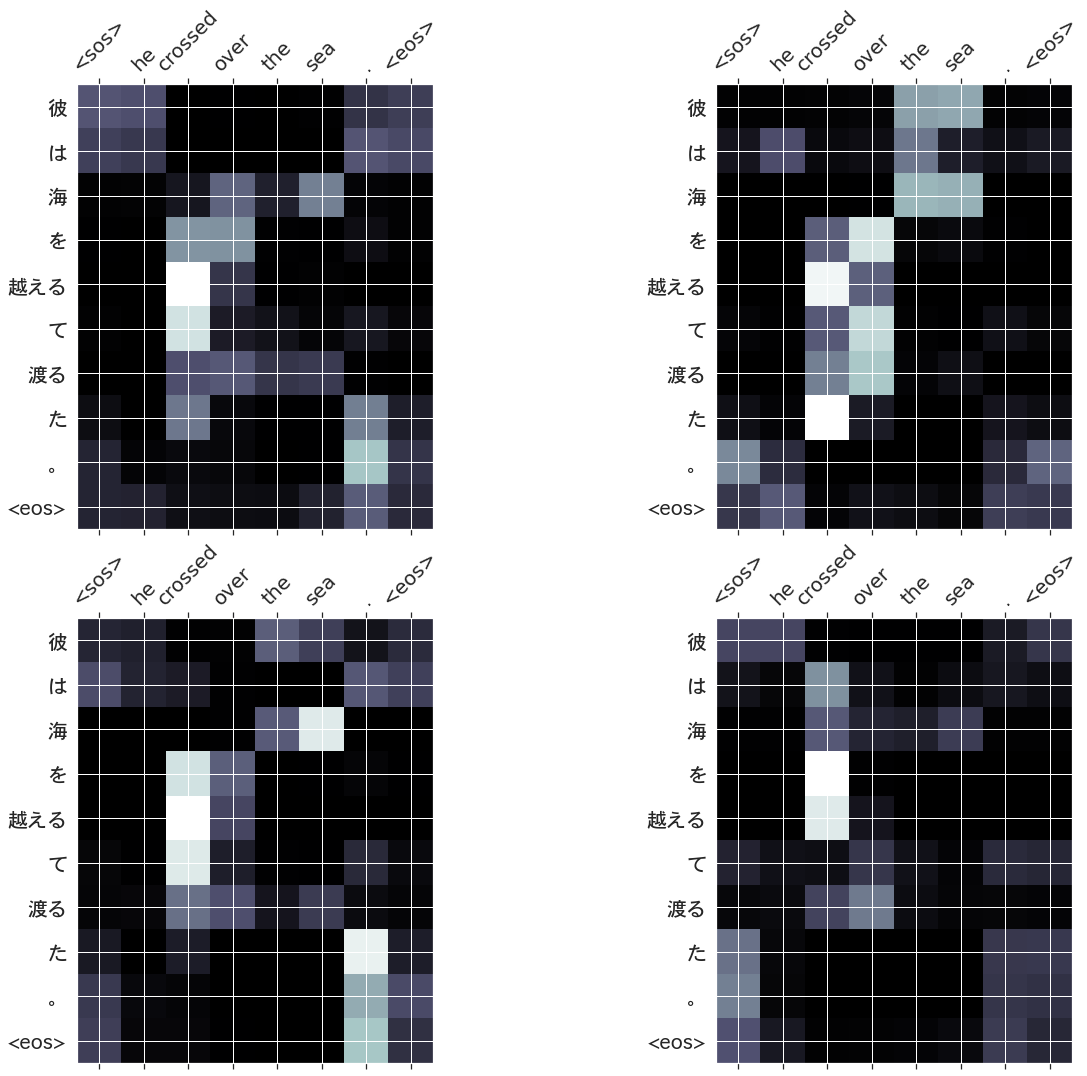

src      : it wo n't be long before he is up and about .
trg      : まもなく 彼 は 病気 が 治る て 動き出す だ う 。
predicted: まもなく 彼 は 起きる て いる だ う 。 <eos>
     blue: 90.36%


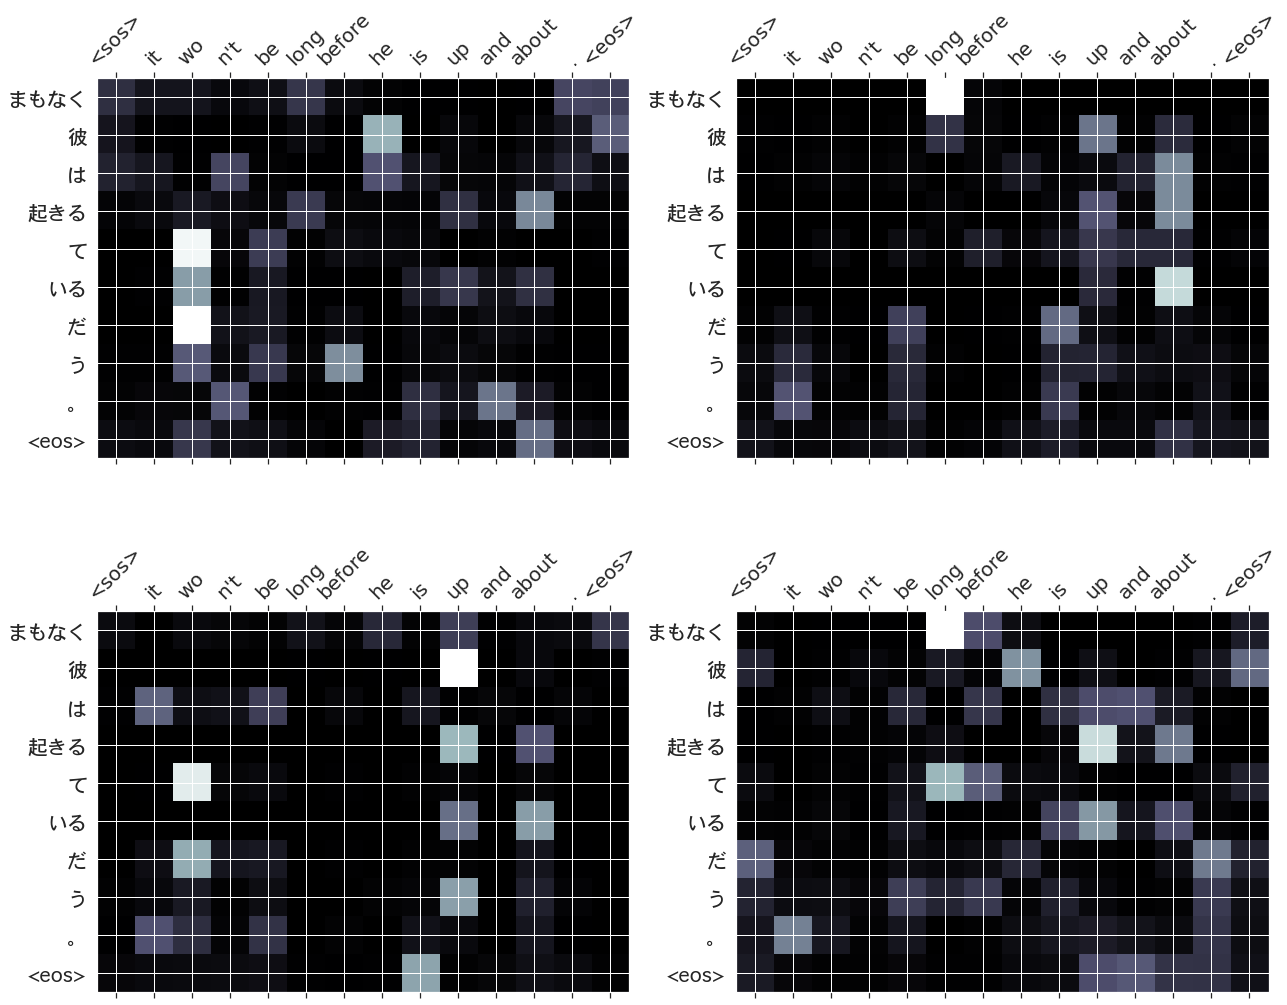

src      : i fed some meat to my dog .
trg      : 私 は 犬 に 肉 を 与える た 。
predicted: 私 は 犬 に 肉 を やる た 。 <eos>
     blue: 97.10%


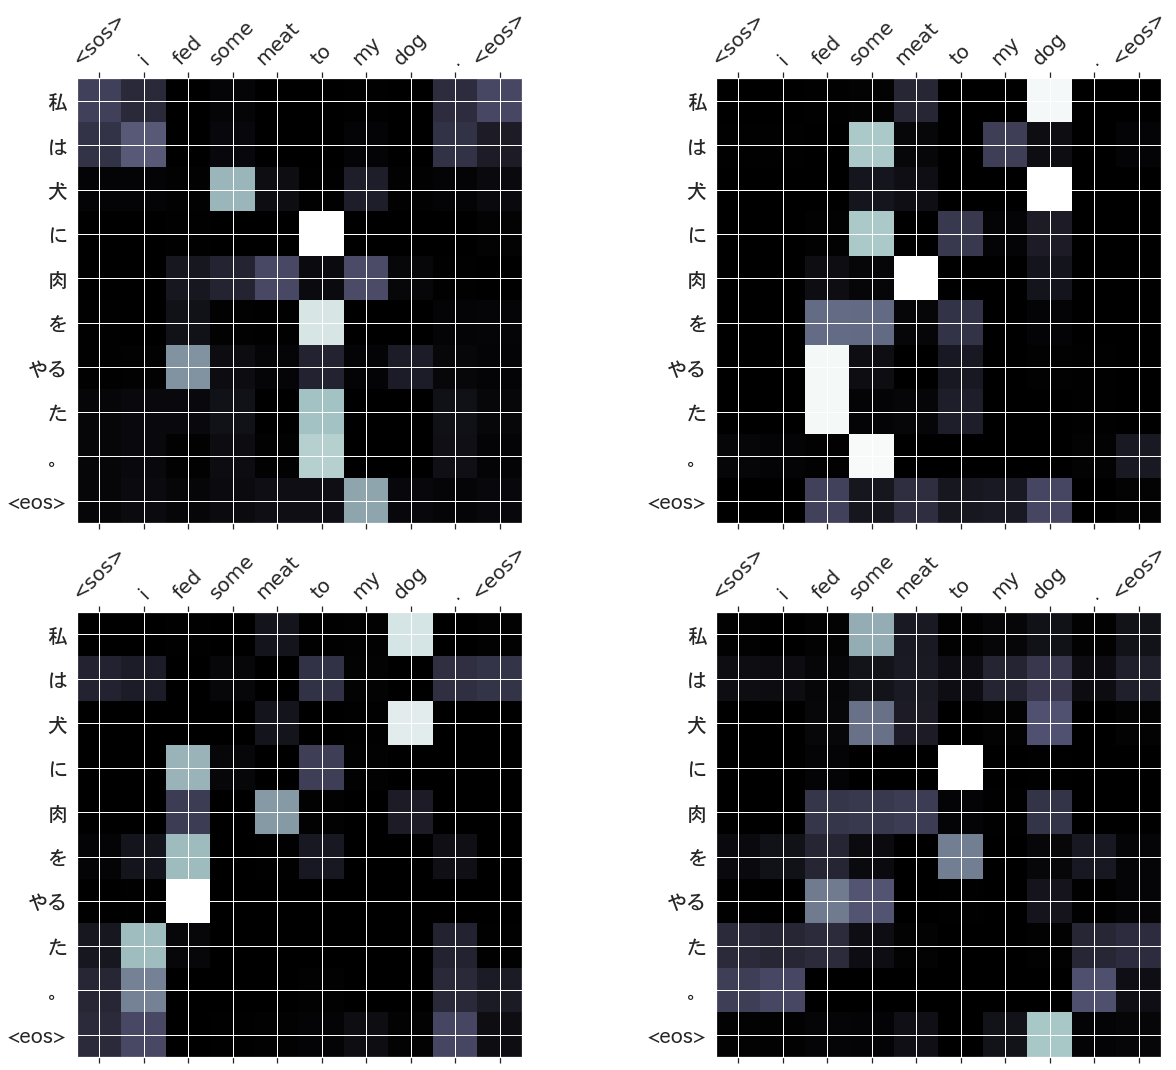

src      : do n't speak with your mouth full .
trg      : 口 に 食物 を いっぱい 入れる て しゃべる な 。
predicted: 口 に 物 を 入れる て 話す な 。 <eos>
     blue: 93.91%


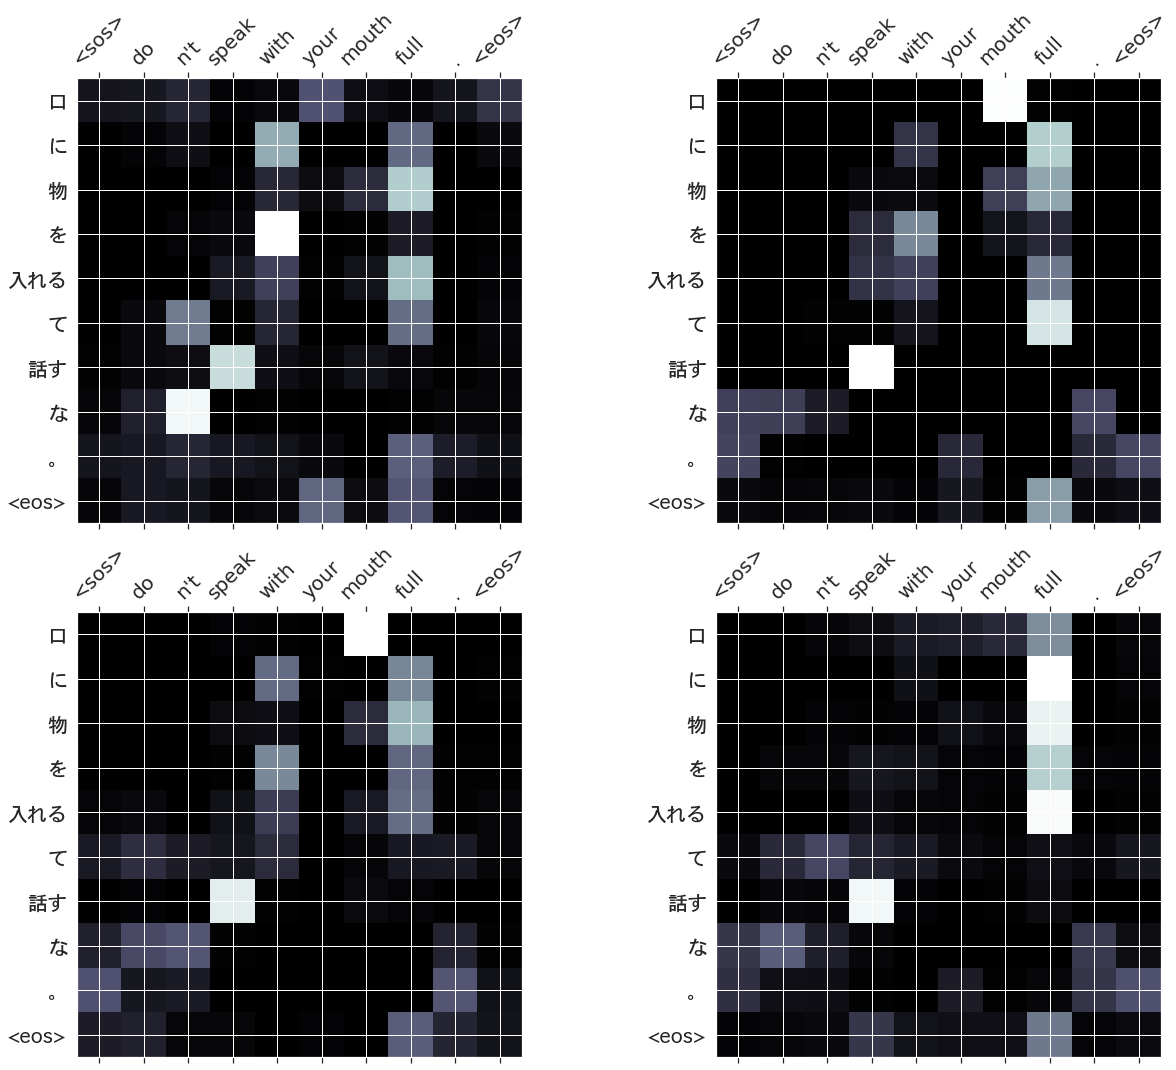

src      : i 'd like to change my seat .
trg      : 席 を 替える て ほしい の です が 。
predicted: 席 を 替える て くださる 。 <eos>
     blue: 90.36%


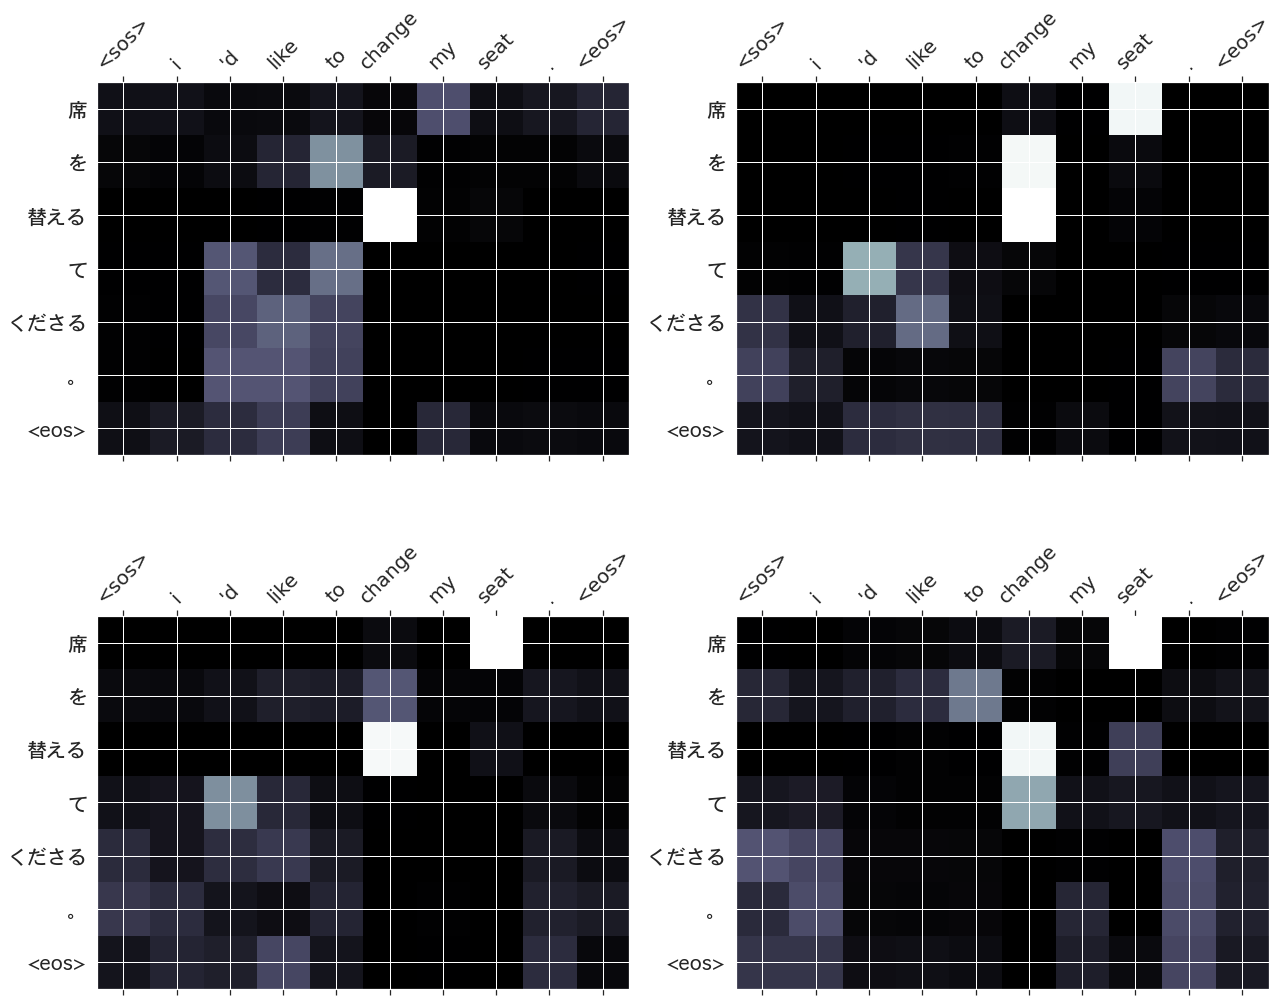

src      : she lived there for years .
trg      : 彼女 は そこ に 何 年間 も 住む で いる た 。
predicted: 彼女 は そこ に 何 年 も 住む で いる た 。 <eos>
     blue: 90.36%


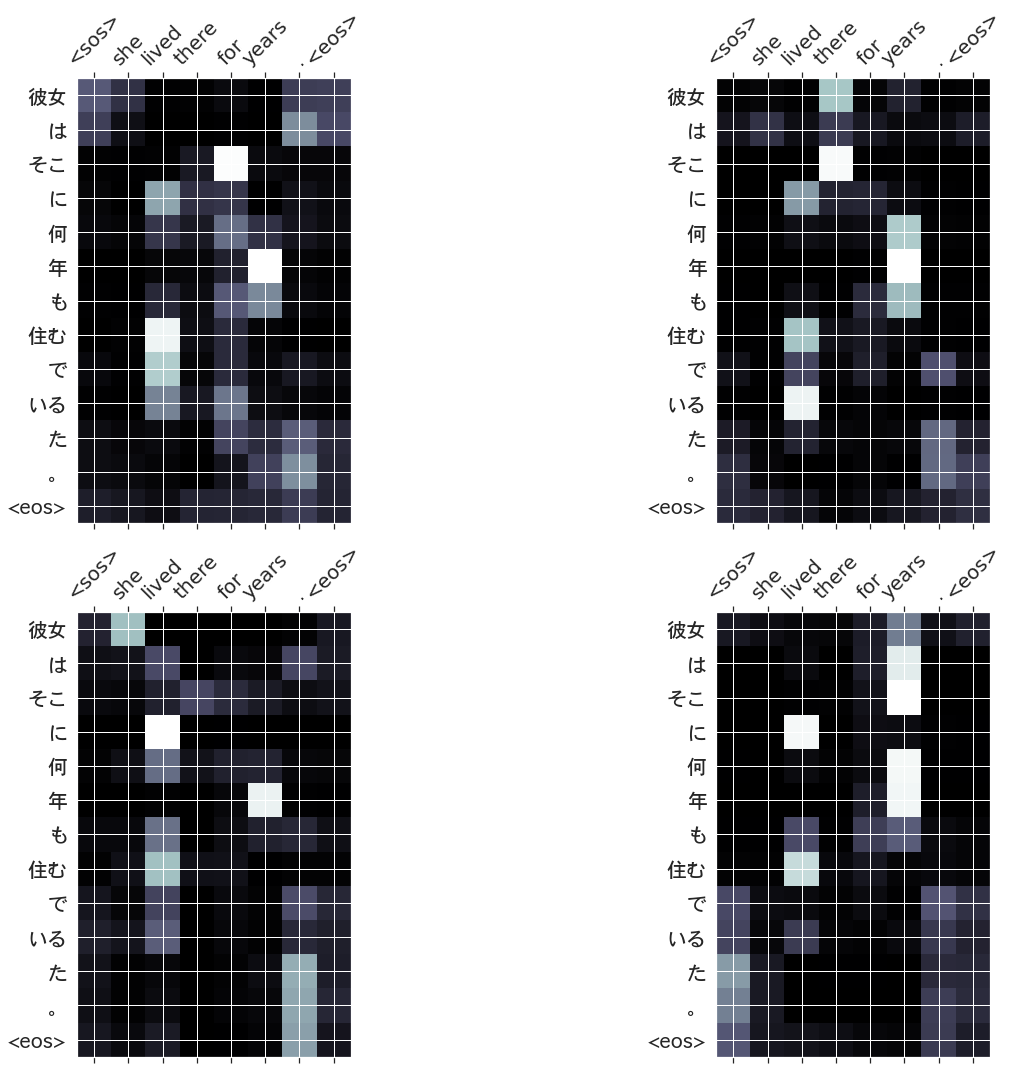

src      : he is on speaking terms with his classmates .
trg      : 彼 は クラス の みんな と 仲 が よい 。
predicted: 彼 は クラスメート と 仲 が よい 。 <eos>
     blue: 93.06%


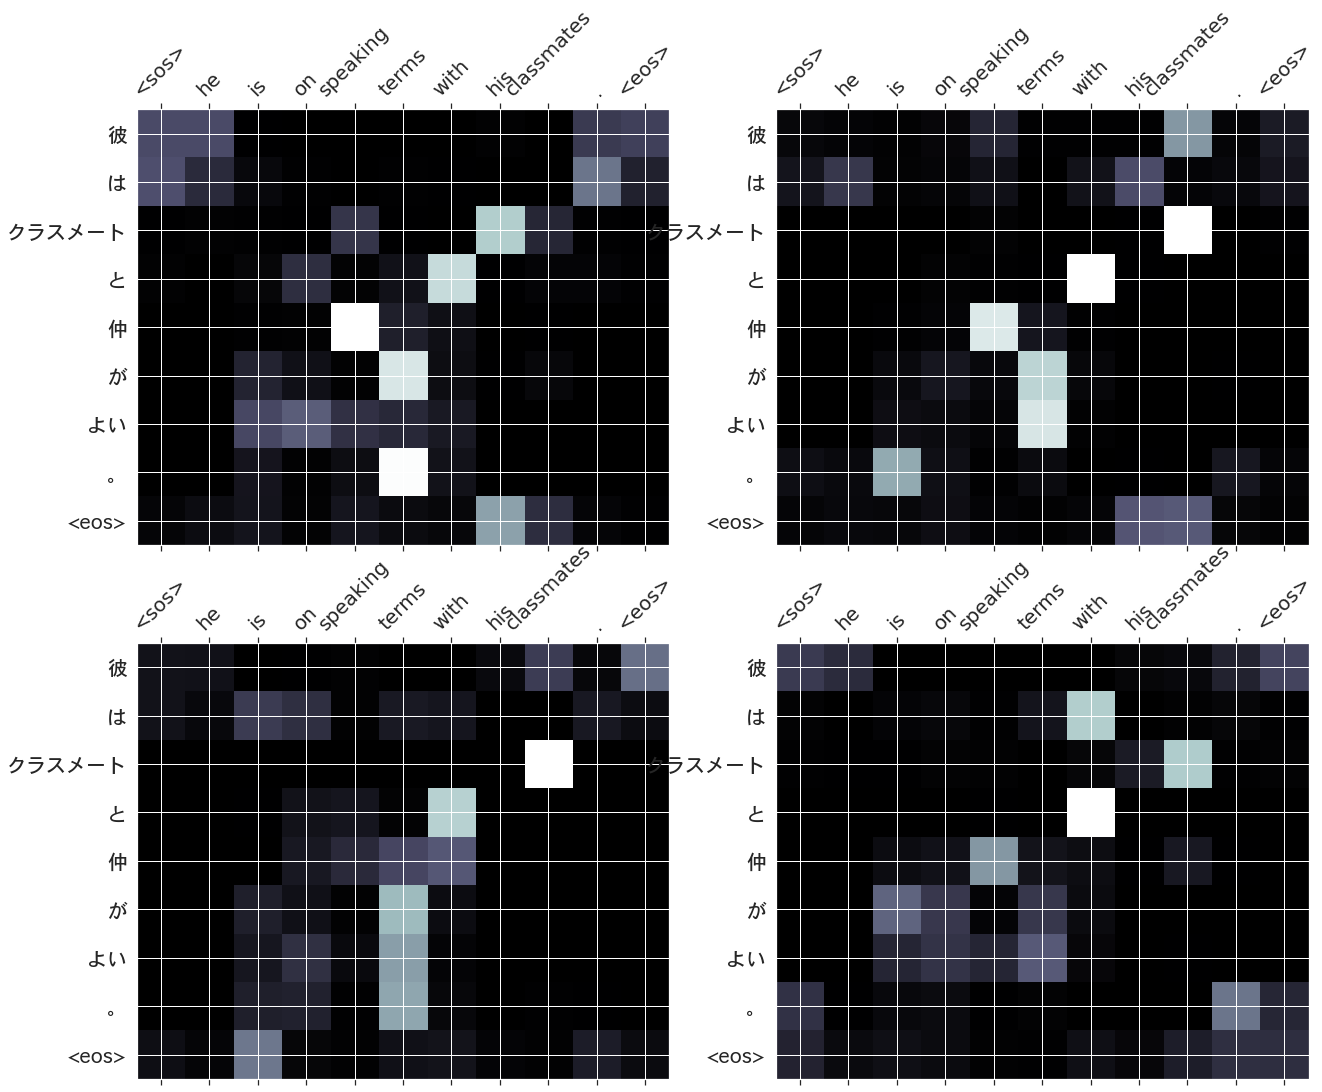

src      : he went on a one - day trip .
trg      : 彼 は 日帰り 旅行 に 行く た 。
predicted: 彼 は 一 日 旅 に 出る た 。 <eos>
     blue: 93.91%


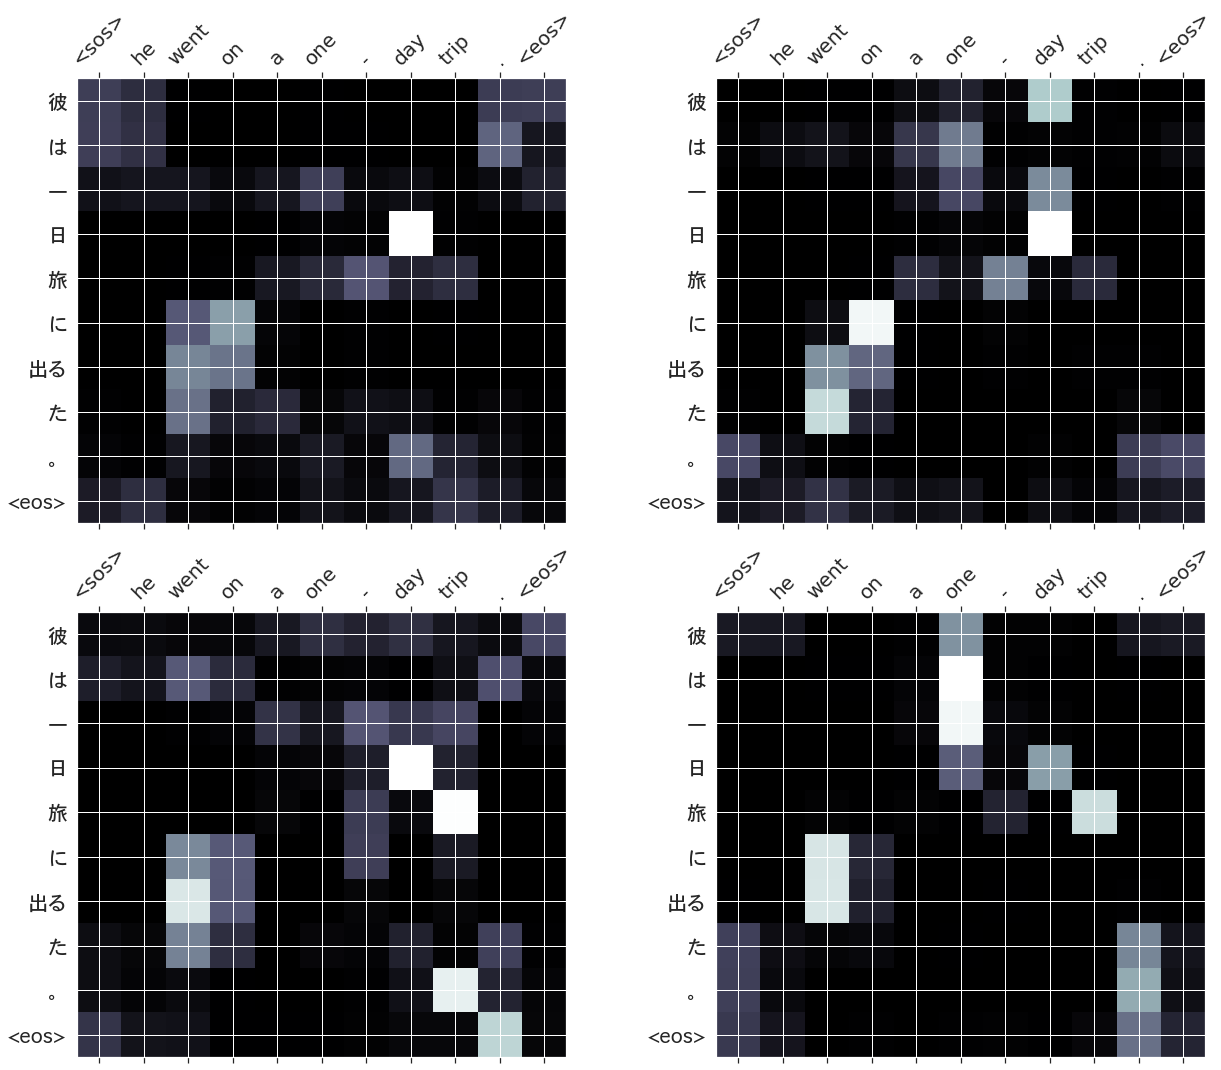

src      : there is a television in my room .
trg      : 私 の 部屋 に は テレビ が ある 。
predicted: 私 の 部屋 に は テレビ が ある 。 <eos>
     blue: 90.36%


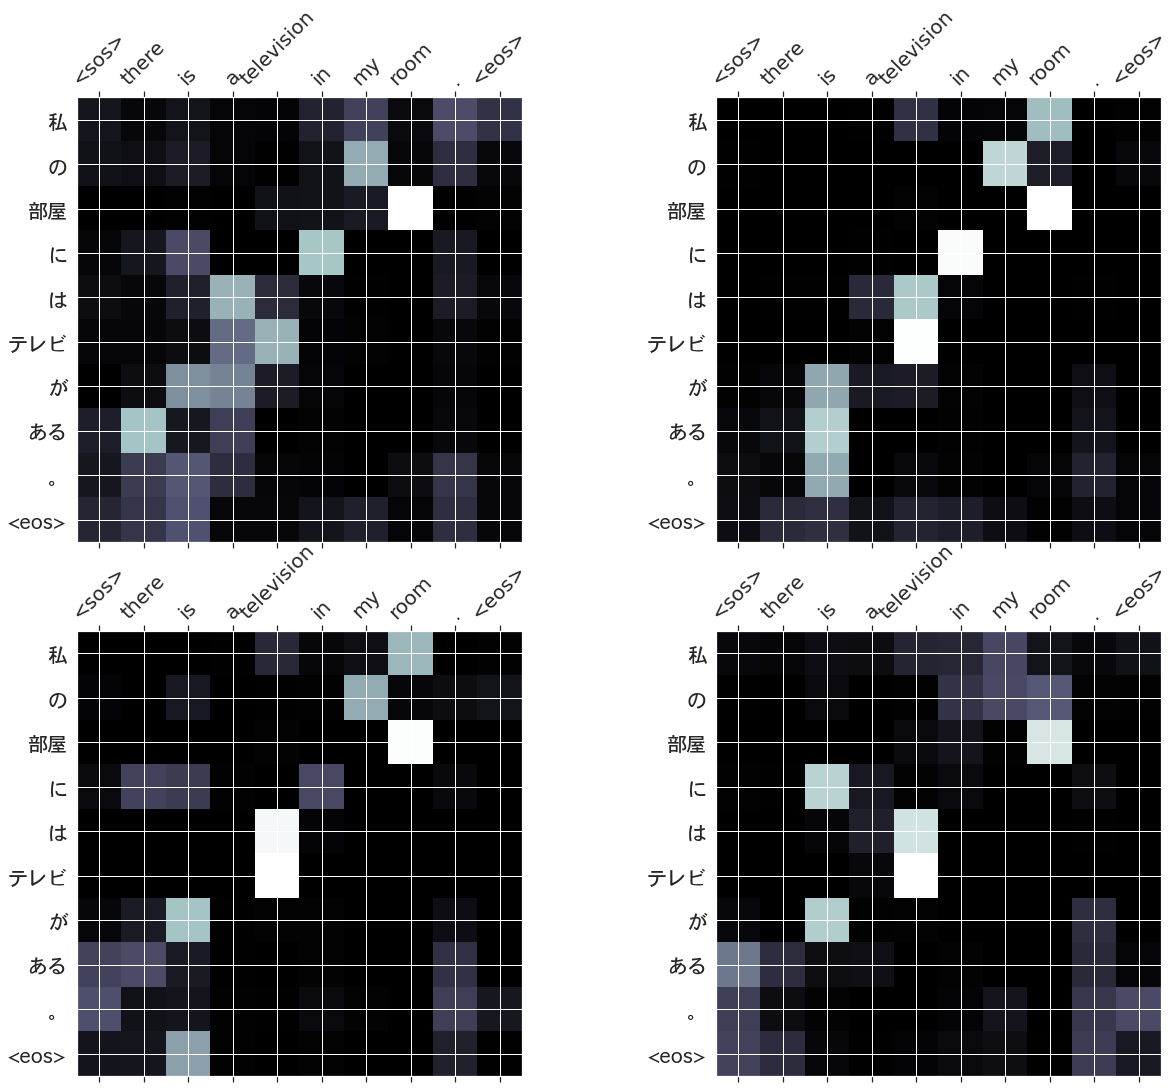

src      : he has an eye for people .
trg      : 彼 は 人 を 見る 目 が ある 。
predicted: 彼 は 人 を 見る 目 が ある 。 <eos>
     blue: 93.91%


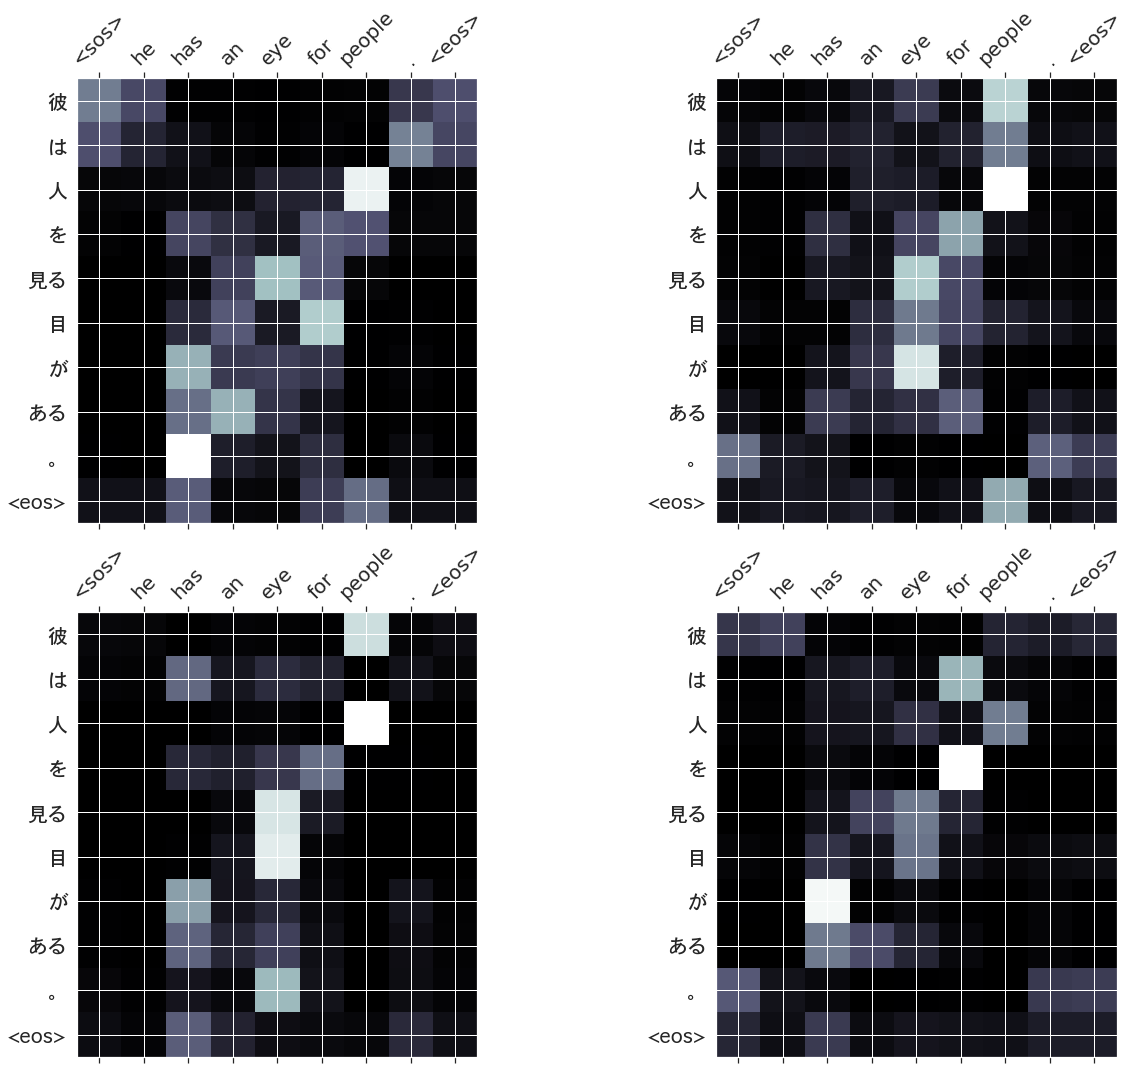

src      : i started this job an hour ago .
trg      : 私 は １ 時間 前 に 仕事 を 始める た 。
predicted: 私 は １ 時間 前 に この 仕事 を 始める た 。 <eos>
     blue: 90.36%


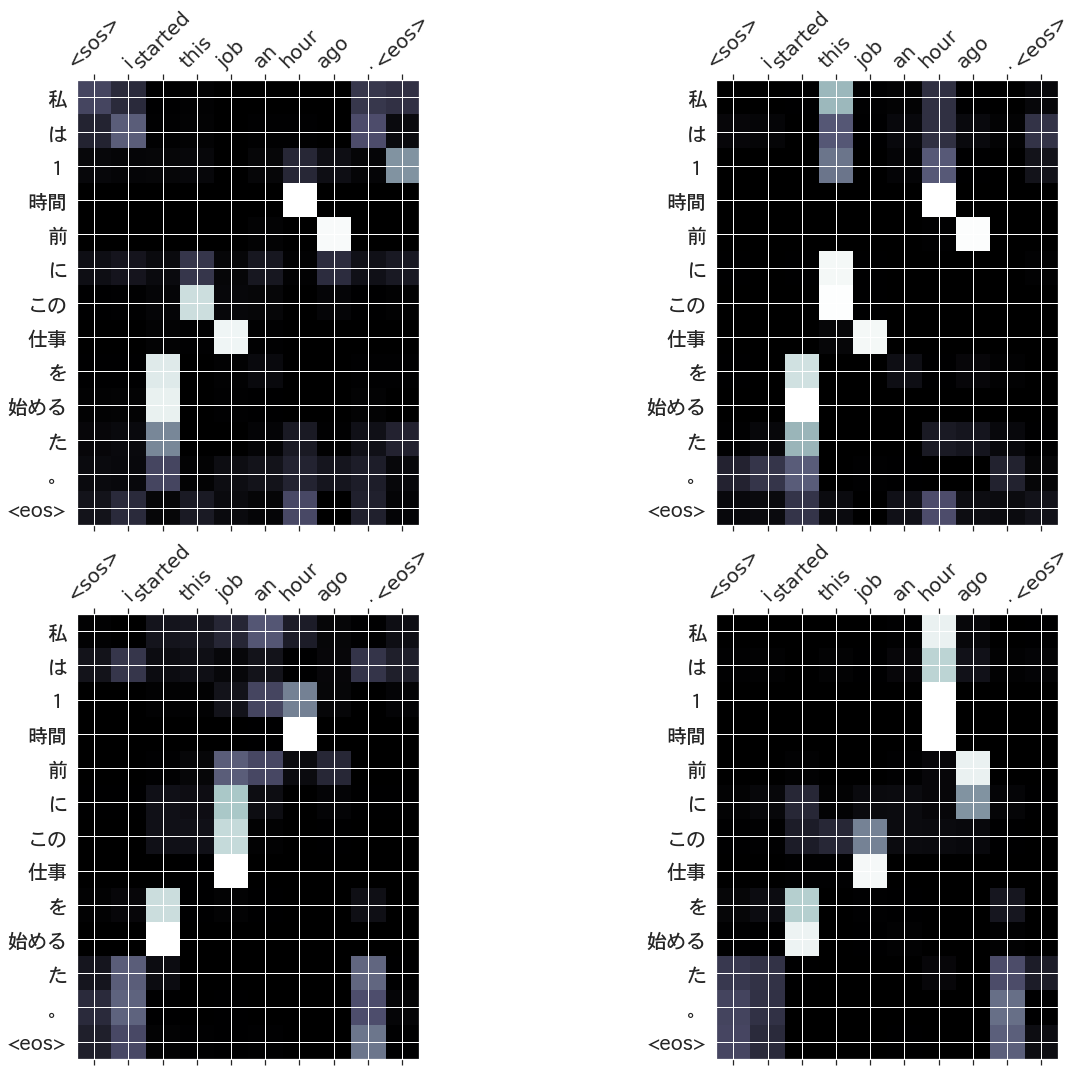

src      : what time do you wake up in the morning ?
trg      : あなた は 朝 何 時 に 目覚める ます か 。
predicted: 朝 何 時 に 起きる ます か 。 <eos>
     blue: 93.06%


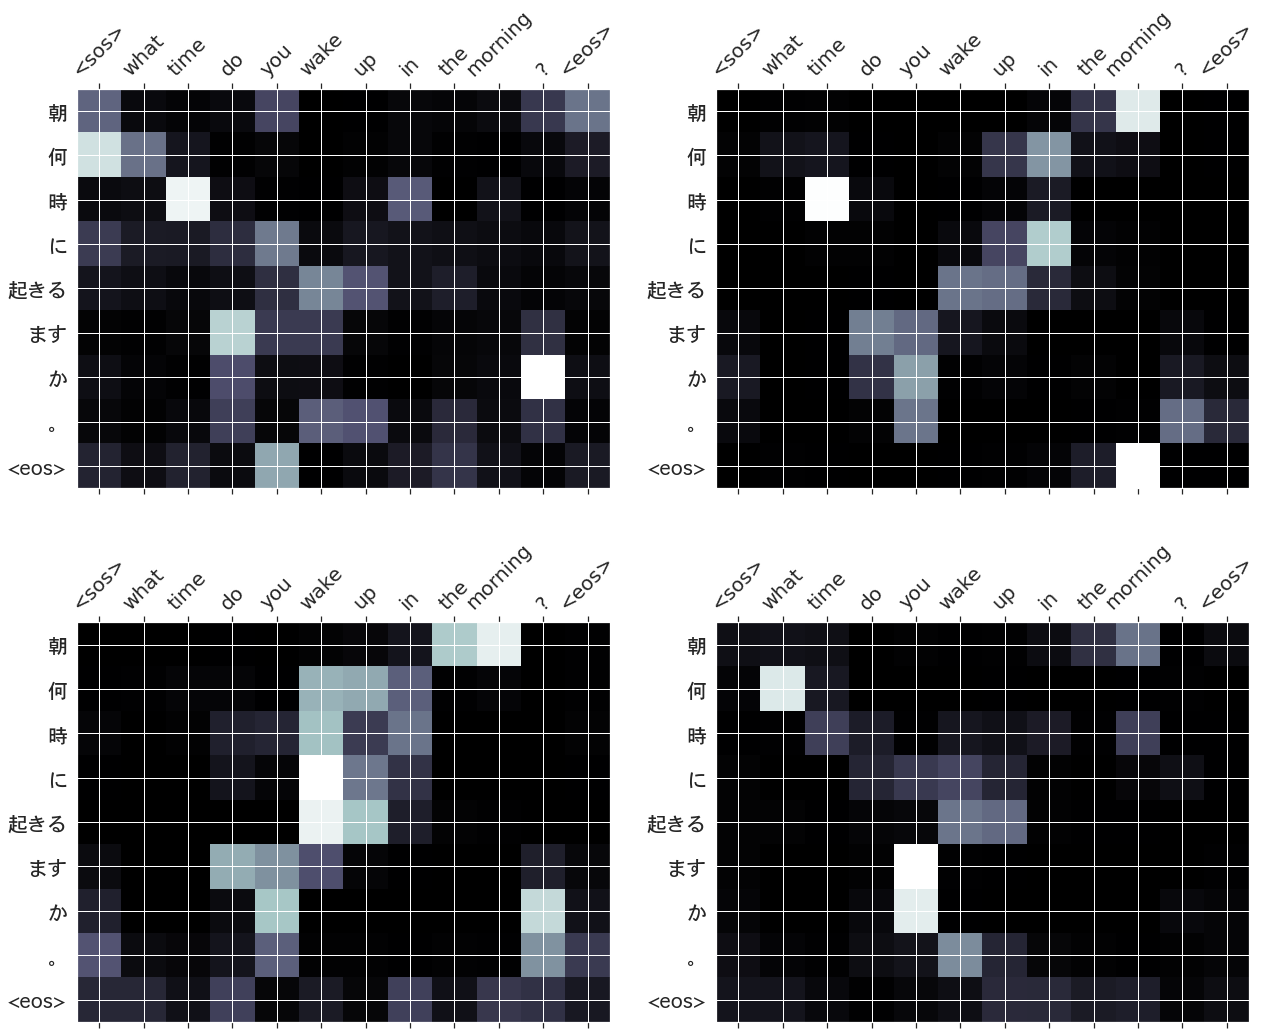

In [ ]:
idxs = list(range(len(test_data)))
random.shuffle(idxs)

count = 0

for example_idx in idxs:
    example_idx = random.randint(0, 1219)
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)
    result = [translation[0]]
    
    blue = sentence_blue(trg, translation, 4)
    if blue < .9:
        continue


    for token in translation:
        if token != result[-1]:
            result.append(token)
    if reverse_src:
        src.reverse()

    if reverse_trg:
        trg.reverse()
        translation.reverse()

    print(f'src      : {" ".join(src)}')
    print(f'trg      : {" ".join(trg)}')
    print(f'predicted: {" ".join(translation)}')
    print(f'     blue: {100 * blue:.2f}%')
    display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

    count += 1
    if count > 50:
        break